# Option Pricing using Deep Learning Model
by Chee-Foong
on 26 Jun 2020

---
## Summary
Traditionally, option prices are valued using the Black-Scholes Model.  The model requires 5 inputs:
1. Strike Price of an option
2. Current Price of the underlying stock
3. Time to expiration
4. Option Type - Call / Put, European / Amercian
5. Risk-free rate
6. Volatility of underlying stock
7. Dividend of underlying stock

The model assumes:
1. Stock prices follow a log-normal distribution because asset prices cannot be negative.
2. There are no transaction costs or taxes
3. The risk-free interest rate is constant for all maturities, that short selling of securities with use of proceeds is permitted
4. There are no arbitrage opportunities without risk.

These data and assumptions are not easily available and are usually reflected in the prices traded in the market.

This analysis attempts to value financial options by means of Artifical Neural Networks. Using Tensorflow and Keras libraries to train a deep learning regression model on the following features:
- Strike Price of an option
- Current Price of the underlying stock
- Time to expiration
- Volatility of underlying stock
- Option Type - Call / Put

and targeting the current option price.  As the model is traded on observable prices and option attributes, I assume all other analytics and assumptions are reflected in the option prices.  The model will be trained and adjust its model weights accordingly.

It is observed that the final model performs reasonably well on unseen data.  The notebook here walk you through the whole model building and validation process.

---
## Loading the libraries

In [70]:
import time

import numpy as np   # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

## Changing the default settings
pd.options.display.max_columns = 50
plt.rcParams.update({'figure.figsize':(15,6), 'figure.dpi':60})
plt.style.use('fivethirtyeight')

import re
import random

import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf

In [2]:
import os
for dirname, _, filenames in os.walk('../data/'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../data/.DS_Store
../data/out_of_sample.csv
../data/train_valid_test.csv


---
## Helper Functions

1. **combineTrainTest** - For data transformation and feature engineering with needs to be applied to both Train and Test set consistently.
2. **splitTrainTest** - For splitting the combined dataset back to train and test after data transformation and feature engineering.
3. **plot_importances** - For showing the feature importances as determined by the model.
4. **plot_scatter** - Scatter plot of 2 variables in a table
5. **plot_pairs** - Pair plot of multi variables in a table
6. **seedeverything** - Setting the seed for reproducible results

In [61]:
def combineTrainTest(train, test, features):
    train = train[features]
    test = test[features]
    out = pd.concat([train, test])
    return out

def splitTrainTest(traintest, train, test, target):
    train = traintest.loc[train.index].join(train[target])
    test = traintest.loc[test.index]
    return train, test

def plot_importances(model, columns, top=20):
    importances = pd.Series(data=model.feature_importances_, index=columns).sort_values()

    plt.figure(figsize=(10,6))
    importances[-top:].sort_values().plot(kind='barh', color='lightgreen')
    plt.title('Features Importances')
    plt.show()
    
def plot_scatter_byGrp(data, xlabel, ylabel, group):    
    fig, ax = plt.subplots(figsize=(12, 6))   
    sns.scatterplot(ax=ax, x=xlabel, y=ylabel, hue=group, data=data)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    ax.xaxis.set_major_formatter(ticker.EngFormatter())
    ax.yaxis.set_major_formatter(ticker.EngFormatter())
    ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(5))
    plt.show()    
    
def plot_scatter(data, xlabel, ylabel):
    fig, ax = plt.subplots()
    ax.scatter(x = data[xlabel], y = data[ylabel])
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    plt.show()    
    
def plot_check(data, xlabel, ylabel):
    fig, ax = plt.subplots()
#     ax.scatter(x = data[xlabel], y = data[ylabel])
    sns.scatterplot(ax=ax, x = xlabel, y = ylabel, data = data)
    plt.xlabel(xlabel, fontsize=13)
    plt.ylabel(ylabel, fontsize=13)
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
        np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes
    ]

    # now plot both limits against eachother
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.show()    

def plot_pairs(data, columns):
    #scatterplot
    sns.set()
    sns.pairplot(data[columns], size = 2.5)
    plt.show()
    
def seedeverything(seed = 3567): 
    random.seed(seed) 
    np.random.seed(seed) 
    os.environ['PYTHONHASHSEED'] = str(seed) 
    tf.random.set_seed(seed)    

In [4]:
SEED = 3567
seedeverything(SEED)

---
## Loading the Dataset

Option data are extracted using the [ThinkOrSwim api](https://developer.tdameritrade.com/apis).  These are plain vanilla CALL and PUT equity options of all the securities in the Dow Jones Industrial Average which have 30 underlying securities.  Each option type will have 20 strikes count at 2.5 intervals covering all Out-Of-The-Money, In-The_Money options.

The dataset contains 15 snapshots of option statistics at 10 minutes intervals during US Market open.  In total, there are 136388 observations.

In [63]:
DATA_FOLDER = '../data/'
traintest = pd.read_csv(DATA_FOLDER + 'train_valid_test.csv')
# test = pd.read_csv(DATA_FOLDER + 'test.csv', index_col='Id')
# submission = pd.read_csv(DATA_FOLDER + 'sample_submission.csv')

In [64]:
print(traintest.shape)

(136388, 20)


In [65]:
traintest.columns

Index(['datetimestamp', 'underlyingSymbol', 'underlyingPrice', 'underlyingVol',
       'putCall', 'strikePrice', 'expirationType', 'inTheMoney',
       'lastTradingDay', 'expirationDate', 'daysToExpiration', 'openInterest',
       'theoreticalVolatility', 'volatility', 'theoreticalOptionValue',
       'closePrice', 'last', 'mark', 'bid', 'ask'],
      dtype='object')

In [66]:
print(pd.to_datetime(traintest.datetimestamp).dt.tz_localize('UTC').dt.tz_convert('US/Eastern').min())
print(pd.to_datetime(traintest.datetimestamp).dt.tz_localize('UTC').dt.tz_convert('US/Eastern').max())

2020-06-24 12:05:54.307853-04:00
2020-06-24 15:04:01.563499-04:00


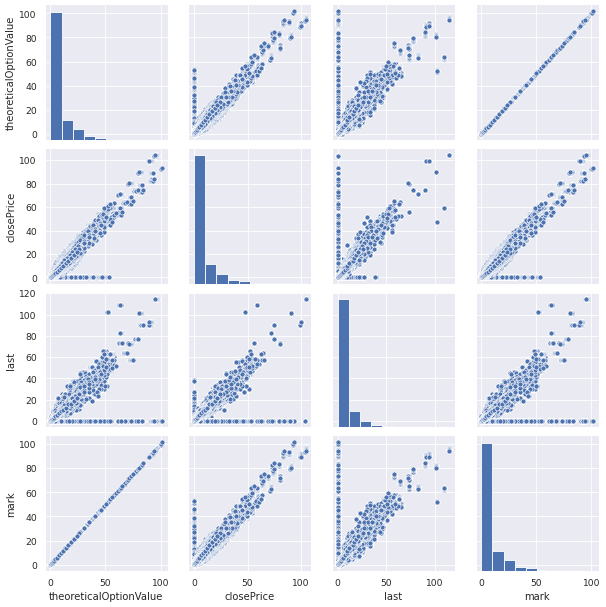

In [67]:
plot_pairs(traintest, ['theoreticalOptionValue','closePrice','last','mark'])

There is a clean linear relationship between **mark** (I believe is Mark-To-Market price) and **theoreticalOptionValue**.  They are almost the same.  We observed **last** and **closePrice** with 0 values which are not logical given that there options are not yet expired.  We also observed a consistent disperation of values for higher valued options.  Higher valued options are In-The-Money options.

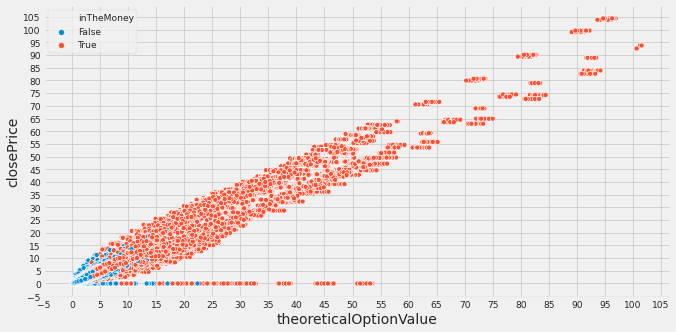

In [71]:
plot_scatter_byGrp(traintest, 'theoreticalOptionValue', 'closePrice', 'inTheMoney')

#### Defining the Targets and Selected Features

**Target** - Current Option Price (using Close Price as a proxy for now.  Other possible options are Last Price or Option Theoretical.  
**Features** - Underlying Symbol, Underlying Last Price, Underlying Volatility, Option Type, Option Strike Price, Days to Expiration

In [10]:
target = ['closePrice'] # 'theoreticalOptionValue','last','closePrice'
features = ['underlyingSymbol','underlyingPrice', 'underlyingVol', 'putCall', 
            'strikePrice','daysToExpiration'] #,'openInterest','inTheMoney'

In [11]:
# Note dates are in UTC Datetime

# traintest['datetimestamp'] = pd.to_datetime(traintest['datetimestamp']) 
# traintest['expirationDate'] = pd.to_datetime(traintest['expirationDate'])
# traintest['lastTradingDay'] = pd.to_datetime(traintest['lastTradingDay'])

Selecting only the required columns

In [12]:
traintest = traintest[features + target]

Eliminating observation that have target value to be 0.  Option price is not expected to be zero before expiry.  Also not logical for last nor close price to be 0.

In [13]:
traintest = traintest[traintest[target[0]] > 0]

---
## Data Exploratory

#### Identifying the data type:  
**Numerical**: underlyingPrice, underlyingVol, strikePrice, daysToExpiration, theoreticalOptionValue  
**Categorical**: underlyingSymbol, putCall

In [14]:
traintest.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134588 entries, 0 to 136387
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   underlyingSymbol  134588 non-null  object 
 1   underlyingPrice   134588 non-null  float64
 2   underlyingVol     134588 non-null  float64
 3   putCall           134588 non-null  object 
 4   strikePrice       134588 non-null  float64
 5   daysToExpiration  134588 non-null  int64  
 6   closePrice        134588 non-null  float64
dtypes: float64(4), int64(1), object(2)
memory usage: 8.2+ MB


Any columns with missing data?

In [15]:
traintest.isnull().any().any()

False

In [16]:
traintest.describe(include=np.number)

,underlyingPrice,underlyingVol,strikePrice,daysToExpiration,closePrice
count,134588.000000,134588.000000,134588.000000,134588.000000,134588.000000
mean,124.287260,0.435568,124.148747,31.483490,7.625923
std,78.221701,0.110696,79.566053,25.935213,10.470750
min,32.015000,0.245444,15.000000,2.000000,0.010000
25%,59.155000,0.376902,59.000000,8.000000,1.180000
50%,111.785000,0.416857,108.000000,23.000000,3.720000
75%,178.620000,0.492266,170.000000,37.000000,9.120000
max,363.275000,0.809673,410.000000,359.000000,104.440000


In [17]:
traintest.describe(include=[np.object])

,underlyingSymbol,putCall
count,134588,134588
unique,30,2
top,INTC,CALL
freq,4926,67387


Splitting the features and target into X and y variables respectively

In [18]:
X = traintest[features]
y = traintest[target]

---
## Feature Engineering

Intentional to exclude the optionPayoff calculation and the moneyness indicator to see whether the deep learning models will perform as well.

In [19]:
# def calProfitLoss(callput, price, strike):
#     out = 0
#     if callput == 'CALL':
#         out = max(0, price-strike)
#     else:
#         out = max(0, strike-price)
#     return out

# X['optionPayoff'] = X.apply(lambda x: calProfitLoss(x.putCall, x.underlyingPrice, x.strikePrice), axis=1)

In [20]:
# apply le on categorical feature columns
# le = LabelEncoder()
# X['inTheMoney'] = le.fit_transform(X['inTheMoney'])

## Data Transformation
Transformation of features for tensorflow.
1. Numeric features - Normalised
2. Numeric target - Normalised
3. Binary features - Label Encoded
4. Multilabel features - One Hot Encoded

All encoders and scalers are saved so that similar transformation can be applied to test data (unseen data) for model predictions.

### More libraries

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler

### More helper functions

1. **appendbyCol** - Append two dataframes with the same number of rows by columns.
2. **processOHE** - One Hot Encoding train-valid-test datasets by columns.  Return train-fitted OHE.
3. **applyOHE** - One Hot Encoding similar dataset by columns with train-fitted OHE.
4. **processLE** - Label Encoding train-valid-test datasets by columns.  Return train-fitted Label Encoder.
5. **applyLE** - Label Encoding similar dataset by columns with train-fitted Label Encoder.
6. **processStdScaler** - Normalising train-valid-test datasets by columns.  Return train-fitted Scaler.
7. **applyStdScaler** - Normalising similar dataset by columns with train-fitted Scaler.

In [22]:
def appendbyCol(df1, df2):
    df = pd.concat([df1.reset_index(drop=True), df2.reset_index(drop=True)], axis=1)
    return df

def processOHE(train, test, valid, column, drop=True):
    
    train_ohe = train.copy()
    test_ohe = test.copy()
    valid_ohe = valid.copy()
    
    ohe = OneHotEncoder(sparse=False, handle_unknown='error')
        
    ohe.fit(train[[column]])
    train_ohe = applyOHE(train_ohe, column, ohe, drop)
    test_ohe = applyOHE(test_ohe, column, ohe, drop)
    valid_ohe = applyOHE(valid_ohe, column, ohe, drop)
        
    return train_ohe, test_ohe, valid_ohe, ohe

def applyOHE(data, column, ohe_fitted, drop=True):
    transformed = ohe_fitted.transform(data[[column]])
    columns = list(ohe_fitted.categories_[0])
    out = pd.DataFrame(transformed, columns=columns)
    data = appendbyCol(data, out)
    if drop: 
        data.drop(column, axis=1, inplace=True)
    return data

def processLE(train, test, valid, column):
    
    train_le = train.copy()
    test_le = test.copy()
    valid_le = valid.copy()
    
    le = LabelEncoder()
        
    le.fit(train[[column]])
    train_le[column] = le.transform(train[[column]])
    test_le[column] = le.transform(test[[column]])
    valid_le[column] = le.transform(valid[[column]])
        
    return train_le, test_le, valid_le, le

def applyLE(data, column, le_fitted):
    data[column] = le_fitted.transform(data[[column]])
    return data

def processStdScaler(train, test, valid, columns):
    
    train_scaled = train.copy()
    test_scaled = test.copy()
    valid_scaled = valid.copy()

    scaler = StandardScaler()
    scaler.fit(train[columns])
    train_scaled[columns] = scaler.transform(train[columns])
    test_scaled[columns] = scaler.transform(test[columns])
    valid_scaled[columns] = scaler.transform(valid[columns])

    return train_scaled, test_scaled, valid_scaled, scaler

def applyStdScaler(data, columns, scaler_fitted):
    data_scaled = data.copy()
    data_scaled[columns] = scaler_fitted.transform(data[columns])
    return data_scaled

Creating the datasets:

1. X_train, y_train
2. X_valid, y_valid
3. X_test, y_test

*X_ prefix as features, y_ prefix as target*

In [23]:
## Not using pandas get dummies
# X = pd.get_dummies(X, drop_first=True)

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=SEED)
X_test, X_valid, y_test, y_valid = train_test_split(X_valid, y_valid, test_size=0.5, random_state=SEED)

### Numerical Features

Normalising the numerical features

In [24]:
tonormalise = ['underlyingPrice','underlyingVol','strikePrice',
               'daysToExpiration'] # ,'openInterest','optionPayoff'

In [25]:
X_train, _, X_valid, trainScaler = processStdScaler(X_train, X_test, X_valid, tonormalise)

### Catergorical Features

Transforming for train and validation dataset.

In [26]:
X_train, _, X_valid, putCall_LE = processLE(X_train, X_test, X_valid, 'putCall')
X_train, _, X_valid, symbol_OHE = processOHE(X_train, X_test, X_valid, 'underlyingSymbol')

### Similar Transformation for Test Dataset
Transform for test dataset.  Note that I could have performed the transformation of the test dataset togther with the train and validation dataset but was excluded on purpose so that is more realistic in a production environment.

In [27]:
X_test = applyStdScaler(X_test, tonormalise, trainScaler)
X_test = applyOHE(X_test, 'underlyingSymbol', symbol_OHE)
X_test = applyLE(X_test, 'putCall', putCall_LE)

### Normalising the Target variable
Only applicable for train and validation target variable.  Target variable for the test dataset will be compared with the predicted values after reversed transformation.

In [28]:
targetScaler = StandardScaler()
targetScaler.fit(y_train)
y_train[target] = targetScaler.transform(y_train)
y_valid[target] = targetScaler.transform(y_valid)

Cleaning up and ensure the shape of the dataset are per expectation

In [29]:
y_train.reset_index(drop=True, inplace=True)
y_valid.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

In [30]:
print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(121129, 35)
(121129, 1)
(6730, 35)
(6730, 1)
(6729, 35)
(6729, 1)


## Training

In [31]:
# !pip install tensorflow
# !pip install -q git+https://github.com/tensorflow/docs

### Final Features used for model training
1. Underlying Stock Price - Stock price at the point of option valuation
2. Underlying Volatility - Annual historical volatility of stock price
3. Option Strike Price - Option attribute
4. Option Days to Expiry - Number of days between valuation date and option expiry date
5. Option Type - Option attribute (Call or Put)

#### Excluded on purpose
6. Option Payoff - Option payoff at valuation date if valuation date = expiry date
7. Moneyness - Whether the option is currently in the money (known by comparing underlying stock price and option strike price

In [32]:
INPUTS = len(X_train.columns)
TRAINING_OBSERVATIONS = X_train.shape[0]
print('Number of inputs to neural network: {}'.format(INPUTS))
print('Number of training observations: {}'.format(TRAINING_OBSERVATIONS))

X_train = np.array(X_train)
y_train = np.array(y_train)
X_valid = np.array(X_valid)
y_valid = np.array(y_valid)

Number of inputs to neural network: 35
Number of training observations: 121129


### Model Building Considerations:
1. Problem Identification 
    - Binary, Multiclass, Multilabel, Regression
2. Number of Dense layers
    - What is the Activation function
    - Number of Nodes in each layer
    - Any kernel_initializer?
3. Optimization function
    - learning rate and many other parameters (to explore)
4. Loss function
5. Metrics
6. Fitting Parameters
    - Optimal Batch Size
    - Training and Validation Dataset
    - Number of EPOCHS
    - EarlyStopping - patience number
    - ModelCheckpoint

Additional Considerations:
1. Normalisation layers
2. Dropout layers

In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import RMSprop, Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

def build_model(nodes=(16,32,16), activation='relu', learning_rate=0.002, input_dropout=0.05):
    model = Sequential()

    model.add(Dense(nodes[0], input_shape=(INPUTS,), activation='relu', kernel_initializer='normal'))
    model.add(tf.keras.layers.Dropout(input_dropout))
    
    for node in nodes[1:]:
        model.add(Dense(node, activation='relu', kernel_initializer='normal'))

    # model.add(tf.keras.layers.BatchNormalization())

    model.add(Dense(1))

    # opt = tf.keras.optimizers.RMSprop(learning_rate)
    # opt = 'RMSprop'
    opt = Adam(lr=learning_rate, beta_1=0.9, beta_2=0.99, epsilon=None, decay=0.0, amsgrad=False)

    model.compile(optimizer=opt, loss='mse', metrics=['mae', 'mse'])

    return model

### Hyperparameters Search

Balancing between the complexity and accuracy of the deep learning model, my objective is always to build a simple model that trains efficiently without compromising too much on accuracy.  Hence, I start off by using a 3-layer model, limiting myself to 256, 512 and 1024 nodes in each layer.  Such permutations will generate 27 different models for model fitting.  Combined with other parameters:
1. Type of activation function in the layers - limiting to one type per model
2. Batch Size
3. Number of Epochs
4. Learning Rate
5. Dropout rate for Dropout Layer (if necessary)

I have tried many different permutations of parameters.  I am using the parameters that are most optimal so that the whole search process will not be too long.

Grid Search will search for the optimal parameters for each model by looking for the one with the lowest MSE, 3-fold cross valiation on only the train dataset.  With the settings, the whole process took around **12** hours to complete on my computer.

In [34]:
import itertools

layer1 = [256,512,1024]
layer2 = [256,512,1024]
layer3 = [256,512,1024]
layers = [layer1, layer2, layer3]

NODES_LIST = list(itertools.product(*layers))
ACTIVATION_LIST = ['relu'] ## 'relu', 'sigmoid', 'tanh', 'leaky_relu'
BATCHSIZE_LIST = [256]
EPOCHS_LIST = [200]
LEARNINGRATE_LIST = [0.0005]
INPUTDROPOUT_LIST = [0]

# Define the parameters to try out
params = {'nodes': NODES_LIST, 
          'activation': ACTIVATION_LIST, 
          'batch_size': BATCHSIZE_LIST, 
          'epochs': EPOCHS_LIST, 
          'input_dropout': INPUTDROPOUT_LIST, 
          'learning_rate': LEARNINGRATE_LIST}

print(params)

{'nodes': [(256, 256, 256), (256, 256, 512), (256, 256, 1024), (256, 512, 256), (256, 512, 512), (256, 512, 1024), (256, 1024, 256), (256, 1024, 512), (256, 1024, 1024), (512, 256, 256), (512, 256, 512), (512, 256, 1024), (512, 512, 256), (512, 512, 512), (512, 512, 1024), (512, 1024, 256), (512, 1024, 512), (512, 1024, 1024), (1024, 256, 256), (1024, 256, 512), (1024, 256, 1024), (1024, 512, 256), (1024, 512, 512), (1024, 512, 1024), (1024, 1024, 256), (1024, 1024, 512), (1024, 1024, 1024)], 'activation': ['relu'], 'batch_size': [256], 'epochs': [200], 'input_dropout': [0], 'learning_rate': [0.0005]}


In [35]:
# Import KerasRegressor from keras wrappers
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

# Create a KerasRegressor
grid_buildmodel = KerasRegressor(build_fn = build_model)

grid_search = GridSearchCV(grid_buildmodel, param_grid = params, cv = 3, verbose=0, return_train_score=True)

In [36]:
%time grid_search.fit(X_train, y_train)

Epoch 1/200
316/316 [==============================] - 1s 4ms/step - loss: 0.2535 - mae: 0.2577 - mse: 0.2535
Epoch 2/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0043 - mae: 0.0469 - mse: 0.0043
Epoch 3/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0032 - mae: 0.0399 - mse: 0.0032
Epoch 4/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0022 - mae: 0.0333 - mse: 0.0022
Epoch 5/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0021 - mae: 0.0319 - mse: 0.0021
Epoch 6/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0020 - mae: 0.0307 - mse: 0.0020
Epoch 7/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0017 - mae: 0.0283 - mse: 0.0017
Epoch 8/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0018 - mae: 0.0290 - mse: 0.0018
Epoch 9/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0016 - mae: 0.0270 - mse: 0.0016
Epoch 10/2

316/316 [==============================] - 1s 4ms/step - loss: 3.9073e-04 - mae: 0.0134 - mse: 3.9073e-04
Epoch 72/200
316/316 [==============================] - 1s 4ms/step - loss: 4.4639e-04 - mae: 0.0144 - mse: 4.4639e-04
Epoch 73/200
316/316 [==============================] - 1s 4ms/step - loss: 4.0303e-04 - mae: 0.0135 - mse: 4.0303e-04
Epoch 74/200
316/316 [==============================] - 1s 4ms/step - loss: 4.0369e-04 - mae: 0.0137 - mse: 4.0369e-04
Epoch 75/200
316/316 [==============================] - 1s 4ms/step - loss: 3.8177e-04 - mae: 0.0133 - mse: 3.8177e-04
Epoch 76/200
316/316 [==============================] - 1s 4ms/step - loss: 4.0752e-04 - mae: 0.0137 - mse: 4.0752e-04
Epoch 77/200
316/316 [==============================] - 1s 4ms/step - loss: 3.8552e-04 - mae: 0.0134 - mse: 3.8552e-04
Epoch 78/200
316/316 [==============================] - 1s 4ms/step - loss: 3.7799e-04 - mae: 0.0131 - mse: 3.7799e-04
Epoch 79/200
316/316 [==============================] - 1s 4m

316/316 [==============================] - 1s 4ms/step - loss: 1.8511e-04 - mae: 0.0094 - mse: 1.8511e-04
Epoch 140/200
316/316 [==============================] - 1s 4ms/step - loss: 1.7867e-04 - mae: 0.0093 - mse: 1.7867e-04
Epoch 141/200
316/316 [==============================] - 1s 4ms/step - loss: 1.7439e-04 - mae: 0.0092 - mse: 1.7439e-04
Epoch 142/200
316/316 [==============================] - 1s 4ms/step - loss: 1.7435e-04 - mae: 0.0092 - mse: 1.7435e-04
Epoch 143/200
316/316 [==============================] - 1s 4ms/step - loss: 1.7185e-04 - mae: 0.0091 - mse: 1.7185e-04
Epoch 144/200
316/316 [==============================] - 1s 4ms/step - loss: 1.6517e-04 - mae: 0.0089 - mse: 1.6517e-04
Epoch 145/200
316/316 [==============================] - 1s 4ms/step - loss: 1.6883e-04 - mae: 0.0089 - mse: 1.6883e-04
Epoch 146/200
316/316 [==============================] - 1s 4ms/step - loss: 2.1532e-04 - mae: 0.0100 - mse: 2.1532e-04
Epoch 147/200
316/316 [==============================]

316/316 [==============================] - 1s 4ms/step - loss: 0.0018 - mae: 0.0296 - mse: 0.0018
Epoch 7/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0017 - mae: 0.0287 - mse: 0.0017
Epoch 8/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0016 - mae: 0.0279 - mse: 0.0016
Epoch 9/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0014 - mae: 0.0259 - mse: 0.0014
Epoch 10/200
316/316 [==============================] - 1s 5ms/step - loss: 0.0014 - mae: 0.0256 - mse: 0.0014
Epoch 11/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0014 - mae: 0.0257 - mse: 0.0014
Epoch 12/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0014 - mae: 0.0260 - mse: 0.0014
Epoch 13/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0231 - mse: 0.0011
Epoch 14/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0013 - mae: 0.0243 - mse: 0.0013
Epoch 15/200
316/

Epoch 76/200
316/316 [==============================] - 1s 4ms/step - loss: 4.0642e-04 - mae: 0.0136 - mse: 4.0642e-04
Epoch 77/200
316/316 [==============================] - 1s 4ms/step - loss: 3.9027e-04 - mae: 0.0133 - mse: 3.9027e-04
Epoch 78/200
316/316 [==============================] - 1s 4ms/step - loss: 3.8195e-04 - mae: 0.0132 - mse: 3.8195e-04
Epoch 79/200
316/316 [==============================] - 1s 4ms/step - loss: 3.6629e-04 - mae: 0.0130 - mse: 3.6629e-04
Epoch 80/200
316/316 [==============================] - 1s 4ms/step - loss: 4.1467e-04 - mae: 0.0136 - mse: 4.1467e-04
Epoch 81/200
316/316 [==============================] - 1s 4ms/step - loss: 3.6322e-04 - mae: 0.0129 - mse: 3.6322e-04
Epoch 82/200
316/316 [==============================] - 1s 4ms/step - loss: 3.4343e-04 - mae: 0.0126 - mse: 3.4343e-04
Epoch 83/200
316/316 [==============================] - 1s 4ms/step - loss: 3.3546e-04 - mae: 0.0124 - mse: 3.3546e-04
Epoch 84/200
316/316 [==========================

316/316 [==============================] - 1s 4ms/step - loss: 1.5496e-04 - mae: 0.0086 - mse: 1.5496e-04
Epoch 145/200
316/316 [==============================] - 1s 4ms/step - loss: 1.7172e-04 - mae: 0.0090 - mse: 1.7172e-04
Epoch 146/200
316/316 [==============================] - 1s 4ms/step - loss: 1.7910e-04 - mae: 0.0091 - mse: 1.7910e-04
Epoch 147/200
316/316 [==============================] - 1s 4ms/step - loss: 1.6273e-04 - mae: 0.0087 - mse: 1.6273e-04
Epoch 148/200
316/316 [==============================] - 1s 4ms/step - loss: 1.7362e-04 - mae: 0.0089 - mse: 1.7362e-04
Epoch 149/200
316/316 [==============================] - 1s 4ms/step - loss: 1.8182e-04 - mae: 0.0093 - mse: 1.8182e-04
Epoch 150/200
316/316 [==============================] - 1s 4ms/step - loss: 1.4486e-04 - mae: 0.0082 - mse: 1.4486e-04
Epoch 151/200
316/316 [==============================] - 1s 4ms/step - loss: 1.8045e-04 - mae: 0.0092 - mse: 1.8045e-04
Epoch 152/200
316/316 [==============================]

316/316 [==============================] - 1s 4ms/step - loss: 0.0013 - mae: 0.0247 - mse: 0.0013
Epoch 12/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0013 - mae: 0.0244 - mse: 0.0013
Epoch 13/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0013 - mae: 0.0245 - mse: 0.0013
Epoch 14/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0228 - mse: 0.0011
Epoch 15/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0226 - mse: 0.0011
Epoch 16/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0228 - mse: 0.0011
Epoch 17/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0231 - mse: 0.0012
Epoch 18/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0010 - mae: 0.0218 - mse: 0.0010
Epoch 19/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0224 - mse: 0.0011
Epoch 20/200
3

316/316 [==============================] - 1s 4ms/step - loss: 3.8107e-04 - mae: 0.0131 - mse: 3.8107e-04
Epoch 81/200
316/316 [==============================] - 1s 4ms/step - loss: 3.6260e-04 - mae: 0.0130 - mse: 3.6260e-04
Epoch 82/200
316/316 [==============================] - 1s 4ms/step - loss: 3.5002e-04 - mae: 0.0126 - mse: 3.5002e-04
Epoch 83/200
316/316 [==============================] - 1s 4ms/step - loss: 3.4548e-04 - mae: 0.0126 - mse: 3.4548e-04
Epoch 84/200
316/316 [==============================] - 1s 4ms/step - loss: 3.5396e-04 - mae: 0.0128 - mse: 3.5396e-04
Epoch 85/200
316/316 [==============================] - 1s 4ms/step - loss: 3.3683e-04 - mae: 0.0124 - mse: 3.3683e-04
Epoch 86/200
316/316 [==============================] - 1s 4ms/step - loss: 3.4250e-04 - mae: 0.0126 - mse: 3.4250e-04
Epoch 87/200
316/316 [==============================] - 1s 4ms/step - loss: 3.5524e-04 - mae: 0.0128 - mse: 3.5524e-04
Epoch 88/200
316/316 [==============================] - 1s 4m

316/316 [==============================] - 1s 4ms/step - loss: 1.6321e-04 - mae: 0.0087 - mse: 1.6321e-04
Epoch 149/200
316/316 [==============================] - 1s 4ms/step - loss: 1.7693e-04 - mae: 0.0091 - mse: 1.7693e-04
Epoch 150/200
316/316 [==============================] - 1s 3ms/step - loss: 1.5474e-04 - mae: 0.0085 - mse: 1.5474e-04
Epoch 151/200
316/316 [==============================] - 1s 3ms/step - loss: 1.8270e-04 - mae: 0.0093 - mse: 1.8270e-04
Epoch 152/200
316/316 [==============================] - 1s 4ms/step - loss: 1.6088e-04 - mae: 0.0087 - mse: 1.6088e-04
Epoch 153/200
316/316 [==============================] - 1s 4ms/step - loss: 1.5132e-04 - mae: 0.0085 - mse: 1.5132e-04
Epoch 154/200
316/316 [==============================] - 1s 3ms/step - loss: 1.6136e-04 - mae: 0.0087 - mse: 1.6136e-04
Epoch 155/200
316/316 [==============================] - 1s 4ms/step - loss: 1.5546e-04 - mae: 0.0085 - mse: 1.5546e-04
Epoch 156/200
316/316 [==============================]

316/316 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0237 - mse: 0.0012
Epoch 16/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0012 - mae: 0.0236 - mse: 0.0012
Epoch 17/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0230 - mse: 0.0011
Epoch 18/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0228 - mse: 0.0011
Epoch 19/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0011 - mae: 0.0228 - mse: 0.0011
Epoch 20/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0010 - mae: 0.0215 - mse: 0.0010
Epoch 21/200
316/316 [==============================] - 1s 4ms/step - loss: 9.8052e-04 - mae: 0.0212 - mse: 9.8052e-04
Epoch 22/200
316/316 [==============================] - 1s 4ms/step - loss: 9.8488e-04 - mae: 0.0213 - mse: 9.8488e-04
Epoch 23/200
316/316 [==============================] - 1s 4ms/step - loss: 0.0010 - mae: 0.0219 - mse: 0.001

316/316 [==============================] - 1s 4ms/step - loss: 3.6387e-04 - mae: 0.0129 - mse: 3.6387e-04
Epoch 85/200
316/316 [==============================] - 1s 4ms/step - loss: 3.5264e-04 - mae: 0.0128 - mse: 3.5264e-04
Epoch 86/200
316/316 [==============================] - 1s 4ms/step - loss: 3.5957e-04 - mae: 0.0129 - mse: 3.5957e-04
Epoch 87/200
316/316 [==============================] - 1s 4ms/step - loss: 3.7578e-04 - mae: 0.0130 - mse: 3.7578e-04
Epoch 88/200
316/316 [==============================] - 1s 4ms/step - loss: 3.4167e-04 - mae: 0.0125 - mse: 3.4167e-04
Epoch 89/200
316/316 [==============================] - 1s 4ms/step - loss: 3.4326e-04 - mae: 0.0125 - mse: 3.4326e-04
Epoch 90/200
316/316 [==============================] - 1s 4ms/step - loss: 3.1898e-04 - mae: 0.0122 - mse: 3.1898e-04
Epoch 91/200
316/316 [==============================] - 1s 4ms/step - loss: 3.4600e-04 - mae: 0.0126 - mse: 3.4600e-04
Epoch 92/200
316/316 [==============================] - 1s 4m

316/316 [==============================] - 1s 4ms/step - loss: 1.8445e-04 - mae: 0.0092 - mse: 1.8445e-04
Epoch 153/200
316/316 [==============================] - 1s 4ms/step - loss: 1.6683e-04 - mae: 0.0089 - mse: 1.6683e-04
Epoch 154/200
316/316 [==============================] - 1s 4ms/step - loss: 1.9910e-04 - mae: 0.0096 - mse: 1.9910e-04
Epoch 155/200
316/316 [==============================] - 1s 4ms/step - loss: 1.7205e-04 - mae: 0.0088 - mse: 1.7205e-04
Epoch 156/200
316/316 [==============================] - 1s 5ms/step - loss: 2.0921e-04 - mae: 0.0096 - mse: 2.0921e-04
Epoch 157/200
316/316 [==============================] - 1s 4ms/step - loss: 1.5294e-04 - mae: 0.0085 - mse: 1.5294e-04
Epoch 158/200
316/316 [==============================] - 1s 4ms/step - loss: 1.9302e-04 - mae: 0.0094 - mse: 1.9302e-04
Epoch 159/200
316/316 [==============================] - 1s 4ms/step - loss: 1.8408e-04 - mae: 0.0092 - mse: 1.8408e-04
Epoch 160/200
316/316 [==============================]

Epoch 20/200
316/316 [==============================] - 1s 4ms/step - loss: 9.4007e-04 - mae: 0.0209 - mse: 9.4007e-04
Epoch 21/200
316/316 [==============================] - 1s 4ms/step - loss: 8.7531e-04 - mae: 0.0201 - mse: 8.7531e-04
Epoch 22/200
316/316 [==============================] - 1s 4ms/step - loss: 9.0332e-04 - mae: 0.0205 - mse: 9.0332e-04
Epoch 23/200
316/316 [==============================] - 1s 4ms/step - loss: 8.3931e-04 - mae: 0.0196 - mse: 8.3931e-04
Epoch 24/200
316/316 [==============================] - 1s 4ms/step - loss: 8.6253e-04 - mae: 0.0199 - mse: 8.6253e-04
Epoch 25/200
316/316 [==============================] - 1s 4ms/step - loss: 8.7374e-04 - mae: 0.0200 - mse: 8.7374e-04
Epoch 26/200
316/316 [==============================] - 1s 4ms/step - loss: 8.0098e-04 - mae: 0.0191 - mse: 8.0098e-04
Epoch 27/200
316/316 [==============================] - 1s 4ms/step - loss: 7.9762e-04 - mae: 0.0191 - mse: 7.9762e-04
Epoch 28/200
316/316 [==========================

316/316 [==============================] - 1s 4ms/step - loss: 3.0887e-04 - mae: 0.0119 - mse: 3.0887e-04
Epoch 89/200
316/316 [==============================] - 1s 4ms/step - loss: 2.6897e-04 - mae: 0.0112 - mse: 2.6897e-04
Epoch 90/200
316/316 [==============================] - 1s 4ms/step - loss: 3.0785e-04 - mae: 0.0120 - mse: 3.0785e-04
Epoch 91/200
316/316 [==============================] - 1s 4ms/step - loss: 2.9734e-04 - mae: 0.0118 - mse: 2.9734e-04
Epoch 92/200
316/316 [==============================] - 1s 4ms/step - loss: 2.6518e-04 - mae: 0.0110 - mse: 2.6518e-04
Epoch 93/200
316/316 [==============================] - 1s 4ms/step - loss: 2.8485e-04 - mae: 0.0115 - mse: 2.8485e-04
Epoch 94/200
316/316 [==============================] - 1s 4ms/step - loss: 2.7058e-04 - mae: 0.0112 - mse: 2.7058e-04
Epoch 95/200
316/316 [==============================] - 1s 4ms/step - loss: 2.6660e-04 - mae: 0.0111 - mse: 2.6660e-04
Epoch 96/200
316/316 [==============================] - 1s 4m

316/316 [==============================] - 2s 5ms/step - loss: 1.2311e-04 - mae: 0.0077 - mse: 1.2311e-04
Epoch 157/200
316/316 [==============================] - 1s 4ms/step - loss: 1.6663e-04 - mae: 0.0088 - mse: 1.6663e-04
Epoch 158/200
316/316 [==============================] - 1s 4ms/step - loss: 1.3731e-04 - mae: 0.0081 - mse: 1.3731e-04
Epoch 159/200
316/316 [==============================] - 1s 4ms/step - loss: 1.4799e-04 - mae: 0.0083 - mse: 1.4799e-04
Epoch 160/200
316/316 [==============================] - 1s 4ms/step - loss: 1.5518e-04 - mae: 0.0086 - mse: 1.5518e-04
Epoch 161/200
316/316 [==============================] - 1s 4ms/step - loss: 1.4138e-04 - mae: 0.0081 - mse: 1.4138e-04
Epoch 162/200
316/316 [==============================] - 1s 4ms/step - loss: 1.5807e-04 - mae: 0.0086 - mse: 1.5807e-04
Epoch 163/200
316/316 [==============================] - 1s 4ms/step - loss: 1.4555e-04 - mae: 0.0082 - mse: 1.4555e-04
Epoch 164/200
316/316 [==============================]

316/316 [==============================] - 1s 4ms/step - loss: 8.9808e-04 - mae: 0.0204 - mse: 8.9808e-04
Epoch 25/200
316/316 [==============================] - 1s 4ms/step - loss: 8.7348e-04 - mae: 0.0201 - mse: 8.7348e-04
Epoch 26/200
316/316 [==============================] - 2s 6ms/step - loss: 8.8957e-04 - mae: 0.0203 - mse: 8.8957e-04
Epoch 27/200
316/316 [==============================] - 1s 5ms/step - loss: 8.3732e-04 - mae: 0.0198 - mse: 8.3732e-04
Epoch 28/200
316/316 [==============================] - 1s 4ms/step - loss: 7.8471e-04 - mae: 0.0191 - mse: 7.8471e-04
Epoch 29/200
316/316 [==============================] - 1s 4ms/step - loss: 7.9466e-04 - mae: 0.0190 - mse: 7.9466e-04
Epoch 30/200
316/316 [==============================] - 1s 4ms/step - loss: 8.2636e-04 - mae: 0.0195 - mse: 8.2636e-04
Epoch 31/200
316/316 [==============================] - 1s 4ms/step - loss: 7.1017e-04 - mae: 0.0180 - mse: 7.1017e-04
Epoch 32/200
316/316 [==============================] - 1s 4m

316/316 [==============================] - 1s 4ms/step - loss: 3.1310e-04 - mae: 0.0120 - mse: 3.1310e-04
Epoch 93/200
316/316 [==============================] - 1s 4ms/step - loss: 3.0695e-04 - mae: 0.0119 - mse: 3.0695e-04
Epoch 94/200
316/316 [==============================] - 1s 4ms/step - loss: 3.2382e-04 - mae: 0.0122 - mse: 3.2382e-04
Epoch 95/200
316/316 [==============================] - 1s 4ms/step - loss: 2.6930e-04 - mae: 0.0112 - mse: 2.6930e-04
Epoch 96/200
316/316 [==============================] - 1s 4ms/step - loss: 3.1095e-04 - mae: 0.0118 - mse: 3.1095e-04
Epoch 97/200
316/316 [==============================] - 1s 4ms/step - loss: 2.8332e-04 - mae: 0.0115 - mse: 2.8332e-04
Epoch 98/200
316/316 [==============================] - 1s 4ms/step - loss: 2.7514e-04 - mae: 0.0112 - mse: 2.7514e-04
Epoch 99/200
316/316 [==============================] - 1s 4ms/step - loss: 2.9625e-04 - mae: 0.0118 - mse: 2.9625e-04
Epoch 100/200
316/316 [==============================] - 1s 4

316/316 [==============================] - 1s 4ms/step - loss: 1.7827e-04 - mae: 0.0091 - mse: 1.7827e-04
Epoch 161/200
316/316 [==============================] - 1s 4ms/step - loss: 1.6766e-04 - mae: 0.0089 - mse: 1.6766e-04
Epoch 162/200
316/316 [==============================] - 1s 4ms/step - loss: 1.5427e-04 - mae: 0.0085 - mse: 1.5427e-04
Epoch 163/200
316/316 [==============================] - 1s 4ms/step - loss: 1.5897e-04 - mae: 0.0086 - mse: 1.5897e-04
Epoch 164/200
316/316 [==============================] - 1s 4ms/step - loss: 1.8046e-04 - mae: 0.0090 - mse: 1.8046e-04
Epoch 165/200
316/316 [==============================] - 1s 4ms/step - loss: 1.6177e-04 - mae: 0.0087 - mse: 1.6177e-04
Epoch 166/200
316/316 [==============================] - 1s 4ms/step - loss: 1.5616e-04 - mae: 0.0086 - mse: 1.5616e-04
Epoch 167/200
316/316 [==============================] - 1s 4ms/step - loss: 1.5857e-04 - mae: 0.0086 - mse: 1.5857e-04
Epoch 168/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 8.0468e-04 - mae: 0.0192 - mse: 8.0468e-04
Epoch 29/200
316/316 [==============================] - 2s 5ms/step - loss: 8.1251e-04 - mae: 0.0193 - mse: 8.1251e-04
Epoch 30/200
316/316 [==============================] - 2s 5ms/step - loss: 8.0579e-04 - mae: 0.0191 - mse: 8.0579e-04
Epoch 31/200
316/316 [==============================] - 2s 5ms/step - loss: 6.8617e-04 - mae: 0.0177 - mse: 6.8617e-04
Epoch 32/200
316/316 [==============================] - 2s 5ms/step - loss: 7.5535e-04 - mae: 0.0188 - mse: 7.5535e-04
Epoch 33/200
316/316 [==============================] - 2s 5ms/step - loss: 6.9841e-04 - mae: 0.0178 - mse: 6.9841e-04
Epoch 34/200
316/316 [==============================] - 2s 6ms/step - loss: 7.4229e-04 - mae: 0.0185 - mse: 7.4229e-04
Epoch 35/200
316/316 [==============================] - 2s 5ms/step - loss: 6.7717e-04 - mae: 0.0177 - mse: 6.7717e-04
Epoch 36/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 5ms/step - loss: 2.7198e-04 - mae: 0.0113 - mse: 2.7198e-04
Epoch 97/200
316/316 [==============================] - 2s 5ms/step - loss: 2.8843e-04 - mae: 0.0115 - mse: 2.8843e-04
Epoch 98/200
316/316 [==============================] - 2s 5ms/step - loss: 3.1042e-04 - mae: 0.0120 - mse: 3.1042e-04
Epoch 99/200
316/316 [==============================] - 2s 5ms/step - loss: 2.6574e-04 - mae: 0.0110 - mse: 2.6574e-04
Epoch 100/200
316/316 [==============================] - 2s 5ms/step - loss: 2.7641e-04 - mae: 0.0113 - mse: 2.7641e-04
Epoch 101/200
316/316 [==============================] - 2s 5ms/step - loss: 2.6397e-04 - mae: 0.0111 - mse: 2.6397e-04
Epoch 102/200
316/316 [==============================] - 2s 5ms/step - loss: 2.9241e-04 - mae: 0.0116 - mse: 2.9241e-04
Epoch 103/200
316/316 [==============================] - 2s 5ms/step - loss: 2.7117e-04 - mae: 0.0112 - mse: 2.7117e-04
Epoch 104/200
316/316 [==============================] - 

316/316 [==============================] - 2s 5ms/step - loss: 1.5066e-04 - mae: 0.0084 - mse: 1.5066e-04
Epoch 165/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6580e-04 - mae: 0.0089 - mse: 1.6580e-04
Epoch 166/200
316/316 [==============================] - 2s 5ms/step - loss: 1.4360e-04 - mae: 0.0082 - mse: 1.4360e-04
Epoch 167/200
316/316 [==============================] - 2s 5ms/step - loss: 1.7706e-04 - mae: 0.0091 - mse: 1.7706e-04
Epoch 168/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6400e-04 - mae: 0.0088 - mse: 1.6400e-04
Epoch 169/200
316/316 [==============================] - 2s 5ms/step - loss: 1.6922e-04 - mae: 0.0088 - mse: 1.6922e-04
Epoch 170/200
316/316 [==============================] - 2s 5ms/step - loss: 1.4009e-04 - mae: 0.0081 - mse: 1.4009e-04
Epoch 171/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5126e-04 - mae: 0.0084 - mse: 1.5126e-04
Epoch 172/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 6.9735e-04 - mae: 0.0180 - mse: 6.9735e-04
Epoch 33/200
316/316 [==============================] - 2s 5ms/step - loss: 7.3037e-04 - mae: 0.0183 - mse: 7.3037e-04
Epoch 34/200
316/316 [==============================] - 2s 5ms/step - loss: 7.1983e-04 - mae: 0.0181 - mse: 7.1983e-04
Epoch 35/200
316/316 [==============================] - 2s 5ms/step - loss: 6.8760e-04 - mae: 0.0178 - mse: 6.8760e-04
Epoch 36/200
316/316 [==============================] - 2s 6ms/step - loss: 6.5206e-04 - mae: 0.0173 - mse: 6.5206e-04
Epoch 37/200
316/316 [==============================] - 2s 5ms/step - loss: 7.2008e-04 - mae: 0.0181 - mse: 7.2008e-04
Epoch 38/200
316/316 [==============================] - 2s 5ms/step - loss: 6.6195e-04 - mae: 0.0175 - mse: 6.6195e-04
Epoch 39/200
316/316 [==============================] - 2s 5ms/step - loss: 6.3771e-04 - mae: 0.0173 - mse: 6.3771e-04
Epoch 40/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 6ms/step - loss: 2.8509e-04 - mae: 0.0116 - mse: 2.8509e-04
Epoch 101/200
316/316 [==============================] - 2s 6ms/step - loss: 2.7845e-04 - mae: 0.0114 - mse: 2.7845e-04
Epoch 102/200
316/316 [==============================] - 2s 6ms/step - loss: 2.8049e-04 - mae: 0.0113 - mse: 2.8049e-04
Epoch 103/200
316/316 [==============================] - 2s 5ms/step - loss: 2.6214e-04 - mae: 0.0111 - mse: 2.6214e-04
Epoch 104/200
316/316 [==============================] - 2s 5ms/step - loss: 2.7026e-04 - mae: 0.0112 - mse: 2.7026e-04
Epoch 105/200
316/316 [==============================] - 2s 6ms/step - loss: 2.4145e-04 - mae: 0.0107 - mse: 2.4145e-04
Epoch 106/200
316/316 [==============================] - 2s 6ms/step - loss: 2.8613e-04 - mae: 0.0114 - mse: 2.8613e-04
Epoch 107/200
316/316 [==============================] - 2s 6ms/step - loss: 2.2893e-04 - mae: 0.0103 - mse: 2.2893e-04
Epoch 108/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 1.6015e-04 - mae: 0.0087 - mse: 1.6015e-04
Epoch 169/200
316/316 [==============================] - 2s 5ms/step - loss: 1.3032e-04 - mae: 0.0079 - mse: 1.3032e-04
Epoch 170/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5872e-04 - mae: 0.0086 - mse: 1.5872e-04
Epoch 171/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5613e-04 - mae: 0.0085 - mse: 1.5613e-04
Epoch 172/200
316/316 [==============================] - 2s 5ms/step - loss: 1.5403e-04 - mae: 0.0084 - mse: 1.5403e-04
Epoch 173/200
316/316 [==============================] - 2s 5ms/step - loss: 1.2602e-04 - mae: 0.0078 - mse: 1.2602e-04
Epoch 174/200
316/316 [==============================] - 2s 5ms/step - loss: 1.7688e-04 - mae: 0.0091 - mse: 1.7688e-04
Epoch 175/200
316/316 [==============================] - 2s 5ms/step - loss: 1.2579e-04 - mae: 0.0077 - mse: 1.2579e-04
Epoch 176/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 7.1717e-04 - mae: 0.0181 - mse: 7.1717e-04
Epoch 37/200
316/316 [==============================] - 2s 5ms/step - loss: 7.0256e-04 - mae: 0.0177 - mse: 7.0256e-04
Epoch 38/200
316/316 [==============================] - 2s 5ms/step - loss: 6.7450e-04 - mae: 0.0174 - mse: 6.7450e-04
Epoch 39/200
316/316 [==============================] - 2s 5ms/step - loss: 6.9944e-04 - mae: 0.0178 - mse: 6.9944e-04
Epoch 40/200
316/316 [==============================] - 2s 5ms/step - loss: 7.1760e-04 - mae: 0.0178 - mse: 7.1760e-04
Epoch 41/200
316/316 [==============================] - 2s 5ms/step - loss: 6.2540e-04 - mae: 0.0168 - mse: 6.2540e-04
Epoch 42/200
316/316 [==============================] - 2s 5ms/step - loss: 7.1292e-04 - mae: 0.0180 - mse: 7.1292e-04
Epoch 43/200
316/316 [==============================] - 2s 5ms/step - loss: 6.7457e-04 - mae: 0.0172 - mse: 6.7457e-04
Epoch 44/200
316/316 [==============================] - 2s 5m

316/316 [==============================] - 2s 6ms/step - loss: 2.6961e-04 - mae: 0.0111 - mse: 2.6961e-04
Epoch 105/200
316/316 [==============================] - 2s 5ms/step - loss: 2.8773e-04 - mae: 0.0115 - mse: 2.8773e-04
Epoch 106/200
316/316 [==============================] - 2s 5ms/step - loss: 2.6626e-04 - mae: 0.0110 - mse: 2.6626e-04
Epoch 107/200
316/316 [==============================] - 2s 6ms/step - loss: 3.0084e-04 - mae: 0.0116 - mse: 3.0084e-04
Epoch 108/200
316/316 [==============================] - 2s 5ms/step - loss: 2.3386e-04 - mae: 0.0104 - mse: 2.3386e-04
Epoch 109/200
316/316 [==============================] - 2s 5ms/step - loss: 2.7048e-04 - mae: 0.0111 - mse: 2.7048e-04
Epoch 110/200
316/316 [==============================] - 2s 6ms/step - loss: 2.6162e-04 - mae: 0.0110 - mse: 2.6162e-04
Epoch 111/200
316/316 [==============================] - 2s 5ms/step - loss: 2.5378e-04 - mae: 0.0109 - mse: 2.5378e-04
Epoch 112/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 1.6165e-04 - mae: 0.0087 - mse: 1.6165e-04
Epoch 173/200
316/316 [==============================] - 2s 5ms/step - loss: 1.3947e-04 - mae: 0.0080 - mse: 1.3947e-04
Epoch 174/200
316/316 [==============================] - 2s 5ms/step - loss: 1.5644e-04 - mae: 0.0086 - mse: 1.5644e-04
Epoch 175/200
316/316 [==============================] - 2s 5ms/step - loss: 1.3805e-04 - mae: 0.0079 - mse: 1.3805e-04
Epoch 176/200
316/316 [==============================] - 2s 5ms/step - loss: 1.7829e-04 - mae: 0.0090 - mse: 1.7829e-04
Epoch 177/200
316/316 [==============================] - 2s 5ms/step - loss: 1.5160e-04 - mae: 0.0084 - mse: 1.5160e-04
Epoch 178/200
316/316 [==============================] - 2s 5ms/step - loss: 1.5470e-04 - mae: 0.0084 - mse: 1.5470e-04
Epoch 179/200
316/316 [==============================] - 2s 5ms/step - loss: 1.7328e-04 - mae: 0.0088 - mse: 1.7328e-04
Epoch 180/200
316/316 [==============================]

316/316 [==============================] - 1s 4ms/step - loss: 6.1991e-04 - mae: 0.0169 - mse: 6.1991e-04
Epoch 41/200
316/316 [==============================] - 1s 4ms/step - loss: 6.9789e-04 - mae: 0.0180 - mse: 6.9789e-04
Epoch 42/200
316/316 [==============================] - 1s 5ms/step - loss: 5.7696e-04 - mae: 0.0160 - mse: 5.7696e-04
Epoch 43/200
316/316 [==============================] - 1s 4ms/step - loss: 6.0413e-04 - mae: 0.0167 - mse: 6.0413e-04
Epoch 44/200
316/316 [==============================] - 1s 4ms/step - loss: 6.2629e-04 - mae: 0.0171 - mse: 6.2629e-04
Epoch 45/200
316/316 [==============================] - 1s 5ms/step - loss: 5.9495e-04 - mae: 0.0165 - mse: 5.9495e-04
Epoch 46/200
316/316 [==============================] - 1s 5ms/step - loss: 5.5737e-04 - mae: 0.0161 - mse: 5.5737e-04
Epoch 47/200
316/316 [==============================] - 1s 4ms/step - loss: 5.8941e-04 - mae: 0.0165 - mse: 5.8941e-04
Epoch 48/200
316/316 [==============================] - 1s 4m

316/316 [==============================] - 1s 4ms/step - loss: 2.6422e-04 - mae: 0.0112 - mse: 2.6422e-04
Epoch 109/200
316/316 [==============================] - 1s 4ms/step - loss: 2.5379e-04 - mae: 0.0110 - mse: 2.5379e-04
Epoch 110/200
316/316 [==============================] - 1s 5ms/step - loss: 2.3318e-04 - mae: 0.0105 - mse: 2.3318e-04
Epoch 111/200
316/316 [==============================] - 1s 4ms/step - loss: 2.3657e-04 - mae: 0.0106 - mse: 2.3657e-04
Epoch 112/200
316/316 [==============================] - 1s 4ms/step - loss: 2.4797e-04 - mae: 0.0109 - mse: 2.4797e-04
Epoch 113/200
316/316 [==============================] - 1s 4ms/step - loss: 2.3173e-04 - mae: 0.0104 - mse: 2.3173e-04
Epoch 114/200
316/316 [==============================] - 1s 5ms/step - loss: 2.1698e-04 - mae: 0.0102 - mse: 2.1698e-04
Epoch 115/200
316/316 [==============================] - 1s 4ms/step - loss: 2.1685e-04 - mae: 0.0102 - mse: 2.1685e-04
Epoch 116/200
316/316 [==============================]

316/316 [==============================] - 1s 4ms/step - loss: 1.2706e-04 - mae: 0.0077 - mse: 1.2706e-04
Epoch 177/200
316/316 [==============================] - 1s 5ms/step - loss: 1.3956e-04 - mae: 0.0081 - mse: 1.3956e-04
Epoch 178/200
316/316 [==============================] - 2s 5ms/step - loss: 1.2803e-04 - mae: 0.0078 - mse: 1.2803e-04
Epoch 179/200
316/316 [==============================] - 1s 4ms/step - loss: 1.4207e-04 - mae: 0.0082 - mse: 1.4207e-04
Epoch 180/200
316/316 [==============================] - 1s 5ms/step - loss: 1.2581e-04 - mae: 0.0078 - mse: 1.2581e-04
Epoch 181/200
316/316 [==============================] - 1s 4ms/step - loss: 1.4213e-04 - mae: 0.0082 - mse: 1.4213e-04
Epoch 182/200
316/316 [==============================] - 1s 4ms/step - loss: 1.3361e-04 - mae: 0.0080 - mse: 1.3361e-04
Epoch 183/200
316/316 [==============================] - 2s 5ms/step - loss: 1.5053e-04 - mae: 0.0084 - mse: 1.5053e-04
Epoch 184/200
316/316 [==============================]

316/316 [==============================] - 1s 4ms/step - loss: 5.5706e-04 - mae: 0.0160 - mse: 5.5706e-04
Epoch 45/200
316/316 [==============================] - 1s 5ms/step - loss: 5.1770e-04 - mae: 0.0154 - mse: 5.1770e-04
Epoch 46/200
316/316 [==============================] - 1s 4ms/step - loss: 5.1857e-04 - mae: 0.0154 - mse: 5.1857e-04
Epoch 47/200
316/316 [==============================] - 1s 5ms/step - loss: 6.0195e-04 - mae: 0.0167 - mse: 6.0195e-04
Epoch 48/200
316/316 [==============================] - 1s 4ms/step - loss: 5.7448e-04 - mae: 0.0162 - mse: 5.7448e-04
Epoch 49/200
316/316 [==============================] - 1s 5ms/step - loss: 5.0914e-04 - mae: 0.0153 - mse: 5.0914e-04
Epoch 50/200
316/316 [==============================] - 1s 5ms/step - loss: 5.5076e-04 - mae: 0.0158 - mse: 5.5076e-04
Epoch 51/200
316/316 [==============================] - 1s 5ms/step - loss: 5.1832e-04 - mae: 0.0153 - mse: 5.1832e-04
Epoch 52/200
316/316 [==============================] - 1s 5m

316/316 [==============================] - 2s 7ms/step - loss: 2.1968e-04 - mae: 0.0101 - mse: 2.1968e-04
Epoch 113/200
316/316 [==============================] - 2s 6ms/step - loss: 2.2096e-04 - mae: 0.0102 - mse: 2.2096e-04
Epoch 114/200
316/316 [==============================] - 1s 4ms/step - loss: 2.2886e-04 - mae: 0.0104 - mse: 2.2886e-04
Epoch 115/200
316/316 [==============================] - 1s 4ms/step - loss: 2.1566e-04 - mae: 0.0100 - mse: 2.1566e-04
Epoch 116/200
316/316 [==============================] - 2s 5ms/step - loss: 2.3994e-04 - mae: 0.0105 - mse: 2.3994e-04
Epoch 117/200
316/316 [==============================] - 2s 5ms/step - loss: 2.1014e-04 - mae: 0.0099 - mse: 2.1014e-04
Epoch 118/200
316/316 [==============================] - 2s 5ms/step - loss: 1.8544e-04 - mae: 0.0094 - mse: 1.8544e-04
Epoch 119/200
316/316 [==============================] - 2s 5ms/step - loss: 2.1040e-04 - mae: 0.0100 - mse: 2.1040e-04
Epoch 120/200
316/316 [==============================]

316/316 [==============================] - 1s 4ms/step - loss: 1.2691e-04 - mae: 0.0078 - mse: 1.2691e-04
Epoch 181/200
316/316 [==============================] - 1s 5ms/step - loss: 1.3432e-04 - mae: 0.0079 - mse: 1.3432e-04
Epoch 182/200
316/316 [==============================] - 1s 5ms/step - loss: 1.1845e-04 - mae: 0.0076 - mse: 1.1845e-04
Epoch 183/200
316/316 [==============================] - 1s 4ms/step - loss: 1.2486e-04 - mae: 0.0076 - mse: 1.2486e-04
Epoch 184/200
316/316 [==============================] - 1s 5ms/step - loss: 1.3760e-04 - mae: 0.0081 - mse: 1.3760e-04
Epoch 185/200
316/316 [==============================] - 1s 4ms/step - loss: 1.2303e-04 - mae: 0.0075 - mse: 1.2303e-04
Epoch 186/200
316/316 [==============================] - 1s 4ms/step - loss: 1.1790e-04 - mae: 0.0074 - mse: 1.1790e-04
Epoch 187/200
316/316 [==============================] - 1s 4ms/step - loss: 1.1116e-04 - mae: 0.0073 - mse: 1.1116e-04
Epoch 188/200
316/316 [==============================]

316/316 [==============================] - 1s 5ms/step - loss: 5.9825e-04 - mae: 0.0165 - mse: 5.9825e-04
Epoch 49/200
316/316 [==============================] - 1s 4ms/step - loss: 5.5288e-04 - mae: 0.0161 - mse: 5.5288e-04
Epoch 50/200
316/316 [==============================] - 1s 4ms/step - loss: 5.4436e-04 - mae: 0.0158 - mse: 5.4436e-04
Epoch 51/200
316/316 [==============================] - 1s 5ms/step - loss: 5.3136e-04 - mae: 0.0156 - mse: 5.3136e-04
Epoch 52/200
316/316 [==============================] - 1s 4ms/step - loss: 5.1164e-04 - mae: 0.0155 - mse: 5.1164e-04
Epoch 53/200
316/316 [==============================] - 1s 4ms/step - loss: 5.2650e-04 - mae: 0.0157 - mse: 5.2650e-04
Epoch 54/200
316/316 [==============================] - 1s 4ms/step - loss: 5.0447e-04 - mae: 0.0153 - mse: 5.0447e-04
Epoch 55/200
316/316 [==============================] - 1s 5ms/step - loss: 4.7572e-04 - mae: 0.0149 - mse: 4.7572e-04
Epoch 56/200
316/316 [==============================] - 1s 4m

316/316 [==============================] - 1s 4ms/step - loss: 2.2923e-04 - mae: 0.0105 - mse: 2.2923e-04
Epoch 117/200
316/316 [==============================] - 1s 5ms/step - loss: 1.9336e-04 - mae: 0.0096 - mse: 1.9336e-04
Epoch 118/200
316/316 [==============================] - 2s 5ms/step - loss: 2.1453e-04 - mae: 0.0101 - mse: 2.1453e-04
Epoch 119/200
316/316 [==============================] - 1s 5ms/step - loss: 1.9646e-04 - mae: 0.0097 - mse: 1.9646e-04
Epoch 120/200
316/316 [==============================] - 1s 5ms/step - loss: 1.9869e-04 - mae: 0.0098 - mse: 1.9869e-04
Epoch 121/200
316/316 [==============================] - 1s 5ms/step - loss: 2.1886e-04 - mae: 0.0102 - mse: 2.1886e-04
Epoch 122/200
316/316 [==============================] - 1s 4ms/step - loss: 1.8366e-04 - mae: 0.0095 - mse: 1.8366e-04
Epoch 123/200
316/316 [==============================] - 1s 4ms/step - loss: 2.3033e-04 - mae: 0.0104 - mse: 2.3033e-04
Epoch 124/200
316/316 [==============================]

316/316 [==============================] - 1s 4ms/step - loss: 1.3315e-04 - mae: 0.0078 - mse: 1.3315e-04
Epoch 185/200
316/316 [==============================] - 1s 5ms/step - loss: 1.3040e-04 - mae: 0.0078 - mse: 1.3040e-04
Epoch 186/200
316/316 [==============================] - 2s 6ms/step - loss: 1.3542e-04 - mae: 0.0080 - mse: 1.3542e-04
Epoch 187/200
316/316 [==============================] - 1s 4ms/step - loss: 1.1464e-04 - mae: 0.0075 - mse: 1.1464e-04
Epoch 188/200
316/316 [==============================] - 1s 5ms/step - loss: 1.3549e-04 - mae: 0.0081 - mse: 1.3549e-04
Epoch 189/200
316/316 [==============================] - 1s 5ms/step - loss: 1.1778e-04 - mae: 0.0076 - mse: 1.1778e-04
Epoch 190/200
316/316 [==============================] - 1s 4ms/step - loss: 1.3344e-04 - mae: 0.0080 - mse: 1.3344e-04
Epoch 191/200
316/316 [==============================] - 1s 4ms/step - loss: 1.3306e-04 - mae: 0.0080 - mse: 1.3306e-04
Epoch 192/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 5.6246e-04 - mae: 0.0161 - mse: 5.6246e-04
Epoch 53/200
316/316 [==============================] - 2s 5ms/step - loss: 5.2940e-04 - mae: 0.0156 - mse: 5.2940e-04
Epoch 54/200
316/316 [==============================] - 2s 5ms/step - loss: 4.8244e-04 - mae: 0.0149 - mse: 4.8244e-04
Epoch 55/200
316/316 [==============================] - 2s 6ms/step - loss: 5.2053e-04 - mae: 0.0154 - mse: 5.2053e-04
Epoch 56/200
316/316 [==============================] - 2s 6ms/step - loss: 5.5306e-04 - mae: 0.0160 - mse: 5.5306e-04
Epoch 57/200
316/316 [==============================] - 2s 5ms/step - loss: 4.7175e-04 - mae: 0.0147 - mse: 4.7175e-04
Epoch 58/200
316/316 [==============================] - 2s 6ms/step - loss: 5.0986e-04 - mae: 0.0153 - mse: 5.0986e-04
Epoch 59/200
316/316 [==============================] - 2s 5ms/step - loss: 4.9276e-04 - mae: 0.0151 - mse: 4.9276e-04
Epoch 60/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 5ms/step - loss: 2.1294e-04 - mae: 0.0100 - mse: 2.1294e-04
Epoch 121/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0770e-04 - mae: 0.0100 - mse: 2.0770e-04
Epoch 122/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0321e-04 - mae: 0.0097 - mse: 2.0321e-04
Epoch 123/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0940e-04 - mae: 0.0098 - mse: 2.0940e-04
Epoch 124/200
316/316 [==============================] - 2s 5ms/step - loss: 2.2414e-04 - mae: 0.0102 - mse: 2.2414e-04
Epoch 125/200
316/316 [==============================] - 2s 6ms/step - loss: 2.2730e-04 - mae: 0.0103 - mse: 2.2730e-04
Epoch 126/200
316/316 [==============================] - 2s 5ms/step - loss: 2.5199e-04 - mae: 0.0108 - mse: 2.5199e-04
Epoch 127/200
316/316 [==============================] - 2s 5ms/step - loss: 1.9490e-04 - mae: 0.0095 - mse: 1.9490e-04
Epoch 128/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 1.5045e-04 - mae: 0.0083 - mse: 1.5045e-04
Epoch 189/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5274e-04 - mae: 0.0080 - mse: 1.5274e-04
Epoch 190/200
316/316 [==============================] - 2s 6ms/step - loss: 1.0947e-04 - mae: 0.0072 - mse: 1.0947e-04
Epoch 191/200
316/316 [==============================] - 2s 6ms/step - loss: 1.2783e-04 - mae: 0.0078 - mse: 1.2783e-04
Epoch 192/200
316/316 [==============================] - 2s 5ms/step - loss: 1.1148e-04 - mae: 0.0072 - mse: 1.1148e-04
Epoch 193/200
316/316 [==============================] - 2s 6ms/step - loss: 1.1628e-04 - mae: 0.0074 - mse: 1.1628e-04
Epoch 194/200
316/316 [==============================] - 2s 5ms/step - loss: 1.3026e-04 - mae: 0.0079 - mse: 1.3026e-04
Epoch 195/200
316/316 [==============================] - 2s 5ms/step - loss: 1.3570e-04 - mae: 0.0079 - mse: 1.3570e-04
Epoch 196/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 4.9481e-04 - mae: 0.0151 - mse: 4.9481e-04
Epoch 57/200
316/316 [==============================] - 2s 5ms/step - loss: 5.5073e-04 - mae: 0.0157 - mse: 5.5073e-04
Epoch 58/200
316/316 [==============================] - 2s 5ms/step - loss: 4.7861e-04 - mae: 0.0150 - mse: 4.7861e-04
Epoch 59/200
316/316 [==============================] - 2s 6ms/step - loss: 5.3101e-04 - mae: 0.0156 - mse: 5.3101e-04
Epoch 60/200
316/316 [==============================] - 2s 6ms/step - loss: 4.7819e-04 - mae: 0.0149 - mse: 4.7819e-04
Epoch 61/200
316/316 [==============================] - 2s 5ms/step - loss: 4.5572e-04 - mae: 0.0146 - mse: 4.5572e-04
Epoch 62/200
316/316 [==============================] - 2s 5ms/step - loss: 4.4286e-04 - mae: 0.0144 - mse: 4.4286e-04
Epoch 63/200
316/316 [==============================] - 2s 5ms/step - loss: 4.5585e-04 - mae: 0.0146 - mse: 4.5585e-04
Epoch 64/200
316/316 [==============================] - 2s 5m

316/316 [==============================] - 2s 5ms/step - loss: 2.3048e-04 - mae: 0.0103 - mse: 2.3048e-04
Epoch 125/200
316/316 [==============================] - 2s 5ms/step - loss: 1.9682e-04 - mae: 0.0096 - mse: 1.9682e-04
Epoch 126/200
316/316 [==============================] - 2s 5ms/step - loss: 2.2488e-04 - mae: 0.0102 - mse: 2.2488e-04
Epoch 127/200
316/316 [==============================] - 2s 5ms/step - loss: 1.9814e-04 - mae: 0.0097 - mse: 1.9814e-04
Epoch 128/200
316/316 [==============================] - 2s 5ms/step - loss: 2.1462e-04 - mae: 0.0101 - mse: 2.1462e-04
Epoch 129/200
316/316 [==============================] - 2s 5ms/step - loss: 1.9919e-04 - mae: 0.0098 - mse: 1.9919e-04
Epoch 130/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0352e-04 - mae: 0.0098 - mse: 2.0352e-04
Epoch 131/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0651e-04 - mae: 0.0097 - mse: 2.0651e-04
Epoch 132/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 1.0993e-04 - mae: 0.0072 - mse: 1.0993e-04
Epoch 193/200
316/316 [==============================] - 2s 5ms/step - loss: 1.2655e-04 - mae: 0.0077 - mse: 1.2655e-04
Epoch 194/200
316/316 [==============================] - 2s 5ms/step - loss: 1.4665e-04 - mae: 0.0082 - mse: 1.4665e-04
Epoch 195/200
316/316 [==============================] - 2s 5ms/step - loss: 1.4081e-04 - mae: 0.0080 - mse: 1.4081e-04
Epoch 196/200
316/316 [==============================] - 2s 5ms/step - loss: 1.2819e-04 - mae: 0.0078 - mse: 1.2819e-04
Epoch 197/200
316/316 [==============================] - 2s 5ms/step - loss: 1.3845e-04 - mae: 0.0079 - mse: 1.3845e-04
Epoch 198/200
316/316 [==============================] - 2s 5ms/step - loss: 1.3868e-04 - mae: 0.0080 - mse: 1.3868e-04
Epoch 199/200
316/316 [==============================] - 2s 5ms/step - loss: 1.4350e-04 - mae: 0.0080 - mse: 1.4350e-04
Epoch 200/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 4.5021e-04 - mae: 0.0144 - mse: 4.5021e-04
Epoch 61/200
316/316 [==============================] - 2s 5ms/step - loss: 4.5376e-04 - mae: 0.0145 - mse: 4.5376e-04
Epoch 62/200
316/316 [==============================] - 2s 5ms/step - loss: 4.4708e-04 - mae: 0.0143 - mse: 4.4708e-04
Epoch 63/200
316/316 [==============================] - 2s 6ms/step - loss: 4.5993e-04 - mae: 0.0146 - mse: 4.5993e-04
Epoch 64/200
316/316 [==============================] - 2s 5ms/step - loss: 4.9342e-04 - mae: 0.0150 - mse: 4.9342e-04
Epoch 65/200
316/316 [==============================] - 2s 5ms/step - loss: 3.9535e-04 - mae: 0.0136 - mse: 3.9535e-04
Epoch 66/200
316/316 [==============================] - 2s 5ms/step - loss: 4.5994e-04 - mae: 0.0146 - mse: 4.5994e-04
Epoch 67/200
316/316 [==============================] - 2s 5ms/step - loss: 4.2517e-04 - mae: 0.0140 - mse: 4.2517e-04
Epoch 68/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 6ms/step - loss: 1.8748e-04 - mae: 0.0094 - mse: 1.8748e-04
Epoch 129/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0589e-04 - mae: 0.0099 - mse: 2.0589e-04
Epoch 130/200
316/316 [==============================] - 2s 5ms/step - loss: 1.9513e-04 - mae: 0.0096 - mse: 1.9513e-04
Epoch 131/200
316/316 [==============================] - 2s 6ms/step - loss: 1.9215e-04 - mae: 0.0095 - mse: 1.9215e-04
Epoch 132/200
316/316 [==============================] - 2s 5ms/step - loss: 1.8482e-04 - mae: 0.0094 - mse: 1.8482e-04
Epoch 133/200
316/316 [==============================] - 2s 5ms/step - loss: 1.8882e-04 - mae: 0.0094 - mse: 1.8882e-04
Epoch 134/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0144e-04 - mae: 0.0096 - mse: 2.0144e-04
Epoch 135/200
316/316 [==============================] - 2s 5ms/step - loss: 1.9308e-04 - mae: 0.0093 - mse: 1.9308e-04
Epoch 136/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 1.1738e-04 - mae: 0.0075 - mse: 1.1738e-04
Epoch 197/200
316/316 [==============================] - 2s 6ms/step - loss: 1.2878e-04 - mae: 0.0078 - mse: 1.2878e-04
Epoch 198/200
316/316 [==============================] - 2s 6ms/step - loss: 1.4093e-04 - mae: 0.0079 - mse: 1.4093e-04
Epoch 199/200
316/316 [==============================] - 2s 6ms/step - loss: 1.1737e-04 - mae: 0.0075 - mse: 1.1737e-04
Epoch 200/200
316/316 [==============================] - 1s 2ms/step - loss: 4.9298e-05 - mae: 0.0048 - mse: 4.9298e-05
Epoch 1/200
316/316 [==============================] - 3s 8ms/step - loss: 0.1694 - mae: 0.1968 - mse: 0.1694
Epoch 2/200
316/316 [==============================] - 3s 8ms/step - loss: 0.0045 - mae: 0.0484 - mse: 0.0045
Epoch 3/200
316/316 [==============================] - 2s 8ms/step - loss: 0.0035 - mae: 0.0413 - mse: 0.0035
Epoch 4/200
316/316 [==============================] - 2s 8ms/step - loss: 0.0026 - 

316/316 [==============================] - 2s 7ms/step - loss: 4.2689e-04 - mae: 0.0140 - mse: 4.2689e-04
Epoch 65/200
316/316 [==============================] - 2s 7ms/step - loss: 4.4105e-04 - mae: 0.0143 - mse: 4.4105e-04
Epoch 66/200
316/316 [==============================] - 2s 7ms/step - loss: 4.4629e-04 - mae: 0.0144 - mse: 4.4629e-04
Epoch 67/200
316/316 [==============================] - 2s 7ms/step - loss: 4.1576e-04 - mae: 0.0139 - mse: 4.1576e-04
Epoch 68/200
316/316 [==============================] - 2s 8ms/step - loss: 4.2216e-04 - mae: 0.0140 - mse: 4.2216e-04
Epoch 69/200
316/316 [==============================] - 2s 8ms/step - loss: 3.9818e-04 - mae: 0.0136 - mse: 3.9818e-04
Epoch 70/200
316/316 [==============================] - 3s 8ms/step - loss: 4.0897e-04 - mae: 0.0138 - mse: 4.0897e-04
Epoch 71/200
316/316 [==============================] - 2s 8ms/step - loss: 3.9099e-04 - mae: 0.0135 - mse: 3.9099e-04
Epoch 72/200
316/316 [==============================] - 2s 7m

316/316 [==============================] - 2s 8ms/step - loss: 1.8692e-04 - mae: 0.0095 - mse: 1.8692e-04
Epoch 133/200
316/316 [==============================] - 2s 8ms/step - loss: 2.3167e-04 - mae: 0.0105 - mse: 2.3167e-04
Epoch 134/200
316/316 [==============================] - 2s 7ms/step - loss: 1.9450e-04 - mae: 0.0095 - mse: 1.9450e-04
Epoch 135/200
316/316 [==============================] - 2s 7ms/step - loss: 2.0243e-04 - mae: 0.0097 - mse: 2.0243e-04
Epoch 136/200
316/316 [==============================] - 2s 7ms/step - loss: 1.9767e-04 - mae: 0.0096 - mse: 1.9767e-04
Epoch 137/200
316/316 [==============================] - 2s 7ms/step - loss: 1.8705e-04 - mae: 0.0094 - mse: 1.8705e-04
Epoch 138/200
316/316 [==============================] - 2s 8ms/step - loss: 1.9111e-04 - mae: 0.0096 - mse: 1.9111e-04
Epoch 139/200
316/316 [==============================] - 2s 7ms/step - loss: 1.9690e-04 - mae: 0.0095 - mse: 1.9690e-04
Epoch 140/200
316/316 [==============================]

316/316 [==============================] - 1s 3ms/step - loss: 1.3406e-04 - mae: 0.0079 - mse: 1.3406e-04
Epoch 1/200
316/316 [==============================] - 2s 8ms/step - loss: 0.1753 - mae: 0.2013 - mse: 0.1753
Epoch 2/200
316/316 [==============================] - 2s 8ms/step - loss: 0.0035 - mae: 0.0421 - mse: 0.0035
Epoch 3/200
316/316 [==============================] - 2s 8ms/step - loss: 0.0032 - mae: 0.0392 - mse: 0.0032
Epoch 4/200
316/316 [==============================] - 2s 8ms/step - loss: 0.0026 - mae: 0.0356 - mse: 0.0026
Epoch 5/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0021 - mae: 0.0315 - mse: 0.0021
Epoch 6/200
316/316 [==============================] - 2s 8ms/step - loss: 0.0021 - mae: 0.0314 - mse: 0.0021
Epoch 7/200
316/316 [==============================] - 2s 8ms/step - loss: 0.0021 - mae: 0.0312 - mse: 0.0021
Epoch 8/200
316/316 [==============================] - 2s 8ms/step - loss: 0.0016 - mae: 0.0271 - mse: 0.0016
Epoch 9/200
31

316/316 [==============================] - 2s 8ms/step - loss: 4.3699e-04 - mae: 0.0143 - mse: 4.3699e-04
Epoch 69/200
316/316 [==============================] - 2s 8ms/step - loss: 4.5739e-04 - mae: 0.0144 - mse: 4.5739e-04
Epoch 70/200
316/316 [==============================] - 2s 8ms/step - loss: 3.9074e-04 - mae: 0.0133 - mse: 3.9074e-04
Epoch 71/200
316/316 [==============================] - 2s 7ms/step - loss: 4.2098e-04 - mae: 0.0139 - mse: 4.2098e-04
Epoch 72/200
316/316 [==============================] - 2s 8ms/step - loss: 3.6255e-04 - mae: 0.0129 - mse: 3.6255e-04
Epoch 73/200
316/316 [==============================] - 2s 8ms/step - loss: 4.3234e-04 - mae: 0.0142 - mse: 4.3234e-04
Epoch 74/200
316/316 [==============================] - 2s 7ms/step - loss: 3.9042e-04 - mae: 0.0135 - mse: 3.9042e-04
Epoch 75/200
316/316 [==============================] - 2s 7ms/step - loss: 3.7348e-04 - mae: 0.0131 - mse: 3.7348e-04
Epoch 76/200
316/316 [==============================] - 2s 8m

316/316 [==============================] - 2s 7ms/step - loss: 1.9579e-04 - mae: 0.0097 - mse: 1.9579e-04
Epoch 137/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5333e-04 - mae: 0.0085 - mse: 1.5333e-04
Epoch 138/200
316/316 [==============================] - 2s 7ms/step - loss: 1.8469e-04 - mae: 0.0093 - mse: 1.8469e-04
Epoch 139/200
316/316 [==============================] - 2s 8ms/step - loss: 1.6777e-04 - mae: 0.0089 - mse: 1.6777e-04
Epoch 140/200
316/316 [==============================] - 2s 8ms/step - loss: 1.9462e-04 - mae: 0.0095 - mse: 1.9462e-04
Epoch 141/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5594e-04 - mae: 0.0086 - mse: 1.5594e-04
Epoch 142/200
316/316 [==============================] - 2s 7ms/step - loss: 2.0509e-04 - mae: 0.0097 - mse: 2.0509e-04
Epoch 143/200
316/316 [==============================] - 2s 7ms/step - loss: 1.7148e-04 - mae: 0.0089 - mse: 1.7148e-04
Epoch 144/200
316/316 [==============================]

316/316 [==============================] - 2s 8ms/step - loss: 0.0046 - mae: 0.0480 - mse: 0.0046
Epoch 3/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0029 - mae: 0.0385 - mse: 0.0029
Epoch 4/200
316/316 [==============================] - 2s 8ms/step - loss: 0.0028 - mae: 0.0365 - mse: 0.0028
Epoch 5/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0028 - mae: 0.0359 - mse: 0.0028
Epoch 6/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0020 - mae: 0.0309 - mse: 0.0020
Epoch 7/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0020 - mae: 0.0307 - mse: 0.0020
Epoch 8/200
316/316 [==============================] - 2s 8ms/step - loss: 0.0016 - mae: 0.0273 - mse: 0.0016
Epoch 9/200
316/316 [==============================] - 2s 8ms/step - loss: 0.0021 - mae: 0.0305 - mse: 0.0021
Epoch 10/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0016 - mae: 0.0273 - mse: 0.0016
Epoch 11/200
316/316 

316/316 [==============================] - 2s 7ms/step - loss: 3.9936e-04 - mae: 0.0134 - mse: 3.9936e-04
Epoch 73/200
316/316 [==============================] - 2s 8ms/step - loss: 3.7544e-04 - mae: 0.0132 - mse: 3.7544e-04
Epoch 74/200
316/316 [==============================] - 2s 7ms/step - loss: 3.6934e-04 - mae: 0.0131 - mse: 3.6934e-04
Epoch 75/200
316/316 [==============================] - 2s 7ms/step - loss: 3.8617e-04 - mae: 0.0134 - mse: 3.8617e-04
Epoch 76/200
316/316 [==============================] - 2s 8ms/step - loss: 3.6238e-04 - mae: 0.0130 - mse: 3.6238e-04
Epoch 77/200
316/316 [==============================] - 2s 7ms/step - loss: 3.5862e-04 - mae: 0.0129 - mse: 3.5862e-04
Epoch 78/200
316/316 [==============================] - 2s 7ms/step - loss: 3.5129e-04 - mae: 0.0128 - mse: 3.5129e-04
Epoch 79/200
316/316 [==============================] - 2s 8ms/step - loss: 3.3678e-04 - mae: 0.0124 - mse: 3.3678e-04
Epoch 80/200
316/316 [==============================] - 2s 8m

316/316 [==============================] - 2s 7ms/step - loss: 1.8069e-04 - mae: 0.0092 - mse: 1.8069e-04
Epoch 141/200
316/316 [==============================] - 2s 7ms/step - loss: 1.9086e-04 - mae: 0.0094 - mse: 1.9086e-04
Epoch 142/200
316/316 [==============================] - 2s 7ms/step - loss: 1.9338e-04 - mae: 0.0094 - mse: 1.9338e-04
Epoch 143/200
316/316 [==============================] - 2s 7ms/step - loss: 1.8587e-04 - mae: 0.0093 - mse: 1.8587e-04
Epoch 144/200
316/316 [==============================] - 2s 7ms/step - loss: 1.9485e-04 - mae: 0.0095 - mse: 1.9485e-04
Epoch 145/200
316/316 [==============================] - 2s 7ms/step - loss: 1.6197e-04 - mae: 0.0087 - mse: 1.6197e-04
Epoch 146/200
316/316 [==============================] - 2s 7ms/step - loss: 1.6715e-04 - mae: 0.0089 - mse: 1.6715e-04
Epoch 147/200
316/316 [==============================] - 2s 7ms/step - loss: 1.7539e-04 - mae: 0.0089 - mse: 1.7539e-04
Epoch 148/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 0.0019 - mae: 0.0300 - mse: 0.0019
Epoch 8/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0015 - mae: 0.0269 - mse: 0.0015
Epoch 9/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0017 - mae: 0.0282 - mse: 0.0017
Epoch 10/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0015 - mae: 0.0261 - mse: 0.0015
Epoch 11/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0014 - mae: 0.0250 - mse: 0.0014
Epoch 12/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0014 - mae: 0.0250 - mse: 0.0014
Epoch 13/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0014 - mae: 0.0252 - mse: 0.0014
Epoch 14/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0013 - mae: 0.0242 - mse: 0.0013
Epoch 15/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0225 - mse: 0.0011
Epoch 16/200
316

316/316 [==============================] - 2s 7ms/step - loss: 3.6883e-04 - mae: 0.0130 - mse: 3.6883e-04
Epoch 77/200
316/316 [==============================] - 2s 6ms/step - loss: 3.4297e-04 - mae: 0.0126 - mse: 3.4297e-04
Epoch 78/200
316/316 [==============================] - 2s 6ms/step - loss: 3.5337e-04 - mae: 0.0127 - mse: 3.5337e-04
Epoch 79/200
316/316 [==============================] - 2s 6ms/step - loss: 3.8031e-04 - mae: 0.0132 - mse: 3.8031e-04
Epoch 80/200
316/316 [==============================] - 2s 8ms/step - loss: 3.4137e-04 - mae: 0.0125 - mse: 3.4137e-04
Epoch 81/200
316/316 [==============================] - 2s 7ms/step - loss: 3.2241e-04 - mae: 0.0122 - mse: 3.2241e-04
Epoch 82/200
316/316 [==============================] - 2s 7ms/step - loss: 3.3400e-04 - mae: 0.0124 - mse: 3.3400e-04
Epoch 83/200
316/316 [==============================] - 2s 6ms/step - loss: 3.5406e-04 - mae: 0.0126 - mse: 3.5406e-04
Epoch 84/200
316/316 [==============================] - 2s 7m

316/316 [==============================] - 2s 6ms/step - loss: 1.5681e-04 - mae: 0.0085 - mse: 1.5681e-04
Epoch 145/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7686e-04 - mae: 0.0091 - mse: 1.7686e-04
Epoch 146/200
316/316 [==============================] - 2s 7ms/step - loss: 1.7694e-04 - mae: 0.0091 - mse: 1.7694e-04
Epoch 147/200
316/316 [==============================] - 2s 8ms/step - loss: 1.7737e-04 - mae: 0.0090 - mse: 1.7737e-04
Epoch 148/200
316/316 [==============================] - 2s 7ms/step - loss: 1.8227e-04 - mae: 0.0092 - mse: 1.8227e-04
Epoch 149/200
316/316 [==============================] - 2s 7ms/step - loss: 1.4759e-04 - mae: 0.0083 - mse: 1.4759e-04
Epoch 150/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7527e-04 - mae: 0.0091 - mse: 1.7527e-04
Epoch 151/200
316/316 [==============================] - 2s 7ms/step - loss: 1.6306e-04 - mae: 0.0087 - mse: 1.6306e-04
Epoch 152/200
316/316 [==============================]

316/316 [==============================] - 2s 7ms/step - loss: 0.0014 - mae: 0.0256 - mse: 0.0014
Epoch 12/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0015 - mae: 0.0262 - mse: 0.0015
Epoch 13/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0013 - mae: 0.0245 - mse: 0.0013
Epoch 14/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0239 - mse: 0.0012
Epoch 15/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0229 - mse: 0.0012
Epoch 16/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0231 - mse: 0.0012
Epoch 17/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0010 - mae: 0.0221 - mse: 0.0010
Epoch 18/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0231 - mse: 0.0011
Epoch 19/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0010 - mae: 0.0219 - mse: 0.0010
Epoch 20/200
3

316/316 [==============================] - 2s 7ms/step - loss: 3.5747e-04 - mae: 0.0129 - mse: 3.5747e-04
Epoch 81/200
316/316 [==============================] - 2s 7ms/step - loss: 3.2690e-04 - mae: 0.0124 - mse: 3.2690e-04
Epoch 82/200
316/316 [==============================] - 2s 7ms/step - loss: 3.3782e-04 - mae: 0.0125 - mse: 3.3782e-04
Epoch 83/200
316/316 [==============================] - 2s 6ms/step - loss: 2.9917e-04 - mae: 0.0118 - mse: 2.9917e-04
Epoch 84/200
316/316 [==============================] - 2s 6ms/step - loss: 3.2473e-04 - mae: 0.0122 - mse: 3.2473e-04
Epoch 85/200
316/316 [==============================] - 2s 6ms/step - loss: 2.9905e-04 - mae: 0.0119 - mse: 2.9905e-04
Epoch 86/200
316/316 [==============================] - 2s 6ms/step - loss: 3.0324e-04 - mae: 0.0119 - mse: 3.0324e-04
Epoch 87/200
316/316 [==============================] - 2s 7ms/step - loss: 3.0506e-04 - mae: 0.0120 - mse: 3.0506e-04
Epoch 88/200
316/316 [==============================] - 3s 8m

316/316 [==============================] - 2s 6ms/step - loss: 1.7067e-04 - mae: 0.0089 - mse: 1.7067e-04
Epoch 149/200
316/316 [==============================] - 2s 6ms/step - loss: 1.4071e-04 - mae: 0.0082 - mse: 1.4071e-04
Epoch 150/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5112e-04 - mae: 0.0085 - mse: 1.5112e-04
Epoch 151/200
316/316 [==============================] - 2s 7ms/step - loss: 1.9555e-04 - mae: 0.0094 - mse: 1.9555e-04
Epoch 152/200
316/316 [==============================] - 2s 7ms/step - loss: 1.3081e-04 - mae: 0.0078 - mse: 1.3081e-04
Epoch 153/200
316/316 [==============================] - 2s 6ms/step - loss: 1.8112e-04 - mae: 0.0091 - mse: 1.8112e-04
Epoch 154/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6866e-04 - mae: 0.0088 - mse: 1.6866e-04
Epoch 155/200
316/316 [==============================] - 2s 7ms/step - loss: 1.8507e-04 - mae: 0.0092 - mse: 1.8507e-04
Epoch 156/200
316/316 [==============================]

316/316 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0232 - mse: 0.0011
Epoch 16/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0233 - mse: 0.0011
Epoch 17/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0231 - mse: 0.0011
Epoch 18/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0226 - mse: 0.0011
Epoch 19/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0226 - mse: 0.0011
Epoch 20/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0010 - mae: 0.0218 - mse: 0.0010
Epoch 21/200
316/316 [==============================] - 2s 6ms/step - loss: 9.4125e-04 - mae: 0.0210 - mse: 9.4125e-04
Epoch 22/200
316/316 [==============================] - 2s 7ms/step - loss: 9.3114e-04 - mae: 0.0210 - mse: 9.3114e-04
Epoch 23/200
316/316 [==============================] - 2s 6ms/step - loss: 9.5711e-04 - mae: 0.0211 - mse: 9

316/316 [==============================] - 2s 7ms/step - loss: 3.4697e-04 - mae: 0.0127 - mse: 3.4697e-04
Epoch 85/200
316/316 [==============================] - 2s 7ms/step - loss: 3.2622e-04 - mae: 0.0123 - mse: 3.2622e-04
Epoch 86/200
316/316 [==============================] - 2s 6ms/step - loss: 3.3594e-04 - mae: 0.0126 - mse: 3.3594e-04
Epoch 87/200
316/316 [==============================] - 2s 7ms/step - loss: 3.2275e-04 - mae: 0.0124 - mse: 3.2275e-04
Epoch 88/200
316/316 [==============================] - 2s 7ms/step - loss: 3.1110e-04 - mae: 0.0122 - mse: 3.1110e-04
Epoch 89/200
316/316 [==============================] - 2s 6ms/step - loss: 3.2034e-04 - mae: 0.0124 - mse: 3.2034e-04
Epoch 90/200
316/316 [==============================] - 2s 6ms/step - loss: 3.1340e-04 - mae: 0.0122 - mse: 3.1340e-04
Epoch 91/200
316/316 [==============================] - 2s 6ms/step - loss: 3.0885e-04 - mae: 0.0121 - mse: 3.0885e-04
Epoch 92/200
316/316 [==============================] - 2s 7m

316/316 [==============================] - 2s 7ms/step - loss: 1.4726e-04 - mae: 0.0084 - mse: 1.4726e-04
Epoch 153/200
316/316 [==============================] - 2s 7ms/step - loss: 1.6797e-04 - mae: 0.0090 - mse: 1.6797e-04
Epoch 154/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5351e-04 - mae: 0.0086 - mse: 1.5351e-04
Epoch 155/200
316/316 [==============================] - 2s 7ms/step - loss: 1.7173e-04 - mae: 0.0089 - mse: 1.7173e-04
Epoch 156/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5964e-04 - mae: 0.0087 - mse: 1.5964e-04
Epoch 157/200
316/316 [==============================] - 3s 9ms/step - loss: 1.7577e-04 - mae: 0.0091 - mse: 1.7577e-04
Epoch 158/200
316/316 [==============================] - 2s 7ms/step - loss: 1.6701e-04 - mae: 0.0091 - mse: 1.6701e-04
Epoch 159/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5077e-04 - mae: 0.0085 - mse: 1.5077e-04
Epoch 160/200
316/316 [==============================]

316/316 [==============================] - 3s 8ms/step - loss: 9.4306e-04 - mae: 0.0207 - mse: 9.4306e-04
Epoch 21/200
316/316 [==============================] - 3s 8ms/step - loss: 9.8899e-04 - mae: 0.0214 - mse: 9.8899e-04
Epoch 22/200
316/316 [==============================] - 3s 8ms/step - loss: 9.9145e-04 - mae: 0.0214 - mse: 9.9145e-04
Epoch 23/200
316/316 [==============================] - 3s 9ms/step - loss: 9.8268e-04 - mae: 0.0214 - mse: 9.8268e-04
Epoch 24/200
316/316 [==============================] - 3s 8ms/step - loss: 8.8993e-04 - mae: 0.0203 - mse: 8.8993e-04
Epoch 25/200
316/316 [==============================] - 3s 8ms/step - loss: 8.3224e-04 - mae: 0.0194 - mse: 8.3224e-04
Epoch 26/200
316/316 [==============================] - 3s 8ms/step - loss: 8.9870e-04 - mae: 0.0203 - mse: 8.9870e-04
Epoch 27/200
316/316 [==============================] - 3s 9ms/step - loss: 8.8083e-04 - mae: 0.0203 - mse: 8.8083e-04
Epoch 28/200
316/316 [==============================] - 3s 8m

316/316 [==============================] - 3s 9ms/step - loss: 3.1886e-04 - mae: 0.0121 - mse: 3.1886e-04
Epoch 89/200
316/316 [==============================] - 3s 8ms/step - loss: 3.6254e-04 - mae: 0.0128 - mse: 3.6254e-04
Epoch 90/200
316/316 [==============================] - 3s 8ms/step - loss: 3.1884e-04 - mae: 0.0121 - mse: 3.1884e-04
Epoch 91/200
316/316 [==============================] - 3s 9ms/step - loss: 3.0763e-04 - mae: 0.0120 - mse: 3.0763e-04
Epoch 92/200
316/316 [==============================] - 3s 9ms/step - loss: 2.9866e-04 - mae: 0.0118 - mse: 2.9866e-04
Epoch 93/200
316/316 [==============================] - 3s 10ms/step - loss: 3.2321e-04 - mae: 0.0122 - mse: 3.2321e-04
Epoch 94/200
316/316 [==============================] - 3s 10ms/step - loss: 3.3929e-04 - mae: 0.0125 - mse: 3.3929e-04
Epoch 95/200
316/316 [==============================] - 3s 9ms/step - loss: 3.2631e-04 - mae: 0.0122 - mse: 3.2631e-04
Epoch 96/200
316/316 [==============================] - 3s 

316/316 [==============================] - 3s 9ms/step - loss: 1.7419e-04 - mae: 0.0090 - mse: 1.7419e-04
Epoch 157/200
316/316 [==============================] - 3s 8ms/step - loss: 1.4674e-04 - mae: 0.0084 - mse: 1.4674e-04
Epoch 158/200
316/316 [==============================] - 3s 8ms/step - loss: 1.8411e-04 - mae: 0.0093 - mse: 1.8411e-04
Epoch 159/200
316/316 [==============================] - 3s 8ms/step - loss: 1.9565e-04 - mae: 0.0095 - mse: 1.9565e-04
Epoch 160/200
316/316 [==============================] - 3s 8ms/step - loss: 1.4753e-04 - mae: 0.0083 - mse: 1.4753e-04
Epoch 161/200
316/316 [==============================] - 3s 8ms/step - loss: 1.5392e-04 - mae: 0.0083 - mse: 1.5392e-04
Epoch 162/200
316/316 [==============================] - 3s 9ms/step - loss: 1.6427e-04 - mae: 0.0088 - mse: 1.6427e-04
Epoch 163/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2608e-04 - mae: 0.0078 - mse: 1.2608e-04
Epoch 164/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 9.4906e-04 - mae: 0.0209 - mse: 9.4906e-04
Epoch 25/200
316/316 [==============================] - 3s 9ms/step - loss: 8.2323e-04 - mae: 0.0196 - mse: 8.2323e-04
Epoch 26/200
316/316 [==============================] - 3s 9ms/step - loss: 8.7507e-04 - mae: 0.0201 - mse: 8.7507e-04
Epoch 27/200
316/316 [==============================] - 3s 8ms/step - loss: 8.7955e-04 - mae: 0.0202 - mse: 8.7955e-04
Epoch 28/200
316/316 [==============================] - 3s 8ms/step - loss: 8.1417e-04 - mae: 0.0192 - mse: 8.1417e-04
Epoch 29/200
316/316 [==============================] - 3s 8ms/step - loss: 7.3892e-04 - mae: 0.0183 - mse: 7.3892e-04
Epoch 30/200
316/316 [==============================] - 3s 9ms/step - loss: 7.8981e-04 - mae: 0.0191 - mse: 7.8981e-04
Epoch 31/200
316/316 [==============================] - 3s 9ms/step - loss: 7.5866e-04 - mae: 0.0187 - mse: 7.5866e-04
Epoch 32/200
316/316 [==============================] - 3s 9m

316/316 [==============================] - 3s 9ms/step - loss: 2.8039e-04 - mae: 0.0114 - mse: 2.8039e-04
Epoch 93/200
316/316 [==============================] - 3s 9ms/step - loss: 2.7502e-04 - mae: 0.0114 - mse: 2.7502e-04
Epoch 94/200
316/316 [==============================] - 3s 9ms/step - loss: 2.9327e-04 - mae: 0.0117 - mse: 2.9327e-04
Epoch 95/200
316/316 [==============================] - 3s 8ms/step - loss: 2.4633e-04 - mae: 0.0107 - mse: 2.4633e-04
Epoch 96/200
316/316 [==============================] - 3s 9ms/step - loss: 2.7657e-04 - mae: 0.0115 - mse: 2.7657e-04
Epoch 97/200
316/316 [==============================] - 3s 9ms/step - loss: 2.9209e-04 - mae: 0.0117 - mse: 2.9209e-04
Epoch 98/200
316/316 [==============================] - 3s 8ms/step - loss: 2.4147e-04 - mae: 0.0106 - mse: 2.4147e-04
Epoch 99/200
316/316 [==============================] - 3s 8ms/step - loss: 2.8603e-04 - mae: 0.0116 - mse: 2.8603e-04
Epoch 100/200
316/316 [==============================] - 3s 8

316/316 [==============================] - 3s 8ms/step - loss: 1.5913e-04 - mae: 0.0086 - mse: 1.5913e-04
Epoch 161/200
316/316 [==============================] - 3s 9ms/step - loss: 1.7565e-04 - mae: 0.0090 - mse: 1.7565e-04
Epoch 162/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3178e-04 - mae: 0.0078 - mse: 1.3178e-04
Epoch 163/200
316/316 [==============================] - 3s 9ms/step - loss: 1.5087e-04 - mae: 0.0084 - mse: 1.5087e-04
Epoch 164/200
316/316 [==============================] - 3s 8ms/step - loss: 1.5584e-04 - mae: 0.0083 - mse: 1.5584e-04
Epoch 165/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4862e-04 - mae: 0.0083 - mse: 1.4862e-04
Epoch 166/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4929e-04 - mae: 0.0084 - mse: 1.4929e-04
Epoch 167/200
316/316 [==============================] - 3s 9ms/step - loss: 1.6382e-04 - mae: 0.0084 - mse: 1.6382e-04
Epoch 168/200
316/316 [==============================]

316/316 [==============================] - 3s 8ms/step - loss: 8.0584e-04 - mae: 0.0190 - mse: 8.0584e-04
Epoch 29/200
316/316 [==============================] - 3s 9ms/step - loss: 7.8320e-04 - mae: 0.0188 - mse: 7.8320e-04
Epoch 30/200
316/316 [==============================] - 3s 8ms/step - loss: 7.9151e-04 - mae: 0.0190 - mse: 7.9151e-04
Epoch 31/200
316/316 [==============================] - 3s 9ms/step - loss: 7.2705e-04 - mae: 0.0181 - mse: 7.2705e-04
Epoch 32/200
316/316 [==============================] - 3s 8ms/step - loss: 7.3795e-04 - mae: 0.0182 - mse: 7.3795e-04
Epoch 33/200
316/316 [==============================] - 3s 9ms/step - loss: 7.6469e-04 - mae: 0.0186 - mse: 7.6469e-04
Epoch 34/200
316/316 [==============================] - 3s 9ms/step - loss: 7.2597e-04 - mae: 0.0180 - mse: 7.2597e-04
Epoch 35/200
316/316 [==============================] - 3s 9ms/step - loss: 7.1501e-04 - mae: 0.0179 - mse: 7.1501e-04
Epoch 36/200
316/316 [==============================] - 3s 9m

316/316 [==============================] - 3s 8ms/step - loss: 3.0959e-04 - mae: 0.0117 - mse: 3.0959e-04
Epoch 97/200
316/316 [==============================] - 3s 8ms/step - loss: 2.4881e-04 - mae: 0.0108 - mse: 2.4881e-04
Epoch 98/200
316/316 [==============================] - 3s 8ms/step - loss: 2.4630e-04 - mae: 0.0107 - mse: 2.4630e-04
Epoch 99/200
316/316 [==============================] - 3s 8ms/step - loss: 2.6590e-04 - mae: 0.0112 - mse: 2.6590e-04
Epoch 100/200
316/316 [==============================] - 3s 8ms/step - loss: 2.6140e-04 - mae: 0.0110 - mse: 2.6140e-04
Epoch 101/200
316/316 [==============================] - 3s 8ms/step - loss: 2.6085e-04 - mae: 0.0110 - mse: 2.6085e-04
Epoch 102/200
316/316 [==============================] - 3s 8ms/step - loss: 2.6460e-04 - mae: 0.0110 - mse: 2.6460e-04
Epoch 103/200
316/316 [==============================] - 3s 8ms/step - loss: 2.6541e-04 - mae: 0.0112 - mse: 2.6541e-04
Epoch 104/200
316/316 [==============================] - 

316/316 [==============================] - 3s 8ms/step - loss: 1.6401e-04 - mae: 0.0086 - mse: 1.6401e-04
Epoch 165/200
316/316 [==============================] - 3s 8ms/step - loss: 1.4314e-04 - mae: 0.0082 - mse: 1.4314e-04
Epoch 166/200
316/316 [==============================] - 3s 8ms/step - loss: 1.6740e-04 - mae: 0.0088 - mse: 1.6740e-04
Epoch 167/200
316/316 [==============================] - 3s 8ms/step - loss: 1.7028e-04 - mae: 0.0086 - mse: 1.7028e-04
Epoch 168/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2759e-04 - mae: 0.0077 - mse: 1.2759e-04
Epoch 169/200
316/316 [==============================] - 3s 8ms/step - loss: 1.8006e-04 - mae: 0.0090 - mse: 1.8006e-04
Epoch 170/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2497e-04 - mae: 0.0075 - mse: 1.2497e-04
Epoch 171/200
316/316 [==============================] - 3s 8ms/step - loss: 1.5735e-04 - mae: 0.0084 - mse: 1.5735e-04
Epoch 172/200
316/316 [==============================]

Epoch 32/200
316/316 [==============================] - 4s 12ms/step - loss: 7.5959e-04 - mae: 0.0188 - mse: 7.5959e-04
Epoch 33/200
316/316 [==============================] - 4s 12ms/step - loss: 7.1819e-04 - mae: 0.0183 - mse: 7.1819e-04
Epoch 34/200
316/316 [==============================] - 4s 12ms/step - loss: 7.1067e-04 - mae: 0.0182 - mse: 7.1067e-04
Epoch 35/200
316/316 [==============================] - 4s 12ms/step - loss: 6.8241e-04 - mae: 0.0178 - mse: 6.8241e-04
Epoch 36/200
316/316 [==============================] - 4s 12ms/step - loss: 6.8097e-04 - mae: 0.0177 - mse: 6.8097e-04
Epoch 37/200
316/316 [==============================] - 4s 12ms/step - loss: 6.8919e-04 - mae: 0.0179 - mse: 6.8919e-04
Epoch 38/200
316/316 [==============================] - 4s 12ms/step - loss: 6.1532e-04 - mae: 0.0169 - mse: 6.1532e-04
Epoch 39/200
316/316 [==============================] - 4s 12ms/step - loss: 6.6020e-04 - mae: 0.0176 - mse: 6.6020e-04
Epoch 40/200
316/316 [==================

316/316 [==============================] - 4s 12ms/step - loss: 2.6757e-04 - mae: 0.0112 - mse: 2.6757e-04
Epoch 101/200
316/316 [==============================] - 4s 12ms/step - loss: 2.5691e-04 - mae: 0.0109 - mse: 2.5691e-04
Epoch 102/200
316/316 [==============================] - 4s 12ms/step - loss: 2.4400e-04 - mae: 0.0108 - mse: 2.4400e-04
Epoch 103/200
316/316 [==============================] - 4s 12ms/step - loss: 2.7988e-04 - mae: 0.0114 - mse: 2.7988e-04
Epoch 104/200
316/316 [==============================] - 4s 12ms/step - loss: 2.4387e-04 - mae: 0.0106 - mse: 2.4387e-04
Epoch 105/200
316/316 [==============================] - 4s 12ms/step - loss: 2.6947e-04 - mae: 0.0110 - mse: 2.6947e-04
Epoch 106/200
316/316 [==============================] - 4s 12ms/step - loss: 2.5444e-04 - mae: 0.0110 - mse: 2.5444e-04
Epoch 107/200
316/316 [==============================] - 4s 12ms/step - loss: 2.6369e-04 - mae: 0.0109 - mse: 2.6369e-04
Epoch 108/200
316/316 [=======================

316/316 [==============================] - 4s 12ms/step - loss: 1.3438e-04 - mae: 0.0080 - mse: 1.3438e-04
Epoch 168/200
316/316 [==============================] - 4s 12ms/step - loss: 1.6475e-04 - mae: 0.0088 - mse: 1.6475e-04
Epoch 169/200
316/316 [==============================] - 4s 12ms/step - loss: 1.5059e-04 - mae: 0.0083 - mse: 1.5059e-04
Epoch 170/200
316/316 [==============================] - 4s 12ms/step - loss: 1.3626e-04 - mae: 0.0080 - mse: 1.3626e-04
Epoch 171/200
316/316 [==============================] - 4s 12ms/step - loss: 1.4135e-04 - mae: 0.0081 - mse: 1.4135e-04
Epoch 172/200
316/316 [==============================] - 4s 12ms/step - loss: 1.4550e-04 - mae: 0.0082 - mse: 1.4550e-04
Epoch 173/200
316/316 [==============================] - 4s 12ms/step - loss: 1.3932e-04 - mae: 0.0081 - mse: 1.3932e-04
Epoch 174/200
316/316 [==============================] - 4s 12ms/step - loss: 1.3192e-04 - mae: 0.0079 - mse: 1.3192e-04
Epoch 175/200
316/316 [=======================

316/316 [==============================] - 4s 12ms/step - loss: 7.4475e-04 - mae: 0.0186 - mse: 7.4475e-04
Epoch 35/200
316/316 [==============================] - 4s 12ms/step - loss: 6.8671e-04 - mae: 0.0180 - mse: 6.8671e-04
Epoch 36/200
316/316 [==============================] - 4s 13ms/step - loss: 6.7977e-04 - mae: 0.0179 - mse: 6.7977e-04
Epoch 37/200
316/316 [==============================] - 4s 12ms/step - loss: 7.1923e-04 - mae: 0.0182 - mse: 7.1923e-04
Epoch 38/200
316/316 [==============================] - 4s 12ms/step - loss: 7.0589e-04 - mae: 0.0184 - mse: 7.0589e-04
Epoch 39/200
316/316 [==============================] - 4s 12ms/step - loss: 6.4678e-04 - mae: 0.0172 - mse: 6.4678e-04
Epoch 40/200
316/316 [==============================] - 4s 13ms/step - loss: 6.2304e-04 - mae: 0.0170 - mse: 6.2304e-04
Epoch 41/200
316/316 [==============================] - 4s 12ms/step - loss: 6.7914e-04 - mae: 0.0178 - mse: 6.7914e-04
Epoch 42/200
316/316 [==============================]

316/316 [==============================] - 4s 12ms/step - loss: 2.6323e-04 - mae: 0.0111 - mse: 2.6323e-04
Epoch 103/200
316/316 [==============================] - 4s 12ms/step - loss: 2.5220e-04 - mae: 0.0109 - mse: 2.5220e-04
Epoch 104/200
316/316 [==============================] - 4s 12ms/step - loss: 2.4733e-04 - mae: 0.0109 - mse: 2.4733e-04
Epoch 105/200
316/316 [==============================] - 4s 12ms/step - loss: 2.5281e-04 - mae: 0.0110 - mse: 2.5281e-04
Epoch 106/200
316/316 [==============================] - 4s 12ms/step - loss: 2.5324e-04 - mae: 0.0109 - mse: 2.5324e-04
Epoch 107/200
316/316 [==============================] - 4s 12ms/step - loss: 2.3077e-04 - mae: 0.0106 - mse: 2.3077e-04
Epoch 108/200
316/316 [==============================] - 4s 12ms/step - loss: 2.7069e-04 - mae: 0.0113 - mse: 2.7069e-04
Epoch 109/200
316/316 [==============================] - 4s 12ms/step - loss: 2.2832e-04 - mae: 0.0104 - mse: 2.2832e-04
Epoch 110/200
316/316 [=======================

316/316 [==============================] - 4s 12ms/step - loss: 1.3673e-04 - mae: 0.0081 - mse: 1.3673e-04
Epoch 170/200
316/316 [==============================] - 4s 12ms/step - loss: 1.5332e-04 - mae: 0.0085 - mse: 1.5332e-04
Epoch 171/200
316/316 [==============================] - 4s 12ms/step - loss: 1.4330e-04 - mae: 0.0082 - mse: 1.4330e-04
Epoch 172/200
316/316 [==============================] - 4s 12ms/step - loss: 1.4139e-04 - mae: 0.0082 - mse: 1.4139e-04
Epoch 173/200
316/316 [==============================] - 4s 12ms/step - loss: 1.2785e-04 - mae: 0.0079 - mse: 1.2785e-04
Epoch 174/200
316/316 [==============================] - 4s 12ms/step - loss: 1.2638e-04 - mae: 0.0078 - mse: 1.2638e-04
Epoch 175/200
316/316 [==============================] - 4s 12ms/step - loss: 1.2697e-04 - mae: 0.0078 - mse: 1.2697e-04
Epoch 176/200
316/316 [==============================] - 4s 12ms/step - loss: 1.2142e-04 - mae: 0.0076 - mse: 1.2142e-04
Epoch 177/200
316/316 [=======================

316/316 [==============================] - 4s 12ms/step - loss: 7.3447e-04 - mae: 0.0183 - mse: 7.3447e-04
Epoch 37/200
316/316 [==============================] - 4s 12ms/step - loss: 6.8737e-04 - mae: 0.0177 - mse: 6.8737e-04
Epoch 38/200
316/316 [==============================] - 4s 12ms/step - loss: 6.5088e-04 - mae: 0.0173 - mse: 6.5088e-04
Epoch 39/200
316/316 [==============================] - 4s 12ms/step - loss: 6.6001e-04 - mae: 0.0174 - mse: 6.6001e-04
Epoch 40/200
316/316 [==============================] - 4s 12ms/step - loss: 6.6013e-04 - mae: 0.0172 - mse: 6.6013e-04
Epoch 41/200
316/316 [==============================] - 4s 12ms/step - loss: 5.8528e-04 - mae: 0.0164 - mse: 5.8528e-04
Epoch 42/200
316/316 [==============================] - 4s 12ms/step - loss: 6.4706e-04 - mae: 0.0172 - mse: 6.4706e-04
Epoch 43/200
316/316 [==============================] - 4s 12ms/step - loss: 6.0402e-04 - mae: 0.0168 - mse: 6.0402e-04
Epoch 44/200
316/316 [==============================]

316/316 [==============================] - 4s 12ms/step - loss: 2.9779e-04 - mae: 0.0117 - mse: 2.9779e-04
Epoch 105/200
316/316 [==============================] - 4s 12ms/step - loss: 2.6686e-04 - mae: 0.0111 - mse: 2.6686e-04
Epoch 106/200
316/316 [==============================] - 4s 12ms/step - loss: 2.7077e-04 - mae: 0.0112 - mse: 2.7077e-04
Epoch 107/200
316/316 [==============================] - 4s 12ms/step - loss: 2.5754e-04 - mae: 0.0109 - mse: 2.5754e-04
Epoch 108/200
316/316 [==============================] - 4s 12ms/step - loss: 2.3344e-04 - mae: 0.0104 - mse: 2.3344e-04
Epoch 109/200
316/316 [==============================] - 4s 12ms/step - loss: 2.4588e-04 - mae: 0.0107 - mse: 2.4588e-04
Epoch 110/200
316/316 [==============================] - 4s 12ms/step - loss: 2.4479e-04 - mae: 0.0107 - mse: 2.4479e-04
Epoch 111/200
316/316 [==============================] - 4s 12ms/step - loss: 2.3311e-04 - mae: 0.0104 - mse: 2.3311e-04
Epoch 112/200
316/316 [=======================

316/316 [==============================] - 4s 12ms/step - loss: 1.4933e-04 - mae: 0.0084 - mse: 1.4933e-04
Epoch 172/200
316/316 [==============================] - 4s 12ms/step - loss: 1.6749e-04 - mae: 0.0087 - mse: 1.6749e-04
Epoch 173/200
316/316 [==============================] - 4s 12ms/step - loss: 1.3457e-04 - mae: 0.0079 - mse: 1.3457e-04
Epoch 174/200
316/316 [==============================] - 4s 12ms/step - loss: 1.4965e-04 - mae: 0.0083 - mse: 1.4965e-04
Epoch 175/200
316/316 [==============================] - 4s 12ms/step - loss: 1.4435e-04 - mae: 0.0081 - mse: 1.4435e-04
Epoch 176/200
316/316 [==============================] - 4s 12ms/step - loss: 1.5758e-04 - mae: 0.0086 - mse: 1.5758e-04
Epoch 177/200
316/316 [==============================] - 4s 12ms/step - loss: 1.3797e-04 - mae: 0.0080 - mse: 1.3797e-04
Epoch 178/200
316/316 [==============================] - 4s 12ms/step - loss: 1.3809e-04 - mae: 0.0080 - mse: 1.3809e-04
Epoch 179/200
316/316 [=======================

Epoch 39/200
316/316 [==============================] - 1s 5ms/step - loss: 6.8000e-04 - mae: 0.0177 - mse: 6.8000e-04
Epoch 40/200
316/316 [==============================] - 1s 4ms/step - loss: 6.3242e-04 - mae: 0.0170 - mse: 6.3242e-04
Epoch 41/200
316/316 [==============================] - 1s 5ms/step - loss: 7.1001e-04 - mae: 0.0180 - mse: 7.1001e-04
Epoch 42/200
316/316 [==============================] - 1s 4ms/step - loss: 5.9761e-04 - mae: 0.0162 - mse: 5.9761e-04
Epoch 43/200
316/316 [==============================] - 1s 4ms/step - loss: 5.9349e-04 - mae: 0.0163 - mse: 5.9349e-04
Epoch 44/200
316/316 [==============================] - 1s 5ms/step - loss: 6.3462e-04 - mae: 0.0170 - mse: 6.3462e-04
Epoch 45/200
316/316 [==============================] - 1s 5ms/step - loss: 6.0729e-04 - mae: 0.0166 - mse: 6.0729e-04
Epoch 46/200
316/316 [==============================] - 1s 5ms/step - loss: 5.7526e-04 - mae: 0.0162 - mse: 5.7526e-04
Epoch 47/200
316/316 [==========================

316/316 [==============================] - 1s 5ms/step - loss: 2.4924e-04 - mae: 0.0108 - mse: 2.4924e-04
Epoch 108/200
316/316 [==============================] - 1s 5ms/step - loss: 2.2781e-04 - mae: 0.0103 - mse: 2.2781e-04
Epoch 109/200
316/316 [==============================] - 1s 5ms/step - loss: 2.4851e-04 - mae: 0.0107 - mse: 2.4851e-04
Epoch 110/200
316/316 [==============================] - 1s 4ms/step - loss: 2.1994e-04 - mae: 0.0102 - mse: 2.1994e-04
Epoch 111/200
316/316 [==============================] - 1s 4ms/step - loss: 2.4218e-04 - mae: 0.0106 - mse: 2.4218e-04
Epoch 112/200
316/316 [==============================] - 1s 4ms/step - loss: 2.2128e-04 - mae: 0.0102 - mse: 2.2128e-04
Epoch 113/200
316/316 [==============================] - 1s 5ms/step - loss: 2.2355e-04 - mae: 0.0103 - mse: 2.2355e-04
Epoch 114/200
316/316 [==============================] - 2s 5ms/step - loss: 2.2996e-04 - mae: 0.0103 - mse: 2.2996e-04
Epoch 115/200
316/316 [==============================]

316/316 [==============================] - 1s 4ms/step - loss: 1.4706e-04 - mae: 0.0084 - mse: 1.4706e-04
Epoch 176/200
316/316 [==============================] - 1s 4ms/step - loss: 1.2722e-04 - mae: 0.0077 - mse: 1.2722e-04
Epoch 177/200
316/316 [==============================] - 2s 8ms/step - loss: 1.2747e-04 - mae: 0.0077 - mse: 1.2747e-04
Epoch 178/200
316/316 [==============================] - 1s 4ms/step - loss: 1.5168e-04 - mae: 0.0082 - mse: 1.5168e-04
Epoch 179/200
316/316 [==============================] - 1s 5ms/step - loss: 1.5001e-04 - mae: 0.0083 - mse: 1.5001e-04
Epoch 180/200
316/316 [==============================] - 1s 5ms/step - loss: 1.1902e-04 - mae: 0.0074 - mse: 1.1902e-04
Epoch 181/200
316/316 [==============================] - 1s 4ms/step - loss: 1.3960e-04 - mae: 0.0081 - mse: 1.3960e-04
Epoch 182/200
316/316 [==============================] - 1s 4ms/step - loss: 1.3564e-04 - mae: 0.0080 - mse: 1.3564e-04
Epoch 183/200
316/316 [==============================]

316/316 [==============================] - 1s 4ms/step - loss: 5.7393e-04 - mae: 0.0162 - mse: 5.7393e-04
Epoch 44/200
316/316 [==============================] - 1s 4ms/step - loss: 5.8927e-04 - mae: 0.0165 - mse: 5.8927e-04
Epoch 45/200
316/316 [==============================] - 1s 5ms/step - loss: 5.5512e-04 - mae: 0.0160 - mse: 5.5512e-04
Epoch 46/200
316/316 [==============================] - 1s 4ms/step - loss: 5.3354e-04 - mae: 0.0156 - mse: 5.3354e-04
Epoch 47/200
316/316 [==============================] - 1s 5ms/step - loss: 6.2888e-04 - mae: 0.0170 - mse: 6.2888e-04
Epoch 48/200
316/316 [==============================] - 1s 5ms/step - loss: 5.7776e-04 - mae: 0.0161 - mse: 5.7776e-04
Epoch 49/200
316/316 [==============================] - 1s 4ms/step - loss: 5.5269e-04 - mae: 0.0159 - mse: 5.5269e-04
Epoch 50/200
316/316 [==============================] - 1s 5ms/step - loss: 5.5169e-04 - mae: 0.0159 - mse: 5.5169e-04
Epoch 51/200
316/316 [==============================] - 1s 4m

316/316 [==============================] - 1s 5ms/step - loss: 2.5612e-04 - mae: 0.0109 - mse: 2.5612e-04
Epoch 112/200
316/316 [==============================] - 1s 5ms/step - loss: 2.2763e-04 - mae: 0.0103 - mse: 2.2763e-04
Epoch 113/200
316/316 [==============================] - 1s 4ms/step - loss: 2.2706e-04 - mae: 0.0103 - mse: 2.2706e-04
Epoch 114/200
316/316 [==============================] - 1s 5ms/step - loss: 2.2786e-04 - mae: 0.0104 - mse: 2.2786e-04
Epoch 115/200
316/316 [==============================] - 1s 4ms/step - loss: 2.2460e-04 - mae: 0.0102 - mse: 2.2460e-04
Epoch 116/200
316/316 [==============================] - 1s 4ms/step - loss: 2.2687e-04 - mae: 0.0104 - mse: 2.2687e-04
Epoch 117/200
316/316 [==============================] - 1s 5ms/step - loss: 2.5274e-04 - mae: 0.0107 - mse: 2.5274e-04
Epoch 118/200
316/316 [==============================] - 1s 4ms/step - loss: 2.0877e-04 - mae: 0.0098 - mse: 2.0877e-04
Epoch 119/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 1.3101e-04 - mae: 0.0077 - mse: 1.3101e-04
Epoch 180/200
316/316 [==============================] - 2s 5ms/step - loss: 1.4570e-04 - mae: 0.0083 - mse: 1.4570e-04
Epoch 181/200
316/316 [==============================] - 2s 6ms/step - loss: 1.2707e-04 - mae: 0.0078 - mse: 1.2707e-04
Epoch 182/200
316/316 [==============================] - 1s 5ms/step - loss: 1.1703e-04 - mae: 0.0074 - mse: 1.1703e-04
Epoch 183/200
316/316 [==============================] - 1s 4ms/step - loss: 1.4692e-04 - mae: 0.0083 - mse: 1.4692e-04
Epoch 184/200
316/316 [==============================] - 1s 4ms/step - loss: 1.6026e-04 - mae: 0.0086 - mse: 1.6026e-04
Epoch 185/200
316/316 [==============================] - 1s 4ms/step - loss: 1.3454e-04 - mae: 0.0079 - mse: 1.3454e-04
Epoch 186/200
316/316 [==============================] - 1s 5ms/step - loss: 1.2602e-04 - mae: 0.0077 - mse: 1.2602e-04
Epoch 187/200
316/316 [==============================]

316/316 [==============================] - 1s 5ms/step - loss: 5.4814e-04 - mae: 0.0158 - mse: 5.4814e-04
Epoch 48/200
316/316 [==============================] - 1s 4ms/step - loss: 5.9224e-04 - mae: 0.0166 - mse: 5.9224e-04
Epoch 49/200
316/316 [==============================] - 1s 5ms/step - loss: 5.2718e-04 - mae: 0.0157 - mse: 5.2718e-04
Epoch 50/200
316/316 [==============================] - 1s 5ms/step - loss: 5.8263e-04 - mae: 0.0164 - mse: 5.8263e-04
Epoch 51/200
316/316 [==============================] - 1s 5ms/step - loss: 5.3701e-04 - mae: 0.0157 - mse: 5.3701e-04
Epoch 52/200
316/316 [==============================] - 1s 5ms/step - loss: 4.8725e-04 - mae: 0.0151 - mse: 4.8725e-04
Epoch 53/200
316/316 [==============================] - 1s 5ms/step - loss: 5.4848e-04 - mae: 0.0160 - mse: 5.4848e-04
Epoch 54/200
316/316 [==============================] - 1s 5ms/step - loss: 4.8329e-04 - mae: 0.0150 - mse: 4.8329e-04
Epoch 55/200
316/316 [==============================] - 1s 5m

316/316 [==============================] - 1s 4ms/step - loss: 1.9584e-04 - mae: 0.0098 - mse: 1.9584e-04
Epoch 116/200
316/316 [==============================] - 1s 4ms/step - loss: 2.0429e-04 - mae: 0.0098 - mse: 2.0429e-04
Epoch 117/200
316/316 [==============================] - 1s 5ms/step - loss: 1.7826e-04 - mae: 0.0093 - mse: 1.7826e-04
Epoch 118/200
316/316 [==============================] - 1s 5ms/step - loss: 2.2353e-04 - mae: 0.0103 - mse: 2.2353e-04
Epoch 119/200
316/316 [==============================] - 1s 5ms/step - loss: 2.0116e-04 - mae: 0.0098 - mse: 2.0116e-04
Epoch 120/200
316/316 [==============================] - 1s 5ms/step - loss: 2.0205e-04 - mae: 0.0097 - mse: 2.0205e-04
Epoch 121/200
316/316 [==============================] - 2s 5ms/step - loss: 2.2146e-04 - mae: 0.0103 - mse: 2.2146e-04
Epoch 122/200
316/316 [==============================] - 2s 5ms/step - loss: 1.8866e-04 - mae: 0.0095 - mse: 1.8866e-04
Epoch 123/200
316/316 [==============================]

316/316 [==============================] - 1s 4ms/step - loss: 1.0451e-04 - mae: 0.0071 - mse: 1.0451e-04
Epoch 184/200
316/316 [==============================] - 1s 5ms/step - loss: 1.4499e-04 - mae: 0.0082 - mse: 1.4499e-04
Epoch 185/200
316/316 [==============================] - 1s 5ms/step - loss: 1.2715e-04 - mae: 0.0078 - mse: 1.2715e-04
Epoch 186/200
316/316 [==============================] - 1s 5ms/step - loss: 1.2022e-04 - mae: 0.0077 - mse: 1.2022e-04
Epoch 187/200
316/316 [==============================] - 1s 5ms/step - loss: 1.3364e-04 - mae: 0.0078 - mse: 1.3364e-04
Epoch 188/200
316/316 [==============================] - 1s 5ms/step - loss: 1.4535e-04 - mae: 0.0083 - mse: 1.4535e-04
Epoch 189/200
316/316 [==============================] - 1s 5ms/step - loss: 1.3970e-04 - mae: 0.0082 - mse: 1.3970e-04
Epoch 190/200
316/316 [==============================] - 1s 5ms/step - loss: 1.0650e-04 - mae: 0.0071 - mse: 1.0650e-04
Epoch 191/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 5.6462e-04 - mae: 0.0159 - mse: 5.6462e-04
Epoch 52/200
316/316 [==============================] - 2s 5ms/step - loss: 5.5664e-04 - mae: 0.0158 - mse: 5.5664e-04
Epoch 53/200
316/316 [==============================] - 2s 5ms/step - loss: 5.3499e-04 - mae: 0.0156 - mse: 5.3499e-04
Epoch 54/200
316/316 [==============================] - 2s 5ms/step - loss: 4.9351e-04 - mae: 0.0149 - mse: 4.9351e-04
Epoch 55/200
316/316 [==============================] - 2s 5ms/step - loss: 5.1926e-04 - mae: 0.0153 - mse: 5.1926e-04
Epoch 56/200
316/316 [==============================] - 2s 5ms/step - loss: 5.4980e-04 - mae: 0.0159 - mse: 5.4980e-04
Epoch 57/200
316/316 [==============================] - 2s 5ms/step - loss: 4.8244e-04 - mae: 0.0148 - mse: 4.8244e-04
Epoch 58/200
316/316 [==============================] - 2s 5ms/step - loss: 4.7799e-04 - mae: 0.0148 - mse: 4.7799e-04
Epoch 59/200
316/316 [==============================] - 2s 5m

316/316 [==============================] - 2s 5ms/step - loss: 1.9460e-04 - mae: 0.0095 - mse: 1.9460e-04
Epoch 120/200
316/316 [==============================] - 2s 5ms/step - loss: 1.9462e-04 - mae: 0.0095 - mse: 1.9462e-04
Epoch 121/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0274e-04 - mae: 0.0097 - mse: 2.0274e-04
Epoch 122/200
316/316 [==============================] - 2s 5ms/step - loss: 1.6584e-04 - mae: 0.0088 - mse: 1.6584e-04
Epoch 123/200
316/316 [==============================] - 2s 5ms/step - loss: 2.2644e-04 - mae: 0.0102 - mse: 2.2644e-04
Epoch 124/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0018e-04 - mae: 0.0097 - mse: 2.0018e-04
Epoch 125/200
316/316 [==============================] - 2s 5ms/step - loss: 1.9944e-04 - mae: 0.0097 - mse: 1.9944e-04
Epoch 126/200
316/316 [==============================] - 2s 5ms/step - loss: 1.7838e-04 - mae: 0.0092 - mse: 1.7838e-04
Epoch 127/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 1.2025e-04 - mae: 0.0075 - mse: 1.2025e-04
Epoch 188/200
316/316 [==============================] - 2s 5ms/step - loss: 1.4768e-04 - mae: 0.0082 - mse: 1.4768e-04
Epoch 189/200
316/316 [==============================] - 2s 5ms/step - loss: 1.3369e-04 - mae: 0.0078 - mse: 1.3369e-04
Epoch 190/200
316/316 [==============================] - 2s 5ms/step - loss: 1.3767e-04 - mae: 0.0080 - mse: 1.3767e-04
Epoch 191/200
316/316 [==============================] - 2s 5ms/step - loss: 1.5089e-04 - mae: 0.0081 - mse: 1.5089e-04
Epoch 192/200
316/316 [==============================] - 2s 5ms/step - loss: 1.2823e-04 - mae: 0.0076 - mse: 1.2823e-04
Epoch 193/200
316/316 [==============================] - 2s 5ms/step - loss: 1.3268e-04 - mae: 0.0079 - mse: 1.3268e-04
Epoch 194/200
316/316 [==============================] - 2s 5ms/step - loss: 1.2492e-04 - mae: 0.0075 - mse: 1.2492e-04
Epoch 195/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 5.7046e-04 - mae: 0.0161 - mse: 5.7046e-04
Epoch 56/200
316/316 [==============================] - 2s 5ms/step - loss: 4.6963e-04 - mae: 0.0145 - mse: 4.6963e-04
Epoch 57/200
316/316 [==============================] - 2s 5ms/step - loss: 5.3567e-04 - mae: 0.0154 - mse: 5.3567e-04
Epoch 58/200
316/316 [==============================] - 2s 5ms/step - loss: 4.4744e-04 - mae: 0.0143 - mse: 4.4744e-04
Epoch 59/200
316/316 [==============================] - 2s 5ms/step - loss: 5.0669e-04 - mae: 0.0151 - mse: 5.0669e-04
Epoch 60/200
316/316 [==============================] - 2s 5ms/step - loss: 4.7338e-04 - mae: 0.0145 - mse: 4.7338e-04
Epoch 61/200
316/316 [==============================] - 2s 5ms/step - loss: 4.6109e-04 - mae: 0.0145 - mse: 4.6109e-04
Epoch 62/200
316/316 [==============================] - 2s 5ms/step - loss: 4.2986e-04 - mae: 0.0141 - mse: 4.2986e-04
Epoch 63/200
316/316 [==============================] - 2s 5m

316/316 [==============================] - 2s 5ms/step - loss: 2.0502e-04 - mae: 0.0098 - mse: 2.0502e-04
Epoch 124/200
316/316 [==============================] - 2s 5ms/step - loss: 2.2500e-04 - mae: 0.0101 - mse: 2.2500e-04
Epoch 125/200
316/316 [==============================] - 2s 5ms/step - loss: 1.9752e-04 - mae: 0.0095 - mse: 1.9752e-04
Epoch 126/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0548e-04 - mae: 0.0097 - mse: 2.0548e-04
Epoch 127/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0564e-04 - mae: 0.0098 - mse: 2.0564e-04
Epoch 128/200
316/316 [==============================] - 2s 5ms/step - loss: 1.9196e-04 - mae: 0.0095 - mse: 1.9196e-04
Epoch 129/200
316/316 [==============================] - 2s 5ms/step - loss: 1.8977e-04 - mae: 0.0093 - mse: 1.8977e-04
Epoch 130/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0720e-04 - mae: 0.0097 - mse: 2.0720e-04
Epoch 131/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 1.2047e-04 - mae: 0.0075 - mse: 1.2047e-04
Epoch 192/200
316/316 [==============================] - 2s 5ms/step - loss: 1.2691e-04 - mae: 0.0076 - mse: 1.2691e-04
Epoch 193/200
316/316 [==============================] - 2s 5ms/step - loss: 1.4835e-04 - mae: 0.0083 - mse: 1.4835e-04
Epoch 194/200
316/316 [==============================] - 2s 5ms/step - loss: 1.3052e-04 - mae: 0.0078 - mse: 1.3052e-04
Epoch 195/200
316/316 [==============================] - 2s 5ms/step - loss: 1.2691e-04 - mae: 0.0076 - mse: 1.2691e-04
Epoch 196/200
316/316 [==============================] - 2s 5ms/step - loss: 1.1291e-04 - mae: 0.0072 - mse: 1.1291e-04
Epoch 197/200
316/316 [==============================] - 2s 5ms/step - loss: 1.3324e-04 - mae: 0.0078 - mse: 1.3324e-04
Epoch 198/200
316/316 [==============================] - 2s 5ms/step - loss: 1.2977e-04 - mae: 0.0078 - mse: 1.2977e-04
Epoch 199/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 4.7566e-04 - mae: 0.0146 - mse: 4.7566e-04
Epoch 60/200
316/316 [==============================] - 2s 5ms/step - loss: 4.6915e-04 - mae: 0.0147 - mse: 4.6915e-04
Epoch 61/200
316/316 [==============================] - 2s 5ms/step - loss: 4.6929e-04 - mae: 0.0148 - mse: 4.6929e-04
Epoch 62/200
316/316 [==============================] - 2s 5ms/step - loss: 4.6710e-04 - mae: 0.0146 - mse: 4.6710e-04
Epoch 63/200
316/316 [==============================] - 2s 5ms/step - loss: 4.5552e-04 - mae: 0.0145 - mse: 4.5552e-04
Epoch 64/200
316/316 [==============================] - 2s 5ms/step - loss: 5.0888e-04 - mae: 0.0153 - mse: 5.0888e-04
Epoch 65/200
316/316 [==============================] - 2s 5ms/step - loss: 4.1465e-04 - mae: 0.0137 - mse: 4.1465e-04
Epoch 66/200
316/316 [==============================] - 2s 5ms/step - loss: 4.7450e-04 - mae: 0.0148 - mse: 4.7450e-04
Epoch 67/200
316/316 [==============================] - 2s 5m

316/316 [==============================] - 2s 5ms/step - loss: 1.8417e-04 - mae: 0.0094 - mse: 1.8417e-04
Epoch 128/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0782e-04 - mae: 0.0098 - mse: 2.0782e-04
Epoch 129/200
316/316 [==============================] - 2s 5ms/step - loss: 1.8776e-04 - mae: 0.0094 - mse: 1.8776e-04
Epoch 130/200
316/316 [==============================] - 2s 5ms/step - loss: 1.9675e-04 - mae: 0.0096 - mse: 1.9675e-04
Epoch 131/200
316/316 [==============================] - 2s 5ms/step - loss: 1.7704e-04 - mae: 0.0091 - mse: 1.7704e-04
Epoch 132/200
316/316 [==============================] - 2s 5ms/step - loss: 1.7858e-04 - mae: 0.0092 - mse: 1.7858e-04
Epoch 133/200
316/316 [==============================] - 2s 5ms/step - loss: 2.0220e-04 - mae: 0.0097 - mse: 2.0220e-04
Epoch 134/200
316/316 [==============================] - 2s 5ms/step - loss: 1.8502e-04 - mae: 0.0093 - mse: 1.8502e-04
Epoch 135/200
316/316 [==============================]

316/316 [==============================] - 2s 5ms/step - loss: 1.3082e-04 - mae: 0.0078 - mse: 1.3082e-04
Epoch 196/200
316/316 [==============================] - 2s 5ms/step - loss: 1.1762e-04 - mae: 0.0075 - mse: 1.1762e-04
Epoch 197/200
316/316 [==============================] - 2s 5ms/step - loss: 1.1931e-04 - mae: 0.0075 - mse: 1.1931e-04
Epoch 198/200
316/316 [==============================] - 2s 5ms/step - loss: 1.1819e-04 - mae: 0.0074 - mse: 1.1819e-04
Epoch 199/200
316/316 [==============================] - 2s 5ms/step - loss: 1.2398e-04 - mae: 0.0077 - mse: 1.2398e-04
Epoch 200/200
316/316 [==============================] - 1s 2ms/step - loss: 8.7049e-05 - mae: 0.0067 - mse: 8.7049e-05
Epoch 1/200
316/316 [==============================] - 2s 6ms/step - loss: 0.1537 - mae: 0.1788 - mse: 0.1537
Epoch 2/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0036 - mae: 0.0424 - mse: 0.0036
Epoch 3/200
316/316 [==============================] - 2s 6ms/step - loss:

316/316 [==============================] - 2s 7ms/step - loss: 4.7331e-04 - mae: 0.0147 - mse: 4.7331e-04
Epoch 64/200
316/316 [==============================] - 2s 6ms/step - loss: 4.2825e-04 - mae: 0.0140 - mse: 4.2825e-04
Epoch 65/200
316/316 [==============================] - 2s 6ms/step - loss: 4.5865e-04 - mae: 0.0145 - mse: 4.5865e-04
Epoch 66/200
316/316 [==============================] - 2s 6ms/step - loss: 4.2714e-04 - mae: 0.0139 - mse: 4.2714e-04
Epoch 67/200
316/316 [==============================] - 2s 6ms/step - loss: 4.4757e-04 - mae: 0.0143 - mse: 4.4757e-04
Epoch 68/200
316/316 [==============================] - 2s 6ms/step - loss: 4.4331e-04 - mae: 0.0143 - mse: 4.4331e-04
Epoch 69/200
316/316 [==============================] - 2s 6ms/step - loss: 3.9513e-04 - mae: 0.0136 - mse: 3.9513e-04
Epoch 70/200
316/316 [==============================] - 2s 6ms/step - loss: 4.2198e-04 - mae: 0.0139 - mse: 4.2198e-04
Epoch 71/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 6ms/step - loss: 1.8698e-04 - mae: 0.0094 - mse: 1.8698e-04
Epoch 132/200
316/316 [==============================] - 2s 7ms/step - loss: 2.0108e-04 - mae: 0.0098 - mse: 2.0108e-04
Epoch 133/200
316/316 [==============================] - 2s 6ms/step - loss: 1.8682e-04 - mae: 0.0094 - mse: 1.8682e-04
Epoch 134/200
316/316 [==============================] - 2s 6ms/step - loss: 1.9666e-04 - mae: 0.0096 - mse: 1.9666e-04
Epoch 135/200
316/316 [==============================] - 2s 6ms/step - loss: 2.2071e-04 - mae: 0.0100 - mse: 2.2071e-04
Epoch 136/200
316/316 [==============================] - 2s 6ms/step - loss: 1.9929e-04 - mae: 0.0096 - mse: 1.9929e-04
Epoch 137/200
316/316 [==============================] - 2s 6ms/step - loss: 1.9448e-04 - mae: 0.0095 - mse: 1.9448e-04
Epoch 138/200
316/316 [==============================] - 2s 6ms/step - loss: 1.8751e-04 - mae: 0.0093 - mse: 1.8751e-04
Epoch 139/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 1.7227e-04 - mae: 0.0086 - mse: 1.7227e-04
Epoch 200/200
316/316 [==============================] - 1s 2ms/step - loss: 7.8041e-05 - mae: 0.0061 - mse: 7.8041e-05
Epoch 1/200
316/316 [==============================] - 2s 7ms/step - loss: 0.1800 - mae: 0.2005 - mse: 0.1800
Epoch 2/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0035 - mae: 0.0417 - mse: 0.0035
Epoch 3/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0028 - mae: 0.0371 - mse: 0.0028
Epoch 4/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0025 - mae: 0.0339 - mse: 0.0025
Epoch 5/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0021 - mae: 0.0316 - mse: 0.0021
Epoch 6/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0022 - mae: 0.0317 - mse: 0.0022
Epoch 7/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0018 - mae: 0.0293 - mse: 0.0018
Epoc

316/316 [==============================] - 2s 6ms/step - loss: 4.1066e-04 - mae: 0.0137 - mse: 4.1066e-04
Epoch 68/200
316/316 [==============================] - 2s 6ms/step - loss: 4.1676e-04 - mae: 0.0138 - mse: 4.1676e-04
Epoch 69/200
316/316 [==============================] - 2s 6ms/step - loss: 4.5067e-04 - mae: 0.0142 - mse: 4.5067e-04
Epoch 70/200
316/316 [==============================] - 2s 6ms/step - loss: 4.0742e-04 - mae: 0.0136 - mse: 4.0742e-04
Epoch 71/200
316/316 [==============================] - 2s 6ms/step - loss: 3.9625e-04 - mae: 0.0135 - mse: 3.9625e-04
Epoch 72/200
316/316 [==============================] - 2s 6ms/step - loss: 3.5292e-04 - mae: 0.0127 - mse: 3.5292e-04
Epoch 73/200
316/316 [==============================] - 2s 6ms/step - loss: 4.4296e-04 - mae: 0.0142 - mse: 4.4296e-04
Epoch 74/200
316/316 [==============================] - 2s 6ms/step - loss: 3.8230e-04 - mae: 0.0131 - mse: 3.8230e-04
Epoch 75/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 6ms/step - loss: 1.9429e-04 - mae: 0.0095 - mse: 1.9429e-04
Epoch 136/200
316/316 [==============================] - 2s 6ms/step - loss: 1.9869e-04 - mae: 0.0096 - mse: 1.9869e-04
Epoch 137/200
316/316 [==============================] - 2s 6ms/step - loss: 1.8962e-04 - mae: 0.0094 - mse: 1.8962e-04
Epoch 138/200
316/316 [==============================] - 2s 6ms/step - loss: 1.9505e-04 - mae: 0.0096 - mse: 1.9505e-04
Epoch 139/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6885e-04 - mae: 0.0089 - mse: 1.6885e-04
Epoch 140/200
316/316 [==============================] - 2s 6ms/step - loss: 2.1979e-04 - mae: 0.0101 - mse: 2.1979e-04
Epoch 141/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5334e-04 - mae: 0.0085 - mse: 1.5334e-04
Epoch 142/200
316/316 [==============================] - 2s 6ms/step - loss: 1.9029e-04 - mae: 0.0093 - mse: 1.9029e-04
Epoch 143/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 0.1674 - mae: 0.1918 - mse: 0.1674
Epoch 2/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0041 - mae: 0.0452 - mse: 0.0041
Epoch 3/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0031 - mae: 0.0390 - mse: 0.0031
Epoch 4/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0026 - mae: 0.0353 - mse: 0.0026
Epoch 5/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0027 - mae: 0.0353 - mse: 0.0027
Epoch 6/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0020 - mae: 0.0312 - mse: 0.0020
Epoch 7/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0021 - mae: 0.0312 - mse: 0.0021
Epoch 8/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0015 - mae: 0.0261 - mse: 0.0015
Epoch 9/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0020 - mae: 0.0297 - mse: 0.0020
Epoch 10/200
316/316 [

316/316 [==============================] - 2s 6ms/step - loss: 4.0055e-04 - mae: 0.0136 - mse: 4.0055e-04
Epoch 72/200
316/316 [==============================] - 2s 6ms/step - loss: 3.9618e-04 - mae: 0.0134 - mse: 3.9618e-04
Epoch 73/200
316/316 [==============================] - 2s 6ms/step - loss: 3.8563e-04 - mae: 0.0133 - mse: 3.8563e-04
Epoch 74/200
316/316 [==============================] - 2s 6ms/step - loss: 3.6207e-04 - mae: 0.0130 - mse: 3.6207e-04
Epoch 75/200
316/316 [==============================] - 2s 6ms/step - loss: 3.8557e-04 - mae: 0.0135 - mse: 3.8557e-04
Epoch 76/200
316/316 [==============================] - 2s 6ms/step - loss: 3.5687e-04 - mae: 0.0128 - mse: 3.5687e-04
Epoch 77/200
316/316 [==============================] - 2s 7ms/step - loss: 3.8065e-04 - mae: 0.0131 - mse: 3.8065e-04
Epoch 78/200
316/316 [==============================] - 2s 6ms/step - loss: 3.9066e-04 - mae: 0.0132 - mse: 3.9066e-04
Epoch 79/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 6ms/step - loss: 1.6836e-04 - mae: 0.0089 - mse: 1.6836e-04
Epoch 140/200
316/316 [==============================] - 2s 6ms/step - loss: 1.8449e-04 - mae: 0.0093 - mse: 1.8449e-04
Epoch 141/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7205e-04 - mae: 0.0089 - mse: 1.7205e-04
Epoch 142/200
316/316 [==============================] - 2s 6ms/step - loss: 1.9828e-04 - mae: 0.0095 - mse: 1.9828e-04
Epoch 143/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6272e-04 - mae: 0.0088 - mse: 1.6272e-04
Epoch 144/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7377e-04 - mae: 0.0090 - mse: 1.7377e-04
Epoch 145/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7379e-04 - mae: 0.0090 - mse: 1.7379e-04
Epoch 146/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7164e-04 - mae: 0.0090 - mse: 1.7164e-04
Epoch 147/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 0.0019 - mae: 0.0302 - mse: 0.0019
Epoch 7/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0018 - mae: 0.0293 - mse: 0.0018
Epoch 8/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0016 - mae: 0.0275 - mse: 0.0016
Epoch 9/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0017 - mae: 0.0279 - mse: 0.0017
Epoch 10/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0015 - mae: 0.0264 - mse: 0.0015
Epoch 11/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0015 - mae: 0.0260 - mse: 0.0015
Epoch 12/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0012 - mae: 0.0238 - mse: 0.0012
Epoch 13/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0012 - mae: 0.0238 - mse: 0.0012
Epoch 14/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0013 - mae: 0.0241 - mse: 0.0013
Epoch 15/200
316/

316/316 [==============================] - 2s 6ms/step - loss: 3.3481e-04 - mae: 0.0125 - mse: 3.3481e-04
Epoch 76/200
316/316 [==============================] - 2s 6ms/step - loss: 3.2527e-04 - mae: 0.0123 - mse: 3.2527e-04A: 0s - loss: 3.4035e-04 - mae: 0.0126 
Epoch 77/200
316/316 [==============================] - 2s 6ms/step - loss: 3.3199e-04 - mae: 0.0125 - mse: 3.3199e-04
Epoch 78/200
316/316 [==============================] - 2s 6ms/step - loss: 3.4629e-04 - mae: 0.0127 - mse: 3.4629e-04
Epoch 79/200
316/316 [==============================] - 2s 6ms/step - loss: 3.6365e-04 - mae: 0.0131 - mse: 3.6365e-04
Epoch 80/200
316/316 [==============================] - 2s 6ms/step - loss: 3.3164e-04 - mae: 0.0124 - mse: 3.3164e-04
Epoch 81/200
316/316 [==============================] - 2s 6ms/step - loss: 3.1504e-04 - mae: 0.0122 - mse: 3.1504e-04
Epoch 82/200
316/316 [==============================] - 2s 6ms/step - loss: 3.0805e-04 - mae: 0.0121 - mse: 3.0805e-04
Epoch 83/200
316/316 [

316/316 [==============================] - 2s 6ms/step - loss: 1.8347e-04 - mae: 0.0093 - mse: 1.8347e-04
Epoch 144/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5838e-04 - mae: 0.0087 - mse: 1.5838e-04
Epoch 145/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5947e-04 - mae: 0.0087 - mse: 1.5947e-04
Epoch 146/200
316/316 [==============================] - 2s 6ms/step - loss: 1.8209e-04 - mae: 0.0091 - mse: 1.8209e-04
Epoch 147/200
316/316 [==============================] - 2s 6ms/step - loss: 1.8926e-04 - mae: 0.0093 - mse: 1.8926e-04
Epoch 148/200
316/316 [==============================] - 2s 6ms/step - loss: 1.9543e-04 - mae: 0.0094 - mse: 1.9543e-04
Epoch 149/200
316/316 [==============================] - 2s 6ms/step - loss: 1.3247e-04 - mae: 0.0080 - mse: 1.3247e-04
Epoch 150/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5869e-04 - mae: 0.0086 - mse: 1.5869e-04
Epoch 151/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 0.0014 - mae: 0.0255 - mse: 0.0014
Epoch 11/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0014 - mae: 0.0251 - mse: 0.0014
Epoch 12/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0014 - mae: 0.0253 - mse: 0.0014
Epoch 13/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0012 - mae: 0.0238 - mse: 0.0012
Epoch 14/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0230 - mse: 0.0011
Epoch 15/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0012 - mae: 0.0232 - mse: 0.0012
Epoch 16/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0230 - mse: 0.0011
Epoch 17/200
316/316 [==============================] - 2s 6ms/step - loss: 9.8093e-04 - mae: 0.0214 - mse: 9.8093e-04
Epoch 18/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0228 - mse: 0.0011
Epoch 

316/316 [==============================] - 2s 6ms/step - loss: 3.3341e-04 - mae: 0.0126 - mse: 3.3341e-04
Epoch 80/200
316/316 [==============================] - 2s 6ms/step - loss: 3.3620e-04 - mae: 0.0124 - mse: 3.3620e-04
Epoch 81/200
316/316 [==============================] - 2s 6ms/step - loss: 3.1271e-04 - mae: 0.0121 - mse: 3.1271e-04
Epoch 82/200
316/316 [==============================] - 2s 6ms/step - loss: 3.0268e-04 - mae: 0.0120 - mse: 3.0268e-04
Epoch 83/200
316/316 [==============================] - 2s 6ms/step - loss: 2.8417e-04 - mae: 0.0115 - mse: 2.8417e-04
Epoch 84/200
316/316 [==============================] - 2s 6ms/step - loss: 3.2520e-04 - mae: 0.0121 - mse: 3.2520e-04
Epoch 85/200
316/316 [==============================] - 2s 6ms/step - loss: 3.0433e-04 - mae: 0.0120 - mse: 3.0433e-04
Epoch 86/200
316/316 [==============================] - 2s 6ms/step - loss: 2.6863e-04 - mae: 0.0112 - mse: 2.6863e-04
Epoch 87/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 6ms/step - loss: 1.6331e-04 - mae: 0.0087 - mse: 1.6331e-04
Epoch 148/200
316/316 [==============================] - 2s 6ms/step - loss: 1.4208e-04 - mae: 0.0083 - mse: 1.4208e-04
Epoch 149/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5713e-04 - mae: 0.0086 - mse: 1.5713e-04
Epoch 150/200
316/316 [==============================] - 2s 6ms/step - loss: 1.4527e-04 - mae: 0.0083 - mse: 1.4527e-04
Epoch 151/200
316/316 [==============================] - 2s 6ms/step - loss: 1.8029e-04 - mae: 0.0091 - mse: 1.8029e-04
Epoch 152/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7889e-04 - mae: 0.0088 - mse: 1.7889e-04
Epoch 153/200
316/316 [==============================] - 2s 6ms/step - loss: 1.2989e-04 - mae: 0.0078 - mse: 1.2989e-04
Epoch 154/200
316/316 [==============================] - 2s 6ms/step - loss: 1.3785e-04 - mae: 0.0079 - mse: 1.3785e-04
Epoch 155/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 0.0013 - mae: 0.0240 - mse: 0.0013
Epoch 15/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0227 - mse: 0.0011
Epoch 16/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0012 - mae: 0.0233 - mse: 0.0012
Epoch 17/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0225 - mse: 0.0011
Epoch 18/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0219 - mse: 0.0011
Epoch 19/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0010 - mae: 0.0216 - mse: 0.0010    
Epoch 20/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0010 - mae: 0.0215 - mse: 0.0010
Epoch 21/200
316/316 [==============================] - 2s 6ms/step - loss: 8.8487e-04 - mae: 0.0200 - mse: 8.8487e-04
Epoch 22/200
316/316 [==============================] - 2s 6ms/step - loss: 9.4522e-04 - mae: 0.0207 - mse: 9.452

316/316 [==============================] - 2s 6ms/step - loss: 2.9534e-04 - mae: 0.0117 - mse: 2.9534e-04
Epoch 84/200
316/316 [==============================] - 2s 6ms/step - loss: 3.4480e-04 - mae: 0.0125 - mse: 3.4480e-04
Epoch 85/200
316/316 [==============================] - 2s 6ms/step - loss: 3.1060e-04 - mae: 0.0119 - mse: 3.1060e-04
Epoch 86/200
316/316 [==============================] - 2s 6ms/step - loss: 3.2878e-04 - mae: 0.0122 - mse: 3.2878e-04
Epoch 87/200
316/316 [==============================] - 2s 6ms/step - loss: 2.9967e-04 - mae: 0.0118 - mse: 2.9967e-04
Epoch 88/200
316/316 [==============================] - 2s 6ms/step - loss: 3.3040e-04 - mae: 0.0123 - mse: 3.3040e-04
Epoch 89/200
316/316 [==============================] - 2s 6ms/step - loss: 3.0163e-04 - mae: 0.0118 - mse: 3.0163e-04
Epoch 90/200
316/316 [==============================] - 2s 6ms/step - loss: 3.0020e-04 - mae: 0.0118 - mse: 3.0020e-04
Epoch 91/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 6ms/step - loss: 1.5522e-04 - mae: 0.0085 - mse: 1.5522e-04
Epoch 152/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5251e-04 - mae: 0.0084 - mse: 1.5251e-04
Epoch 153/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6725e-04 - mae: 0.0089 - mse: 1.6725e-04
Epoch 154/200
316/316 [==============================] - 2s 6ms/step - loss: 1.4994e-04 - mae: 0.0083 - mse: 1.4994e-04
Epoch 155/200
316/316 [==============================] - 2s 6ms/step - loss: 1.3903e-04 - mae: 0.0080 - mse: 1.3903e-04
Epoch 156/200
316/316 [==============================] - 2s 6ms/step - loss: 1.4390e-04 - mae: 0.0082 - mse: 1.4390e-04
Epoch 157/200
316/316 [==============================] - 2s 6ms/step - loss: 1.4771e-04 - mae: 0.0083 - mse: 1.4771e-04
Epoch 158/200
316/316 [==============================] - 2s 6ms/step - loss: 1.3159e-04 - mae: 0.0078 - mse: 1.3159e-04
Epoch 159/200
316/316 [==============================]

316/316 [==============================] - 2s 7ms/step - loss: 9.6844e-04 - mae: 0.0212 - mse: 9.6844e-04
Epoch 20/200
316/316 [==============================] - 2s 7ms/step - loss: 9.3696e-04 - mae: 0.0207 - mse: 9.3696e-04
Epoch 21/200
316/316 [==============================] - 2s 7ms/step - loss: 9.0198e-04 - mae: 0.0204 - mse: 9.0198e-04
Epoch 22/200
316/316 [==============================] - 2s 7ms/step - loss: 9.4930e-04 - mae: 0.0209 - mse: 9.4930e-04
Epoch 23/200
316/316 [==============================] - 2s 7ms/step - loss: 9.2297e-04 - mae: 0.0207 - mse: 9.2297e-04
Epoch 24/200
316/316 [==============================] - 2s 7ms/step - loss: 8.5894e-04 - mae: 0.0199 - mse: 8.5894e-04
Epoch 25/200
316/316 [==============================] - 2s 7ms/step - loss: 8.0812e-04 - mae: 0.0193 - mse: 8.0812e-04
Epoch 26/200
316/316 [==============================] - 2s 7ms/step - loss: 8.3206e-04 - mae: 0.0195 - mse: 8.3206e-04
Epoch 27/200
316/316 [==============================] - 2s 7m

316/316 [==============================] - 2s 7ms/step - loss: 3.0241e-04 - mae: 0.0119 - mse: 3.0241e-04
Epoch 88/200
316/316 [==============================] - 2s 7ms/step - loss: 3.2788e-04 - mae: 0.0123 - mse: 3.2788e-04
Epoch 89/200
316/316 [==============================] - 2s 7ms/step - loss: 3.2670e-04 - mae: 0.0121 - mse: 3.2670e-04
Epoch 90/200
316/316 [==============================] - 2s 7ms/step - loss: 2.8356e-04 - mae: 0.0115 - mse: 2.8356e-04
Epoch 91/200
316/316 [==============================] - 2s 7ms/step - loss: 2.9964e-04 - mae: 0.0117 - mse: 2.9964e-04
Epoch 92/200
316/316 [==============================] - 2s 7ms/step - loss: 2.6915e-04 - mae: 0.0112 - mse: 2.6915e-04
Epoch 93/200
316/316 [==============================] - 2s 7ms/step - loss: 2.9135e-04 - mae: 0.0116 - mse: 2.9135e-04
Epoch 94/200
316/316 [==============================] - 2s 7ms/step - loss: 2.8004e-04 - mae: 0.0114 - mse: 2.8004e-04
Epoch 95/200
316/316 [==============================] - 2s 7m

316/316 [==============================] - 2s 7ms/step - loss: 1.4854e-04 - mae: 0.0084 - mse: 1.4854e-04
Epoch 156/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5389e-04 - mae: 0.0084 - mse: 1.5389e-04
Epoch 157/200
316/316 [==============================] - 2s 7ms/step - loss: 1.4505e-04 - mae: 0.0082 - mse: 1.4505e-04
Epoch 158/200
316/316 [==============================] - 2s 7ms/step - loss: 1.7902e-04 - mae: 0.0091 - mse: 1.7902e-04
Epoch 159/200
316/316 [==============================] - 2s 7ms/step - loss: 1.8177e-04 - mae: 0.0091 - mse: 1.8177e-04
Epoch 160/200
316/316 [==============================] - 2s 7ms/step - loss: 1.4156e-04 - mae: 0.0082 - mse: 1.4156e-04
Epoch 161/200
316/316 [==============================] - 2s 7ms/step - loss: 1.2943e-04 - mae: 0.0077 - mse: 1.2943e-04
Epoch 162/200
316/316 [==============================] - 2s 7ms/step - loss: 1.4278e-04 - mae: 0.0082 - mse: 1.4278e-04
Epoch 163/200
316/316 [==============================]

316/316 [==============================] - 2s 7ms/step - loss: 9.0341e-04 - mae: 0.0203 - mse: 9.0341e-04
Epoch 24/200
316/316 [==============================] - 2s 7ms/step - loss: 9.2299e-04 - mae: 0.0205 - mse: 9.2299e-04
Epoch 25/200
316/316 [==============================] - 2s 7ms/step - loss: 8.3477e-04 - mae: 0.0198 - mse: 8.3477e-04
Epoch 26/200
316/316 [==============================] - 2s 7ms/step - loss: 9.0497e-04 - mae: 0.0204 - mse: 9.0497e-04
Epoch 27/200
316/316 [==============================] - 2s 7ms/step - loss: 8.5460e-04 - mae: 0.0199 - mse: 8.5460e-04
Epoch 28/200
316/316 [==============================] - 2s 7ms/step - loss: 8.0228e-04 - mae: 0.0192 - mse: 8.0228e-04
Epoch 29/200
316/316 [==============================] - 2s 7ms/step - loss: 7.4295e-04 - mae: 0.0184 - mse: 7.4295e-04
Epoch 30/200
316/316 [==============================] - 2s 7ms/step - loss: 7.8025e-04 - mae: 0.0190 - mse: 7.8025e-04
Epoch 31/200
316/316 [==============================] - 2s 7m

316/316 [==============================] - 2s 7ms/step - loss: 3.0311e-04 - mae: 0.0119 - mse: 3.0311e-04
Epoch 92/200
316/316 [==============================] - 2s 7ms/step - loss: 2.8573e-04 - mae: 0.0115 - mse: 2.8573e-04
Epoch 93/200
316/316 [==============================] - 2s 7ms/step - loss: 2.8782e-04 - mae: 0.0116 - mse: 2.8782e-04
Epoch 94/200
316/316 [==============================] - 2s 7ms/step - loss: 2.8862e-04 - mae: 0.0116 - mse: 2.8862e-04
Epoch 95/200
316/316 [==============================] - 2s 7ms/step - loss: 2.9671e-04 - mae: 0.0117 - mse: 2.9671e-04
Epoch 96/200
316/316 [==============================] - 2s 7ms/step - loss: 2.6609e-04 - mae: 0.0112 - mse: 2.6609e-04
Epoch 97/200
316/316 [==============================] - 2s 7ms/step - loss: 2.9471e-04 - mae: 0.0117 - mse: 2.9471e-04
Epoch 98/200
316/316 [==============================] - 3s 8ms/step - loss: 2.7299e-04 - mae: 0.0111 - mse: 2.7299e-04
Epoch 99/200
316/316 [==============================] - 2s 7m

316/316 [==============================] - 2s 7ms/step - loss: 1.7328e-04 - mae: 0.0090 - mse: 1.7328e-04
Epoch 160/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5339e-04 - mae: 0.0084 - mse: 1.5339e-04
Epoch 161/200
316/316 [==============================] - 2s 8ms/step - loss: 1.7564e-04 - mae: 0.0089 - mse: 1.7564e-04
Epoch 162/200
316/316 [==============================] - 2s 7ms/step - loss: 1.4841e-04 - mae: 0.0083 - mse: 1.4841e-04
Epoch 163/200
316/316 [==============================] - 2s 7ms/step - loss: 1.4967e-04 - mae: 0.0083 - mse: 1.4967e-04
Epoch 164/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5597e-04 - mae: 0.0086 - mse: 1.5597e-04
Epoch 165/200
316/316 [==============================] - 2s 7ms/step - loss: 1.3980e-04 - mae: 0.0081 - mse: 1.3980e-04
Epoch 166/200
316/316 [==============================] - 2s 7ms/step - loss: 1.4601e-04 - mae: 0.0081 - mse: 1.4601e-04
Epoch 167/200
316/316 [==============================]

316/316 [==============================] - 2s 7ms/step - loss: 8.6852e-04 - mae: 0.0201 - mse: 8.6852e-04
Epoch 28/200
316/316 [==============================] - 2s 7ms/step - loss: 7.9727e-04 - mae: 0.0191 - mse: 7.9727e-04
Epoch 29/200
316/316 [==============================] - 2s 7ms/step - loss: 7.5902e-04 - mae: 0.0186 - mse: 7.5902e-04
Epoch 30/200
316/316 [==============================] - 2s 7ms/step - loss: 7.4593e-04 - mae: 0.0185 - mse: 7.4593e-04
Epoch 31/200
316/316 [==============================] - 2s 7ms/step - loss: 7.2723e-04 - mae: 0.0183 - mse: 7.2723e-04
Epoch 32/200
316/316 [==============================] - 2s 7ms/step - loss: 7.4004e-04 - mae: 0.0183 - mse: 7.4004e-04
Epoch 33/200
316/316 [==============================] - 2s 7ms/step - loss: 7.2621e-04 - mae: 0.0182 - mse: 7.2621e-04
Epoch 34/200
316/316 [==============================] - 2s 7ms/step - loss: 7.2693e-04 - mae: 0.0182 - mse: 7.2693e-04
Epoch 35/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 7ms/step - loss: 2.6180e-04 - mae: 0.0110 - mse: 2.6180e-04
Epoch 96/200
316/316 [==============================] - 2s 7ms/step - loss: 3.0425e-04 - mae: 0.0116 - mse: 3.0425e-04
Epoch 97/200
316/316 [==============================] - 2s 7ms/step - loss: 2.3105e-04 - mae: 0.0104 - mse: 2.3105e-04
Epoch 98/200
316/316 [==============================] - 2s 7ms/step - loss: 2.4280e-04 - mae: 0.0107 - mse: 2.4280e-04
Epoch 99/200
316/316 [==============================] - 2s 7ms/step - loss: 2.6206e-04 - mae: 0.0112 - mse: 2.6206e-04
Epoch 100/200
316/316 [==============================] - 2s 7ms/step - loss: 2.6427e-04 - mae: 0.0112 - mse: 2.6427e-04
Epoch 101/200
316/316 [==============================] - 2s 7ms/step - loss: 2.4917e-04 - mae: 0.0107 - mse: 2.4917e-04
Epoch 102/200
316/316 [==============================] - 2s 6ms/step - loss: 2.5246e-04 - mae: 0.0108 - mse: 2.5246e-04
Epoch 103/200
316/316 [==============================] - 2

316/316 [==============================] - 2s 7ms/step - loss: 1.8176e-04 - mae: 0.0091 - mse: 1.8176e-04
Epoch 164/200
316/316 [==============================] - 2s 7ms/step - loss: 1.4856e-04 - mae: 0.0084 - mse: 1.4856e-04
Epoch 165/200
316/316 [==============================] - 2s 6ms/step - loss: 1.1927e-04 - mae: 0.0076 - mse: 1.1927e-04
Epoch 166/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5683e-04 - mae: 0.0085 - mse: 1.5683e-04
Epoch 167/200
316/316 [==============================] - 2s 7ms/step - loss: 1.4644e-04 - mae: 0.0082 - mse: 1.4644e-04
Epoch 168/200
316/316 [==============================] - 2s 7ms/step - loss: 1.3171e-04 - mae: 0.0079 - mse: 1.3171e-04
Epoch 169/200
316/316 [==============================] - 2s 7ms/step - loss: 1.6107e-04 - mae: 0.0086 - mse: 1.6107e-04
Epoch 170/200
316/316 [==============================] - 2s 8ms/step - loss: 1.3577e-04 - mae: 0.0080 - mse: 1.3577e-04
Epoch 171/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 7.2708e-04 - mae: 0.0183 - mse: 7.2708e-04
Epoch 32/200
316/316 [==============================] - 3s 9ms/step - loss: 7.8638e-04 - mae: 0.0191 - mse: 7.8638e-04
Epoch 33/200
316/316 [==============================] - 3s 9ms/step - loss: 6.9861e-04 - mae: 0.0179 - mse: 6.9861e-04
Epoch 34/200
316/316 [==============================] - 3s 9ms/step - loss: 6.9951e-04 - mae: 0.0179 - mse: 6.9951e-04
Epoch 35/200
316/316 [==============================] - 3s 9ms/step - loss: 6.5834e-04 - mae: 0.0173 - mse: 6.5834e-04
Epoch 36/200
316/316 [==============================] - 3s 9ms/step - loss: 6.8442e-04 - mae: 0.0177 - mse: 6.8442e-04
Epoch 37/200
316/316 [==============================] - 3s 9ms/step - loss: 6.4118e-04 - mae: 0.0171 - mse: 6.4118e-04
Epoch 38/200
316/316 [==============================] - 3s 9ms/step - loss: 6.4983e-04 - mae: 0.0174 - mse: 6.4983e-04
Epoch 39/200
316/316 [==============================] - 3s 9m

316/316 [==============================] - 3s 9ms/step - loss: 2.6417e-04 - mae: 0.0111 - mse: 2.6417e-04
Epoch 100/200
316/316 [==============================] - 3s 9ms/step - loss: 2.6701e-04 - mae: 0.0111 - mse: 2.6701e-04
Epoch 101/200
316/316 [==============================] - 3s 9ms/step - loss: 2.5003e-04 - mae: 0.0107 - mse: 2.5003e-04
Epoch 102/200
316/316 [==============================] - 3s 9ms/step - loss: 2.5720e-04 - mae: 0.0109 - mse: 2.5720e-04
Epoch 103/200
316/316 [==============================] - 3s 9ms/step - loss: 2.8400e-04 - mae: 0.0114 - mse: 2.8400e-04
Epoch 104/200
316/316 [==============================] - 3s 9ms/step - loss: 2.4983e-04 - mae: 0.0107 - mse: 2.4983e-04
Epoch 105/200
316/316 [==============================] - 3s 9ms/step - loss: 2.7541e-04 - mae: 0.0110 - mse: 2.7541e-04
Epoch 106/200
316/316 [==============================] - 3s 9ms/step - loss: 2.4981e-04 - mae: 0.0108 - mse: 2.4981e-04
Epoch 107/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 1.4500e-04 - mae: 0.0083 - mse: 1.4500e-04
Epoch 168/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4295e-04 - mae: 0.0082 - mse: 1.4295e-04
Epoch 169/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4009e-04 - mae: 0.0080 - mse: 1.4009e-04
Epoch 170/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2486e-04 - mae: 0.0077 - mse: 1.2486e-04
Epoch 171/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4594e-04 - mae: 0.0083 - mse: 1.4594e-04
Epoch 172/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3245e-04 - mae: 0.0079 - mse: 1.3245e-04
Epoch 173/200
316/316 [==============================] - 3s 9ms/step - loss: 1.5283e-04 - mae: 0.0083 - mse: 1.5283e-04
Epoch 174/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2641e-04 - mae: 0.0076 - mse: 1.2641e-04
Epoch 175/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 7.1266e-04 - mae: 0.0179 - mse: 7.1266e-04
Epoch 36/200
316/316 [==============================] - 3s 9ms/step - loss: 7.0669e-04 - mae: 0.0180 - mse: 7.0669e-04
Epoch 37/200
316/316 [==============================] - 3s 9ms/step - loss: 7.2550e-04 - mae: 0.0179 - mse: 7.2550e-04
Epoch 38/200
316/316 [==============================] - 3s 9ms/step - loss: 7.0256e-04 - mae: 0.0180 - mse: 7.0256e-04
Epoch 39/200
316/316 [==============================] - 3s 9ms/step - loss: 6.7447e-04 - mae: 0.0176 - mse: 6.7447e-04
Epoch 40/200
316/316 [==============================] - 3s 9ms/step - loss: 6.4689e-04 - mae: 0.0171 - mse: 6.4689e-04
Epoch 41/200
316/316 [==============================] - 3s 9ms/step - loss: 6.8319e-04 - mae: 0.0177 - mse: 6.8319e-04
Epoch 42/200
316/316 [==============================] - 3s 9ms/step - loss: 6.5664e-04 - mae: 0.0173 - mse: 6.5664e-04
Epoch 43/200
316/316 [==============================] - 3s 9m

316/316 [==============================] - 3s 9ms/step - loss: 2.6923e-04 - mae: 0.0112 - mse: 2.6923e-04
Epoch 104/200
316/316 [==============================] - 3s 9ms/step - loss: 2.5299e-04 - mae: 0.0108 - mse: 2.5299e-04
Epoch 105/200
316/316 [==============================] - 3s 9ms/step - loss: 2.6031e-04 - mae: 0.0110 - mse: 2.6031e-04
Epoch 106/200
316/316 [==============================] - 3s 9ms/step - loss: 2.8792e-04 - mae: 0.0115 - mse: 2.8792e-04
Epoch 107/200
316/316 [==============================] - 3s 9ms/step - loss: 2.3931e-04 - mae: 0.0105 - mse: 2.3931e-04
Epoch 108/200
316/316 [==============================] - 3s 9ms/step - loss: 2.8784e-04 - mae: 0.0114 - mse: 2.8784e-04
Epoch 109/200
316/316 [==============================] - 3s 9ms/step - loss: 2.5270e-04 - mae: 0.0108 - mse: 2.5270e-04
Epoch 110/200
316/316 [==============================] - 3s 9ms/step - loss: 2.3853e-04 - mae: 0.0105 - mse: 2.3853e-04
Epoch 111/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 1.6281e-04 - mae: 0.0086 - mse: 1.6281e-04
Epoch 172/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2821e-04 - mae: 0.0078 - mse: 1.2821e-04
Epoch 173/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3858e-04 - mae: 0.0081 - mse: 1.3858e-04
Epoch 174/200
316/316 [==============================] - 3s 9ms/step - loss: 1.6377e-04 - mae: 0.0086 - mse: 1.6377e-04
Epoch 175/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2659e-04 - mae: 0.0077 - mse: 1.2659e-04
Epoch 176/200
316/316 [==============================] - 3s 9ms/step - loss: 1.7322e-04 - mae: 0.0085 - mse: 1.7322e-04
Epoch 177/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2746e-04 - mae: 0.0077 - mse: 1.2746e-04
Epoch 178/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3285e-04 - mae: 0.0079 - mse: 1.3285e-04
Epoch 179/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 6.7357e-04 - mae: 0.0176 - mse: 6.7357e-04
Epoch 40/200
316/316 [==============================] - 3s 9ms/step - loss: 6.4321e-04 - mae: 0.0170 - mse: 6.4321e-04
Epoch 41/200
316/316 [==============================] - 3s 9ms/step - loss: 6.1541e-04 - mae: 0.0168 - mse: 6.1541e-04
Epoch 42/200
316/316 [==============================] - 3s 9ms/step - loss: 6.2970e-04 - mae: 0.0170 - mse: 6.2970e-04
Epoch 43/200
316/316 [==============================] - 3s 9ms/step - loss: 6.0899e-04 - mae: 0.0168 - mse: 6.0899e-04
Epoch 44/200
316/316 [==============================] - 3s 9ms/step - loss: 5.7996e-04 - mae: 0.0165 - mse: 5.7996e-04
Epoch 45/200
316/316 [==============================] - 3s 9ms/step - loss: 5.7745e-04 - mae: 0.0163 - mse: 5.7745e-04
Epoch 46/200
316/316 [==============================] - 3s 9ms/step - loss: 5.9719e-04 - mae: 0.0165 - mse: 5.9719e-04
Epoch 47/200
316/316 [==============================] - 3s 9m

316/316 [==============================] - 3s 9ms/step - loss: 2.3331e-04 - mae: 0.0104 - mse: 2.3331e-04
Epoch 108/200
316/316 [==============================] - 3s 9ms/step - loss: 2.1719e-04 - mae: 0.0101 - mse: 2.1719e-04
Epoch 109/200
316/316 [==============================] - 3s 9ms/step - loss: 2.3467e-04 - mae: 0.0104 - mse: 2.3467e-04
Epoch 110/200
316/316 [==============================] - 3s 9ms/step - loss: 2.2385e-04 - mae: 0.0102 - mse: 2.2385e-04
Epoch 111/200
316/316 [==============================] - 3s 9ms/step - loss: 2.3120e-04 - mae: 0.0105 - mse: 2.3120e-04
Epoch 112/200
316/316 [==============================] - 3s 9ms/step - loss: 1.9571e-04 - mae: 0.0096 - mse: 1.9571e-04
Epoch 113/200
316/316 [==============================] - 3s 9ms/step - loss: 2.3401e-04 - mae: 0.0105 - mse: 2.3401e-04
Epoch 114/200
316/316 [==============================] - 3s 9ms/step - loss: 1.9970e-04 - mae: 0.0097 - mse: 1.9970e-04
Epoch 115/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 1.1951e-04 - mae: 0.0076 - mse: 1.1951e-04
Epoch 176/200
316/316 [==============================] - 3s 9ms/step - loss: 1.5053e-04 - mae: 0.0083 - mse: 1.5053e-04
Epoch 177/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3277e-04 - mae: 0.0079 - mse: 1.3277e-04
Epoch 178/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3646e-04 - mae: 0.0080 - mse: 1.3646e-04
Epoch 179/200
316/316 [==============================] - 3s 9ms/step - loss: 1.5560e-04 - mae: 0.0086 - mse: 1.5560e-04
Epoch 180/200
316/316 [==============================] - 3s 9ms/step - loss: 1.1594e-04 - mae: 0.0074 - mse: 1.1594e-04
Epoch 181/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3813e-04 - mae: 0.0080 - mse: 1.3813e-04
Epoch 182/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2802e-04 - mae: 0.0078 - mse: 1.2802e-04
Epoch 183/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 5.6712e-04 - mae: 0.0161 - mse: 5.6712e-04
Epoch 44/200
316/316 [==============================] - 3s 9ms/step - loss: 5.8901e-04 - mae: 0.0165 - mse: 5.8901e-04
Epoch 45/200
316/316 [==============================] - 3s 8ms/step - loss: 5.5805e-04 - mae: 0.0160 - mse: 5.5805e-04
Epoch 46/200
316/316 [==============================] - 3s 8ms/step - loss: 5.6731e-04 - mae: 0.0162 - mse: 5.6731e-04
Epoch 47/200
316/316 [==============================] - 3s 9ms/step - loss: 5.6511e-04 - mae: 0.0161 - mse: 5.6511e-04
Epoch 48/200
316/316 [==============================] - 3s 8ms/step - loss: 5.5201e-04 - mae: 0.0159 - mse: 5.5201e-04
Epoch 49/200
316/316 [==============================] - 3s 8ms/step - loss: 5.2335e-04 - mae: 0.0155 - mse: 5.2335e-04
Epoch 50/200
316/316 [==============================] - 3s 8ms/step - loss: 5.3029e-04 - mae: 0.0156 - mse: 5.3029e-04
Epoch 51/200
316/316 [==============================] - 3s 9m

316/316 [==============================] - 3s 9ms/step - loss: 2.6446e-04 - mae: 0.0109 - mse: 2.6446e-04
Epoch 112/200
316/316 [==============================] - 3s 9ms/step - loss: 2.4754e-04 - mae: 0.0107 - mse: 2.4754e-04
Epoch 113/200
316/316 [==============================] - 3s 8ms/step - loss: 2.3348e-04 - mae: 0.0105 - mse: 2.3348e-04
Epoch 114/200
316/316 [==============================] - 3s 8ms/step - loss: 2.4313e-04 - mae: 0.0106 - mse: 2.4313e-04
Epoch 115/200
316/316 [==============================] - 3s 9ms/step - loss: 2.1787e-04 - mae: 0.0102 - mse: 2.1787e-04
Epoch 116/200
316/316 [==============================] - 3s 9ms/step - loss: 2.4410e-04 - mae: 0.0106 - mse: 2.4410e-04
Epoch 117/200
316/316 [==============================] - 3s 8ms/step - loss: 2.3256e-04 - mae: 0.0104 - mse: 2.3256e-04
Epoch 118/200
316/316 [==============================] - 3s 8ms/step - loss: 2.3469e-04 - mae: 0.0103 - mse: 2.3469e-04
Epoch 119/200
316/316 [==============================]

316/316 [==============================] - 3s 8ms/step - loss: 1.4954e-04 - mae: 0.0083 - mse: 1.4954e-04
Epoch 180/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4322e-04 - mae: 0.0081 - mse: 1.4322e-04
Epoch 181/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2680e-04 - mae: 0.0078 - mse: 1.2680e-04
Epoch 182/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2482e-04 - mae: 0.0076 - mse: 1.2482e-04
Epoch 183/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4204e-04 - mae: 0.0082 - mse: 1.4204e-04
Epoch 184/200
316/316 [==============================] - 3s 8ms/step - loss: 1.3241e-04 - mae: 0.0079 - mse: 1.3241e-04
Epoch 185/200
316/316 [==============================] - 3s 8ms/step - loss: 1.4073e-04 - mae: 0.0081 - mse: 1.4073e-04
Epoch 186/200
316/316 [==============================] - 3s 8ms/step - loss: 1.3144e-04 - mae: 0.0077 - mse: 1.3144e-04
Epoch 187/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 5.8188e-04 - mae: 0.0164 - mse: 5.8188e-04
Epoch 48/200
316/316 [==============================] - 3s 9ms/step - loss: 5.4609e-04 - mae: 0.0159 - mse: 5.4609e-04
Epoch 49/200
316/316 [==============================] - 3s 8ms/step - loss: 4.6870e-04 - mae: 0.0147 - mse: 4.6870e-04
Epoch 50/200
316/316 [==============================] - 3s 9ms/step - loss: 5.3249e-04 - mae: 0.0156 - mse: 5.3249e-04
Epoch 51/200
316/316 [==============================] - 3s 9ms/step - loss: 4.6750e-04 - mae: 0.0146 - mse: 4.6750e-04
Epoch 52/200
316/316 [==============================] - 3s 9ms/step - loss: 4.9947e-04 - mae: 0.0152 - mse: 4.9947e-04
Epoch 53/200
316/316 [==============================] - 3s 11ms/step - loss: 4.7571e-04 - mae: 0.0150 - mse: 4.7571e-04
Epoch 54/200
316/316 [==============================] - 3s 9ms/step - loss: 4.9794e-04 - mae: 0.0151 - mse: 4.9794e-04
Epoch 55/200
316/316 [==============================] - 3s 9

316/316 [==============================] - 3s 9ms/step - loss: 1.8195e-04 - mae: 0.0092 - mse: 1.8195e-04
Epoch 116/200
316/316 [==============================] - 3s 9ms/step - loss: 1.8845e-04 - mae: 0.0095 - mse: 1.8845e-04
Epoch 117/200
316/316 [==============================] - 3s 9ms/step - loss: 2.0302e-04 - mae: 0.0097 - mse: 2.0302e-04
Epoch 118/200
316/316 [==============================] - 3s 9ms/step - loss: 1.8809e-04 - mae: 0.0094 - mse: 1.8809e-04
Epoch 119/200
316/316 [==============================] - 3s 9ms/step - loss: 1.9267e-04 - mae: 0.0095 - mse: 1.9267e-04
Epoch 120/200
316/316 [==============================] - 3s 9ms/step - loss: 1.8984e-04 - mae: 0.0095 - mse: 1.8984e-04
Epoch 121/200
316/316 [==============================] - 3s 8ms/step - loss: 1.7450e-04 - mae: 0.0092 - mse: 1.7450e-04
Epoch 122/200
316/316 [==============================] - 3s 9ms/step - loss: 1.6979e-04 - mae: 0.0090 - mse: 1.6979e-04
Epoch 123/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 1.2501e-04 - mae: 0.0076 - mse: 1.2501e-04
Epoch 184/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2160e-04 - mae: 0.0075 - mse: 1.2160e-04
Epoch 185/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4066e-04 - mae: 0.0077 - mse: 1.4066e-04
Epoch 186/200
316/316 [==============================] - 3s 9ms/step - loss: 1.0262e-04 - mae: 0.0070 - mse: 1.0262e-04
Epoch 187/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3617e-04 - mae: 0.0080 - mse: 1.3617e-04
Epoch 188/200
316/316 [==============================] - 3s 8ms/step - loss: 1.0744e-04 - mae: 0.0072 - mse: 1.0744e-04
Epoch 189/200
316/316 [==============================] - 3s 9ms/step - loss: 1.1363e-04 - mae: 0.0071 - mse: 1.1363e-04
Epoch 190/200
316/316 [==============================] - 3s 8ms/step - loss: 1.1534e-04 - mae: 0.0074 - mse: 1.1534e-04
Epoch 191/200
316/316 [==============================]

316/316 [==============================] - 3s 8ms/step - loss: 5.1397e-04 - mae: 0.0154 - mse: 5.1397e-04
Epoch 52/200
316/316 [==============================] - 3s 9ms/step - loss: 4.8039e-04 - mae: 0.0150 - mse: 4.8039e-04
Epoch 53/200
316/316 [==============================] - 3s 8ms/step - loss: 5.4848e-04 - mae: 0.0159 - mse: 5.4848e-04
Epoch 54/200
316/316 [==============================] - 3s 9ms/step - loss: 4.6328e-04 - mae: 0.0147 - mse: 4.6328e-04
Epoch 55/200
316/316 [==============================] - 3s 9ms/step - loss: 4.4984e-04 - mae: 0.0145 - mse: 4.4984e-04
Epoch 56/200
316/316 [==============================] - 3s 9ms/step - loss: 4.4653e-04 - mae: 0.0144 - mse: 4.4653e-04
Epoch 57/200
316/316 [==============================] - 3s 8ms/step - loss: 4.3568e-04 - mae: 0.0143 - mse: 4.3568e-04
Epoch 58/200
316/316 [==============================] - 3s 9ms/step - loss: 4.3958e-04 - mae: 0.0144 - mse: 4.3958e-04
Epoch 59/200
316/316 [==============================] - 3s 9m

316/316 [==============================] - 3s 8ms/step - loss: 2.0000e-04 - mae: 0.0096 - mse: 2.0000e-04
Epoch 120/200
316/316 [==============================] - 3s 9ms/step - loss: 1.9738e-04 - mae: 0.0097 - mse: 1.9738e-04
Epoch 121/200
316/316 [==============================] - 3s 9ms/step - loss: 2.1124e-04 - mae: 0.0100 - mse: 2.1124e-04
Epoch 122/200
316/316 [==============================] - 3s 9ms/step - loss: 1.7280e-04 - mae: 0.0091 - mse: 1.7280e-04
Epoch 123/200
316/316 [==============================] - 3s 8ms/step - loss: 1.9577e-04 - mae: 0.0096 - mse: 1.9577e-04
Epoch 124/200
316/316 [==============================] - 3s 9ms/step - loss: 2.0210e-04 - mae: 0.0097 - mse: 2.0210e-04
Epoch 125/200
316/316 [==============================] - 3s 9ms/step - loss: 1.7847e-04 - mae: 0.0091 - mse: 1.7847e-04
Epoch 126/200
316/316 [==============================] - 3s 9ms/step - loss: 1.7126e-04 - mae: 0.0090 - mse: 1.7126e-04
Epoch 127/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 1.2044e-04 - mae: 0.0074 - mse: 1.2044e-04
Epoch 188/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3487e-04 - mae: 0.0081 - mse: 1.3487e-04
Epoch 189/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2344e-04 - mae: 0.0076 - mse: 1.2344e-04
Epoch 190/200
316/316 [==============================] - 3s 8ms/step - loss: 1.0953e-04 - mae: 0.0072 - mse: 1.0953e-04
Epoch 191/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4709e-04 - mae: 0.0083 - mse: 1.4709e-04
Epoch 192/200
316/316 [==============================] - 3s 9ms/step - loss: 1.6015e-04 - mae: 0.0086 - mse: 1.6015e-04
Epoch 193/200
316/316 [==============================] - 3s 9ms/step - loss: 1.0870e-04 - mae: 0.0070 - mse: 1.0870e-04
Epoch 194/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2315e-04 - mae: 0.0076 - mse: 1.2315e-04
Epoch 195/200
316/316 [==============================]

316/316 [==============================] - 4s 12ms/step - loss: 4.3723e-04 - mae: 0.0141 - mse: 4.3723e-04
Epoch 55/200
316/316 [==============================] - 4s 11ms/step - loss: 4.5616e-04 - mae: 0.0144 - mse: 4.5616e-04
Epoch 56/200
316/316 [==============================] - 3s 11ms/step - loss: 5.0542e-04 - mae: 0.0153 - mse: 5.0542e-04
Epoch 57/200
316/316 [==============================] - 3s 11ms/step - loss: 4.4761e-04 - mae: 0.0144 - mse: 4.4761e-04
Epoch 58/200
316/316 [==============================] - 3s 10ms/step - loss: 4.0938e-04 - mae: 0.0137 - mse: 4.0938e-04
Epoch 59/200
316/316 [==============================] - 3s 10ms/step - loss: 4.7198e-04 - mae: 0.0147 - mse: 4.7198e-04
Epoch 60/200
316/316 [==============================] - 3s 10ms/step - loss: 4.4934e-04 - mae: 0.0143 - mse: 4.4934e-04
Epoch 61/200
316/316 [==============================] - 3s 10ms/step - loss: 4.1826e-04 - mae: 0.0139 - mse: 4.1826e-04
Epoch 62/200
316/316 [==============================]

316/316 [==============================] - 3s 10ms/step - loss: 1.8177e-04 - mae: 0.0091 - mse: 1.8177e-04
Epoch 123/200
316/316 [==============================] - 3s 10ms/step - loss: 2.0486e-04 - mae: 0.0097 - mse: 2.0486e-04
Epoch 124/200
316/316 [==============================] - 3s 10ms/step - loss: 1.7434e-04 - mae: 0.0091 - mse: 1.7434e-04
Epoch 125/200
316/316 [==============================] - 3s 11ms/step - loss: 1.8157e-04 - mae: 0.0093 - mse: 1.8157e-04
Epoch 126/200
316/316 [==============================] - 3s 11ms/step - loss: 1.6381e-04 - mae: 0.0088 - mse: 1.6381e-04
Epoch 127/200
316/316 [==============================] - 3s 10ms/step - loss: 1.9460e-04 - mae: 0.0095 - mse: 1.9460e-04
Epoch 128/200
316/316 [==============================] - 3s 10ms/step - loss: 1.6348e-04 - mae: 0.0088 - mse: 1.6348e-04
Epoch 129/200
316/316 [==============================] - 3s 11ms/step - loss: 1.9411e-04 - mae: 0.0095 - mse: 1.9411e-04
Epoch 130/200
316/316 [=======================

316/316 [==============================] - 3s 10ms/step - loss: 1.2513e-04 - mae: 0.0076 - mse: 1.2513e-04
Epoch 190/200
316/316 [==============================] - 3s 10ms/step - loss: 1.4036e-04 - mae: 0.0081 - mse: 1.4036e-04
Epoch 191/200
316/316 [==============================] - 3s 10ms/step - loss: 1.1858e-04 - mae: 0.0073 - mse: 1.1858e-04
Epoch 192/200
316/316 [==============================] - 3s 10ms/step - loss: 1.1776e-04 - mae: 0.0074 - mse: 1.1776e-04
Epoch 193/200
316/316 [==============================] - 3s 10ms/step - loss: 1.2128e-04 - mae: 0.0075 - mse: 1.2128e-04
Epoch 194/200
316/316 [==============================] - 3s 10ms/step - loss: 1.3503e-04 - mae: 0.0079 - mse: 1.3503e-04
Epoch 195/200
316/316 [==============================] - 3s 10ms/step - loss: 1.3189e-04 - mae: 0.0078 - mse: 1.3189e-04
Epoch 196/200
316/316 [==============================] - 3s 10ms/step - loss: 1.0257e-04 - mae: 0.0069 - mse: 1.0257e-04
Epoch 197/200
316/316 [=======================

316/316 [==============================] - 3s 10ms/step - loss: 4.8710e-04 - mae: 0.0149 - mse: 4.8710e-04
Epoch 57/200
316/316 [==============================] - 3s 10ms/step - loss: 5.2009e-04 - mae: 0.0152 - mse: 5.2009e-04
Epoch 58/200
316/316 [==============================] - 3s 10ms/step - loss: 4.7895e-04 - mae: 0.0149 - mse: 4.7895e-04
Epoch 59/200
316/316 [==============================] - 3s 10ms/step - loss: 5.0174e-04 - mae: 0.0152 - mse: 5.0174e-04
Epoch 60/200
316/316 [==============================] - 3s 10ms/step - loss: 4.8462e-04 - mae: 0.0149 - mse: 4.8462e-04
Epoch 61/200
316/316 [==============================] - 3s 10ms/step - loss: 4.7801e-04 - mae: 0.0149 - mse: 4.7801e-04
Epoch 62/200
316/316 [==============================] - 3s 11ms/step - loss: 4.2949e-04 - mae: 0.0141 - mse: 4.2949e-04
Epoch 63/200
316/316 [==============================] - 3s 10ms/step - loss: 4.5737e-04 - mae: 0.0145 - mse: 4.5737e-04
Epoch 64/200
316/316 [==============================]

316/316 [==============================] - 3s 11ms/step - loss: 2.1718e-04 - mae: 0.0100 - mse: 2.1718e-04
Epoch 125/200
316/316 [==============================] - 4s 11ms/step - loss: 1.7636e-04 - mae: 0.0091 - mse: 1.7636e-04
Epoch 126/200
316/316 [==============================] - 3s 10ms/step - loss: 2.2437e-04 - mae: 0.0103 - mse: 2.2437e-04
Epoch 127/200
316/316 [==============================] - 3s 10ms/step - loss: 2.0032e-04 - mae: 0.0097 - mse: 2.0032e-04
Epoch 128/200
316/316 [==============================] - 3s 10ms/step - loss: 1.9522e-04 - mae: 0.0095 - mse: 1.9522e-04
Epoch 129/200
316/316 [==============================] - 3s 10ms/step - loss: 1.7520e-04 - mae: 0.0091 - mse: 1.7520e-04
Epoch 130/200
316/316 [==============================] - 3s 10ms/step - loss: 1.7424e-04 - mae: 0.0090 - mse: 1.7424e-04
Epoch 131/200
316/316 [==============================] - 3s 10ms/step - loss: 2.0432e-04 - mae: 0.0094 - mse: 2.0432e-04
Epoch 132/200
316/316 [=======================

316/316 [==============================] - 3s 10ms/step - loss: 1.1790e-04 - mae: 0.0074 - mse: 1.1790e-04
Epoch 192/200
316/316 [==============================] - 3s 10ms/step - loss: 1.1330e-04 - mae: 0.0072 - mse: 1.1330e-04
Epoch 193/200
316/316 [==============================] - 3s 10ms/step - loss: 1.3899e-04 - mae: 0.0081 - mse: 1.3899e-04
Epoch 194/200
316/316 [==============================] - 3s 11ms/step - loss: 1.5068e-04 - mae: 0.0083 - mse: 1.5068e-04
Epoch 195/200
316/316 [==============================] - 3s 11ms/step - loss: 1.3006e-04 - mae: 0.0077 - mse: 1.3006e-04
Epoch 196/200
316/316 [==============================] - 3s 10ms/step - loss: 1.1583e-04 - mae: 0.0074 - mse: 1.1583e-04
Epoch 197/200
316/316 [==============================] - 3s 11ms/step - loss: 1.3893e-04 - mae: 0.0080 - mse: 1.3893e-04
Epoch 198/200
316/316 [==============================] - 3s 10ms/step - loss: 1.3427e-04 - mae: 0.0078 - mse: 1.3427e-04
Epoch 199/200
316/316 [=======================

316/316 [==============================] - 3s 10ms/step - loss: 4.5414e-04 - mae: 0.0142 - mse: 4.5414e-04
Epoch 60/200
316/316 [==============================] - 3s 11ms/step - loss: 4.6130e-04 - mae: 0.0145 - mse: 4.6130e-04
Epoch 61/200
316/316 [==============================] - 3s 10ms/step - loss: 4.4267e-04 - mae: 0.0142 - mse: 4.4267e-04
Epoch 62/200
316/316 [==============================] - 3s 10ms/step - loss: 4.4719e-04 - mae: 0.0142 - mse: 4.4719e-04
Epoch 63/200
316/316 [==============================] - 3s 10ms/step - loss: 4.2316e-04 - mae: 0.0138 - mse: 4.2316e-04
Epoch 64/200
316/316 [==============================] - 3s 11ms/step - loss: 4.4691e-04 - mae: 0.0144 - mse: 4.4691e-04
Epoch 65/200
316/316 [==============================] - 3s 10ms/step - loss: 3.8824e-04 - mae: 0.0133 - mse: 3.8824e-04
Epoch 66/200
316/316 [==============================] - 3s 11ms/step - loss: 4.5783e-04 - mae: 0.0146 - mse: 4.5783e-04
Epoch 67/200
316/316 [==============================]

316/316 [==============================] - 3s 10ms/step - loss: 1.8476e-04 - mae: 0.0092 - mse: 1.8476e-04
Epoch 128/200
316/316 [==============================] - 3s 10ms/step - loss: 1.7267e-04 - mae: 0.0090 - mse: 1.7267e-04
Epoch 129/200
316/316 [==============================] - 3s 10ms/step - loss: 1.9475e-04 - mae: 0.0096 - mse: 1.9475e-04
Epoch 130/200
316/316 [==============================] - 3s 10ms/step - loss: 1.9289e-04 - mae: 0.0094 - mse: 1.9289e-04
Epoch 131/200
316/316 [==============================] - 3s 10ms/step - loss: 1.7679e-04 - mae: 0.0091 - mse: 1.7679e-04
Epoch 132/200
316/316 [==============================] - 3s 10ms/step - loss: 1.5520e-04 - mae: 0.0086 - mse: 1.5520e-04
Epoch 133/200
316/316 [==============================] - 3s 10ms/step - loss: 1.9529e-04 - mae: 0.0097 - mse: 1.9529e-04
Epoch 134/200
316/316 [==============================] - 3s 10ms/step - loss: 1.8567e-04 - mae: 0.0092 - mse: 1.8567e-04
Epoch 135/200
316/316 [=======================

316/316 [==============================] - 3s 11ms/step - loss: 1.6960e-04 - mae: 0.0085 - mse: 1.6960e-04
Epoch 195/200
316/316 [==============================] - 3s 10ms/step - loss: 9.5217e-05 - mae: 0.0066 - mse: 9.5217e-05
Epoch 196/200
316/316 [==============================] - 3s 10ms/step - loss: 1.3966e-04 - mae: 0.0080 - mse: 1.3966e-04
Epoch 197/200
316/316 [==============================] - 4s 12ms/step - loss: 1.1567e-04 - mae: 0.0073 - mse: 1.1567e-04
Epoch 198/200
316/316 [==============================] - 3s 11ms/step - loss: 1.2017e-04 - mae: 0.0074 - mse: 1.2017e-04
Epoch 199/200
316/316 [==============================] - 3s 10ms/step - loss: 1.2560e-04 - mae: 0.0076 - mse: 1.2560e-04
Epoch 200/200
316/316 [==============================] - 1s 3ms/step - loss: 2.0499e-04 - mae: 0.0098 - mse: 2.0499e-04
Epoch 1/200
316/316 [==============================] - 5s 14ms/step - loss: 0.1235 - mae: 0.1621 - mse: 0.1235
Epoch 2/200
316/316 [==============================] - 5s

316/316 [==============================] - 4s 14ms/step - loss: 4.3314e-04 - mae: 0.0141 - mse: 4.3314e-04
Epoch 62/200
316/316 [==============================] - 5s 14ms/step - loss: 4.1133e-04 - mae: 0.0138 - mse: 4.1133e-04
Epoch 63/200
316/316 [==============================] - 4s 14ms/step - loss: 4.2927e-04 - mae: 0.0140 - mse: 4.2927e-04
Epoch 64/200
316/316 [==============================] - 5s 14ms/step - loss: 3.9695e-04 - mae: 0.0135 - mse: 3.9695e-04
Epoch 65/200
316/316 [==============================] - 5s 14ms/step - loss: 4.2431e-04 - mae: 0.0140 - mse: 4.2431e-04
Epoch 66/200
316/316 [==============================] - 5s 14ms/step - loss: 3.9852e-04 - mae: 0.0135 - mse: 3.9852e-04
Epoch 67/200
316/316 [==============================] - 5s 14ms/step - loss: 3.9101e-04 - mae: 0.0135 - mse: 3.9101e-04
Epoch 68/200
316/316 [==============================] - 5s 14ms/step - loss: 4.3551e-04 - mae: 0.0143 - mse: 4.3551e-04
Epoch 69/200
316/316 [==============================]

316/316 [==============================] - 5s 14ms/step - loss: 1.9771e-04 - mae: 0.0096 - mse: 1.9771e-04
Epoch 130/200
316/316 [==============================] - 4s 14ms/step - loss: 1.7581e-04 - mae: 0.0092 - mse: 1.7581e-04
Epoch 131/200
316/316 [==============================] - 5s 14ms/step - loss: 1.7519e-04 - mae: 0.0092 - mse: 1.7519e-04
Epoch 132/200
316/316 [==============================] - 4s 14ms/step - loss: 1.9129e-04 - mae: 0.0095 - mse: 1.9129e-04
Epoch 133/200
316/316 [==============================] - 5s 14ms/step - loss: 1.7571e-04 - mae: 0.0091 - mse: 1.7571e-04
Epoch 134/200
316/316 [==============================] - 4s 14ms/step - loss: 2.0091e-04 - mae: 0.0096 - mse: 2.0091e-04
Epoch 135/200
316/316 [==============================] - 5s 14ms/step - loss: 1.5612e-04 - mae: 0.0086 - mse: 1.5612e-04
Epoch 136/200
316/316 [==============================] - 4s 14ms/step - loss: 1.6983e-04 - mae: 0.0089 - mse: 1.6983e-04
Epoch 137/200
316/316 [=======================

316/316 [==============================] - 5s 14ms/step - loss: 1.2682e-04 - mae: 0.0077 - mse: 1.2682e-04
Epoch 197/200
316/316 [==============================] - 4s 14ms/step - loss: 1.1394e-04 - mae: 0.0073 - mse: 1.1394e-04
Epoch 198/200
316/316 [==============================] - 5s 15ms/step - loss: 1.2599e-04 - mae: 0.0077 - mse: 1.2599e-04
Epoch 199/200
316/316 [==============================] - 5s 14ms/step - loss: 1.1398e-04 - mae: 0.0074 - mse: 1.1398e-04
Epoch 200/200
316/316 [==============================] - 1s 4ms/step - loss: 7.3505e-05 - mae: 0.0059 - mse: 7.3505e-05
Epoch 1/200
316/316 [==============================] - 5s 15ms/step - loss: 0.1185 - mae: 0.1599 - mse: 0.1185
Epoch 2/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0054 - mae: 0.0505 - mse: 0.0054
Epoch 3/200
316/316 [==============================] - 5s 14ms/step - loss: 0.0042 - mae: 0.0439 - mse: 0.0042
Epoch 4/200
316/316 [==============================] - 5s 14ms/step - loss: 0

Epoch 64/200
316/316 [==============================] - 4s 14ms/step - loss: 4.0684e-04 - mae: 0.0137 - mse: 4.0684e-04
Epoch 65/200
316/316 [==============================] - 5s 14ms/step - loss: 4.1868e-04 - mae: 0.0138 - mse: 4.1868e-04
Epoch 66/200
316/316 [==============================] - 4s 14ms/step - loss: 4.3109e-04 - mae: 0.0142 - mse: 4.3109e-04
Epoch 67/200
316/316 [==============================] - 4s 14ms/step - loss: 4.0182e-04 - mae: 0.0138 - mse: 4.0182e-04
Epoch 68/200
316/316 [==============================] - 5s 14ms/step - loss: 3.8132e-04 - mae: 0.0135 - mse: 3.8132e-04
Epoch 69/200
316/316 [==============================] - 4s 14ms/step - loss: 4.5209e-04 - mae: 0.0143 - mse: 4.5209e-04
Epoch 70/200
316/316 [==============================] - 5s 14ms/step - loss: 3.5243e-04 - mae: 0.0127 - mse: 3.5243e-04
Epoch 71/200
316/316 [==============================] - 4s 14ms/step - loss: 3.6688e-04 - mae: 0.0131 - mse: 3.6688e-04
Epoch 72/200
316/316 [==================

316/316 [==============================] - 5s 14ms/step - loss: 2.0544e-04 - mae: 0.0097 - mse: 2.0544e-04
Epoch 133/200
316/316 [==============================] - 5s 15ms/step - loss: 1.9332e-04 - mae: 0.0095 - mse: 1.9332e-04
Epoch 134/200
316/316 [==============================] - 4s 14ms/step - loss: 1.9041e-04 - mae: 0.0095 - mse: 1.9041e-04
Epoch 135/200
316/316 [==============================] - 5s 14ms/step - loss: 1.9735e-04 - mae: 0.0096 - mse: 1.9735e-04
Epoch 136/200
316/316 [==============================] - 5s 15ms/step - loss: 1.8303e-04 - mae: 0.0092 - mse: 1.8303e-04
Epoch 137/200
316/316 [==============================] - 5s 14ms/step - loss: 1.6944e-04 - mae: 0.0090 - mse: 1.6944e-04
Epoch 138/200
316/316 [==============================] - 5s 15ms/step - loss: 1.7672e-04 - mae: 0.0090 - mse: 1.7672e-04
Epoch 139/200
316/316 [==============================] - 5s 15ms/step - loss: 1.9146e-04 - mae: 0.0093 - mse: 1.9146e-04
Epoch 140/200
316/316 [=======================

316/316 [==============================] - 5s 14ms/step - loss: 1.5040e-04 - mae: 0.0082 - mse: 1.5040e-04
Epoch 200/200
316/316 [==============================] - 1s 4ms/step - loss: 8.4058e-05 - mae: 0.0064 - mse: 8.4058e-05
Epoch 1/200
316/316 [==============================] - 5s 15ms/step - loss: 0.1267 - mae: 0.1640 - mse: 0.1267
Epoch 2/200
316/316 [==============================] - 5s 14ms/step - loss: 0.0042 - mae: 0.0462 - mse: 0.0042
Epoch 3/200
316/316 [==============================] - 5s 14ms/step - loss: 0.0034 - mae: 0.0407 - mse: 0.0034
Epoch 4/200
316/316 [==============================] - 5s 14ms/step - loss: 0.0035 - mae: 0.0401 - mse: 0.0035
Epoch 5/200
316/316 [==============================] - 5s 14ms/step - loss: 0.0025 - mae: 0.0338 - mse: 0.0025
Epoch 6/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0022 - mae: 0.0325 - mse: 0.0022
Epoch 7/200
316/316 [==============================] - 4s 14ms/step - loss: 0.0022 - mae: 0.0321 - mse: 0.0

316/316 [==============================] - 5s 14ms/step - loss: 4.1171e-04 - mae: 0.0138 - mse: 4.1171e-04
Epoch 67/200
316/316 [==============================] - 5s 14ms/step - loss: 4.0815e-04 - mae: 0.0137 - mse: 4.0815e-04
Epoch 68/200
316/316 [==============================] - 5s 14ms/step - loss: 4.3633e-04 - mae: 0.0141 - mse: 4.3633e-04
Epoch 69/200
316/316 [==============================] - 4s 14ms/step - loss: 3.7043e-04 - mae: 0.0131 - mse: 3.7043e-04
Epoch 70/200
316/316 [==============================] - 5s 14ms/step - loss: 3.8355e-04 - mae: 0.0133 - mse: 3.8355e-04
Epoch 71/200
316/316 [==============================] - 4s 14ms/step - loss: 3.6108e-04 - mae: 0.0129 - mse: 3.6108e-04
Epoch 72/200
316/316 [==============================] - 5s 14ms/step - loss: 3.9350e-04 - mae: 0.0134 - mse: 3.9350e-04
Epoch 73/200
316/316 [==============================] - 5s 14ms/step - loss: 3.6411e-04 - mae: 0.0129 - mse: 3.6411e-04
Epoch 74/200
316/316 [==============================]

316/316 [==============================] - 4s 14ms/step - loss: 1.7776e-04 - mae: 0.0091 - mse: 1.7776e-04
Epoch 135/200
316/316 [==============================] - 5s 14ms/step - loss: 1.9076e-04 - mae: 0.0095 - mse: 1.9076e-04
Epoch 136/200
316/316 [==============================] - 5s 14ms/step - loss: 1.7947e-04 - mae: 0.0090 - mse: 1.7947e-04
Epoch 137/200
316/316 [==============================] - 5s 14ms/step - loss: 1.8924e-04 - mae: 0.0093 - mse: 1.8924e-04
Epoch 138/200
316/316 [==============================] - 5s 15ms/step - loss: 1.6159e-04 - mae: 0.0087 - mse: 1.6159e-04
Epoch 139/200
316/316 [==============================] - 5s 14ms/step - loss: 1.8859e-04 - mae: 0.0094 - mse: 1.8859e-04
Epoch 140/200
316/316 [==============================] - 5s 14ms/step - loss: 1.9288e-04 - mae: 0.0091 - mse: 1.9288e-04
Epoch 141/200
316/316 [==============================] - 4s 14ms/step - loss: 1.5334e-04 - mae: 0.0085 - mse: 1.5334e-04
Epoch 142/200
316/316 [=======================

316/316 [==============================] - 1s 4ms/step - loss: 9.9447e-05 - mae: 0.0070 - mse: 9.9447e-05
Epoch 1/200
316/316 [==============================] - 2s 6ms/step - loss: 0.1723 - mae: 0.1924 - mse: 0.1723
Epoch 2/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0035 - mae: 0.0416 - mse: 0.0035
Epoch 3/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0034 - mae: 0.0399 - mse: 0.0034
Epoch 4/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0024 - mae: 0.0334 - mse: 0.0024
Epoch 5/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0024 - mae: 0.0333 - mse: 0.0024
Epoch 6/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0019 - mae: 0.0296 - mse: 0.0019
Epoch 7/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0018 - mae: 0.0288 - mse: 0.0018
Epoch 8/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0018 - mae: 0.0286 - mse: 0.0018
Epoch 9/200
31

316/316 [==============================] - 2s 6ms/step - loss: 3.8695e-04 - mae: 0.0134 - mse: 3.8695e-04
Epoch 70/200
316/316 [==============================] - 2s 6ms/step - loss: 4.0875e-04 - mae: 0.0139 - mse: 4.0875e-04
Epoch 71/200
316/316 [==============================] - 2s 6ms/step - loss: 3.8112e-04 - mae: 0.0132 - mse: 3.8112e-04
Epoch 72/200
316/316 [==============================] - 2s 6ms/step - loss: 3.8569e-04 - mae: 0.0133 - mse: 3.8569e-04
Epoch 73/200
316/316 [==============================] - 2s 6ms/step - loss: 3.7420e-04 - mae: 0.0132 - mse: 3.7420e-04
Epoch 74/200
316/316 [==============================] - 2s 6ms/step - loss: 3.9097e-04 - mae: 0.0136 - mse: 3.9097e-04
Epoch 75/200
316/316 [==============================] - 2s 6ms/step - loss: 3.3890e-04 - mae: 0.0125 - mse: 3.3890e-04
Epoch 76/200
316/316 [==============================] - 2s 6ms/step - loss: 3.5303e-04 - mae: 0.0128 - mse: 3.5303e-04
Epoch 77/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 6ms/step - loss: 1.9928e-04 - mae: 0.0095 - mse: 1.9928e-04
Epoch 138/200
316/316 [==============================] - 2s 6ms/step - loss: 1.4869e-04 - mae: 0.0084 - mse: 1.4869e-04
Epoch 139/200
316/316 [==============================] - 2s 6ms/step - loss: 2.0116e-04 - mae: 0.0097 - mse: 2.0116e-04
Epoch 140/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6456e-04 - mae: 0.0089 - mse: 1.6456e-04
Epoch 141/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7532e-04 - mae: 0.0091 - mse: 1.7532e-04
Epoch 142/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6334e-04 - mae: 0.0089 - mse: 1.6334e-04
Epoch 143/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7493e-04 - mae: 0.0091 - mse: 1.7493e-04
Epoch 144/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6269e-04 - mae: 0.0087 - mse: 1.6269e-04
Epoch 145/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 0.0031 - mae: 0.0386 - mse: 0.0031
Epoch 4/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0027 - mae: 0.0358 - mse: 0.0027
Epoch 5/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0024 - mae: 0.0334 - mse: 0.0024
Epoch 6/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0019 - mae: 0.0304 - mse: 0.0019
Epoch 7/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0019 - mae: 0.0301 - mse: 0.0019
Epoch 8/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0017 - mae: 0.0283 - mse: 0.0017
Epoch 9/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0017 - mae: 0.0280 - mse: 0.0017
Epoch 10/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0015 - mae: 0.0264 - mse: 0.0015
Epoch 11/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0015 - mae: 0.0263 - mse: 0.0015
Epoch 12/200
316/316

316/316 [==============================] - 2s 6ms/step - loss: 4.0134e-04 - mae: 0.0136 - mse: 4.0134e-04
Epoch 74/200
316/316 [==============================] - 2s 6ms/step - loss: 3.7591e-04 - mae: 0.0133 - mse: 3.7591e-04
Epoch 75/200
316/316 [==============================] - 2s 6ms/step - loss: 3.6599e-04 - mae: 0.0131 - mse: 3.6599e-04
Epoch 76/200
316/316 [==============================] - 2s 6ms/step - loss: 3.5527e-04 - mae: 0.0129 - mse: 3.5527e-04
Epoch 77/200
316/316 [==============================] - 2s 6ms/step - loss: 3.6680e-04 - mae: 0.0130 - mse: 3.6680e-04
Epoch 78/200
316/316 [==============================] - 2s 6ms/step - loss: 3.3460e-04 - mae: 0.0125 - mse: 3.3460e-04
Epoch 79/200
316/316 [==============================] - 2s 6ms/step - loss: 3.5567e-04 - mae: 0.0129 - mse: 3.5567e-04
Epoch 80/200
316/316 [==============================] - 2s 6ms/step - loss: 3.8627e-04 - mae: 0.0132 - mse: 3.8627e-04
Epoch 81/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 6ms/step - loss: 1.5654e-04 - mae: 0.0087 - mse: 1.5654e-04
Epoch 142/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6856e-04 - mae: 0.0090 - mse: 1.6856e-04
Epoch 143/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7141e-04 - mae: 0.0090 - mse: 1.7141e-04
Epoch 144/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5729e-04 - mae: 0.0087 - mse: 1.5729e-04
Epoch 145/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7782e-04 - mae: 0.0091 - mse: 1.7782e-04
Epoch 146/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6397e-04 - mae: 0.0088 - mse: 1.6397e-04
Epoch 147/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5587e-04 - mae: 0.0086 - mse: 1.5587e-04
Epoch 148/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7438e-04 - mae: 0.0090 - mse: 1.7438e-04
Epoch 149/200
316/316 [==============================]

316/316 [==============================] - 2s 6ms/step - loss: 0.0016 - mae: 0.0272 - mse: 0.0016
Epoch 9/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0024 - mae: 0.0311 - mse: 0.0024
Epoch 10/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0018 - mae: 0.0288 - mse: 0.0018
Epoch 11/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0016 - mae: 0.0269 - mse: 0.0016
Epoch 12/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0014 - mae: 0.0251 - mse: 0.0014
Epoch 13/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0015 - mae: 0.0257 - mse: 0.0015
Epoch 14/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0013 - mae: 0.0243 - mse: 0.0013
Epoch 15/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0012 - mae: 0.0234 - mse: 0.0012
Epoch 16/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0013 - mae: 0.0247 - mse: 0.0013
Epoch 17/200
31

316/316 [==============================] - 2s 6ms/step - loss: 3.4609e-04 - mae: 0.0128 - mse: 3.4609e-04
Epoch 78/200
316/316 [==============================] - 2s 6ms/step - loss: 3.5476e-04 - mae: 0.0128 - mse: 3.5476e-04
Epoch 79/200
316/316 [==============================] - 2s 6ms/step - loss: 3.2208e-04 - mae: 0.0122 - mse: 3.2208e-04
Epoch 80/200
316/316 [==============================] - 2s 6ms/step - loss: 3.3834e-04 - mae: 0.0125 - mse: 3.3834e-04
Epoch 81/200
316/316 [==============================] - 2s 6ms/step - loss: 3.3005e-04 - mae: 0.0124 - mse: 3.3005e-04
Epoch 82/200
316/316 [==============================] - 2s 6ms/step - loss: 3.2137e-04 - mae: 0.0122 - mse: 3.2137e-04
Epoch 83/200
316/316 [==============================] - 2s 6ms/step - loss: 3.0679e-04 - mae: 0.0120 - mse: 3.0679e-04
Epoch 84/200
316/316 [==============================] - 2s 7ms/step - loss: 3.2526e-04 - mae: 0.0123 - mse: 3.2526e-04
Epoch 85/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 6ms/step - loss: 1.5339e-04 - mae: 0.0085 - mse: 1.5339e-04
Epoch 146/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6659e-04 - mae: 0.0087 - mse: 1.6659e-04
Epoch 147/200
316/316 [==============================] - 2s 6ms/step - loss: 1.9276e-04 - mae: 0.0093 - mse: 1.9276e-04
Epoch 148/200
316/316 [==============================] - 2s 6ms/step - loss: 1.3949e-04 - mae: 0.0081 - mse: 1.3949e-04
Epoch 149/200
316/316 [==============================] - 2s 6ms/step - loss: 1.9082e-04 - mae: 0.0094 - mse: 1.9082e-04
Epoch 150/200
316/316 [==============================] - 2s 6ms/step - loss: 1.6168e-04 - mae: 0.0087 - mse: 1.6168e-04
Epoch 151/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7847e-04 - mae: 0.0091 - mse: 1.7847e-04
Epoch 152/200
316/316 [==============================] - 2s 6ms/step - loss: 1.4102e-04 - mae: 0.0082 - mse: 1.4102e-04
Epoch 153/200
316/316 [==============================]

316/316 [==============================] - 2s 7ms/step - loss: 0.0013 - mae: 0.0242 - mse: 0.0013
Epoch 13/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0015 - mae: 0.0261 - mse: 0.0015
Epoch 14/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0013 - mae: 0.0242 - mse: 0.0013
Epoch 15/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0013 - mae: 0.0243 - mse: 0.0013
Epoch 16/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0235 - mse: 0.0012
Epoch 17/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0230 - mse: 0.0012
Epoch 18/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0224 - mse: 0.0011
Epoch 19/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0010 - mae: 0.0217 - mse: 0.0010
Epoch 20/200
316/316 [==============================] - 2s 7ms/step - loss: 9.8936e-04 - mae: 0.0211 - mse: 9.8936e-04
Epoch 

316/316 [==============================] - 2s 6ms/step - loss: 3.4796e-04 - mae: 0.0127 - mse: 3.4796e-04
Epoch 82/200
316/316 [==============================] - 2s 6ms/step - loss: 3.1938e-04 - mae: 0.0121 - mse: 3.1938e-04
Epoch 83/200
316/316 [==============================] - 2s 6ms/step - loss: 3.2524e-04 - mae: 0.0121 - mse: 3.2524e-04
Epoch 84/200
316/316 [==============================] - 2s 7ms/step - loss: 3.2895e-04 - mae: 0.0123 - mse: 3.2895e-04
Epoch 85/200
316/316 [==============================] - 2s 6ms/step - loss: 3.2666e-04 - mae: 0.0123 - mse: 3.2666e-04
Epoch 86/200
316/316 [==============================] - 2s 6ms/step - loss: 3.3663e-04 - mae: 0.0125 - mse: 3.3663e-04
Epoch 87/200
316/316 [==============================] - 2s 6ms/step - loss: 3.3543e-04 - mae: 0.0124 - mse: 3.3543e-04
Epoch 88/200
316/316 [==============================] - 2s 6ms/step - loss: 3.1111e-04 - mae: 0.0120 - mse: 3.1111e-04
Epoch 89/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 6ms/step - loss: 1.6473e-04 - mae: 0.0088 - mse: 1.6473e-04
Epoch 150/200
316/316 [==============================] - 2s 7ms/step - loss: 1.6176e-04 - mae: 0.0087 - mse: 1.6176e-04
Epoch 151/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7091e-04 - mae: 0.0089 - mse: 1.7091e-04
Epoch 152/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5826e-04 - mae: 0.0086 - mse: 1.5826e-04
Epoch 153/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7449e-04 - mae: 0.0089 - mse: 1.7449e-04
Epoch 154/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7602e-04 - mae: 0.0089 - mse: 1.7602e-04
Epoch 155/200
316/316 [==============================] - 2s 6ms/step - loss: 1.7176e-04 - mae: 0.0087 - mse: 1.7176e-04
Epoch 156/200
316/316 [==============================] - 2s 6ms/step - loss: 1.5897e-04 - mae: 0.0087 - mse: 1.5897e-04
Epoch 157/200
316/316 [==============================]

316/316 [==============================] - 2s 7ms/step - loss: 0.0012 - mae: 0.0235 - mse: 0.0012
Epoch 17/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0228 - mse: 0.0011
Epoch 18/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0011 - mae: 0.0228 - mse: 0.0011
Epoch 19/200
316/316 [==============================] - 2s 6ms/step - loss: 0.0011 - mae: 0.0225 - mse: 0.0011
Epoch 20/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0010 - mae: 0.0214 - mse: 0.0010
Epoch 21/200
316/316 [==============================] - 2s 7ms/step - loss: 0.0010 - mae: 0.0215 - mse: 0.0010  
Epoch 22/200
316/316 [==============================] - 2s 6ms/step - loss: 9.4563e-04 - mae: 0.0206 - mse: 9.4563e-04
Epoch 23/200
316/316 [==============================] - 2s 7ms/step - loss: 9.4962e-04 - mae: 0.0208 - mse: 9.4962e-04
Epoch 24/200
316/316 [==============================] - 2s 6ms/step - loss: 9.6861e-04 - mae: 0.0209 - mse:

316/316 [==============================] - 2s 7ms/step - loss: 3.1270e-04 - mae: 0.0120 - mse: 3.1270e-04
Epoch 86/200
316/316 [==============================] - 2s 6ms/step - loss: 3.3859e-04 - mae: 0.0125 - mse: 3.3859e-04
Epoch 87/200
316/316 [==============================] - 2s 7ms/step - loss: 3.2791e-04 - mae: 0.0124 - mse: 3.2791e-04
Epoch 88/200
316/316 [==============================] - 2s 7ms/step - loss: 3.0912e-04 - mae: 0.0121 - mse: 3.0912e-04
Epoch 89/200
316/316 [==============================] - 2s 6ms/step - loss: 3.2506e-04 - mae: 0.0123 - mse: 3.2506e-04
Epoch 90/200
316/316 [==============================] - 2s 7ms/step - loss: 3.3507e-04 - mae: 0.0122 - mse: 3.3507e-04
Epoch 91/200
316/316 [==============================] - 2s 6ms/step - loss: 2.9082e-04 - mae: 0.0116 - mse: 2.9082e-04
Epoch 92/200
316/316 [==============================] - 2s 7ms/step - loss: 2.9234e-04 - mae: 0.0117 - mse: 2.9234e-04
Epoch 93/200
316/316 [==============================] - 2s 7m

316/316 [==============================] - 2s 6ms/step - loss: 1.4529e-04 - mae: 0.0084 - mse: 1.4529e-04
Epoch 154/200
316/316 [==============================] - 2s 7ms/step - loss: 1.7622e-04 - mae: 0.0090 - mse: 1.7622e-04
Epoch 155/200
316/316 [==============================] - 2s 6ms/step - loss: 1.9721e-04 - mae: 0.0094 - mse: 1.9721e-04
Epoch 156/200
316/316 [==============================] - 2s 8ms/step - loss: 1.3032e-04 - mae: 0.0079 - mse: 1.3032e-04
Epoch 157/200
316/316 [==============================] - 2s 7ms/step - loss: 1.7376e-04 - mae: 0.0089 - mse: 1.7376e-04
Epoch 158/200
316/316 [==============================] - 2s 7ms/step - loss: 1.4658e-04 - mae: 0.0083 - mse: 1.4658e-04
Epoch 159/200
316/316 [==============================] - 2s 7ms/step - loss: 1.6402e-04 - mae: 0.0088 - mse: 1.6402e-04
Epoch 160/200
316/316 [==============================] - 2s 7ms/step - loss: 1.4012e-04 - mae: 0.0081 - mse: 1.4012e-04
Epoch 161/200
316/316 [==============================]

316/316 [==============================] - 2s 7ms/step - loss: 9.0620e-04 - mae: 0.0203 - mse: 9.0620e-04
Epoch 22/200
316/316 [==============================] - 2s 6ms/step - loss: 9.3581e-04 - mae: 0.0207 - mse: 9.3581e-04
Epoch 23/200
316/316 [==============================] - 2s 7ms/step - loss: 9.8667e-04 - mae: 0.0213 - mse: 9.8667e-04
Epoch 24/200
316/316 [==============================] - 2s 6ms/step - loss: 9.2473e-04 - mae: 0.0206 - mse: 9.2473e-04
Epoch 25/200
316/316 [==============================] - 2s 7ms/step - loss: 9.3798e-04 - mae: 0.0207 - mse: 9.3798e-04
Epoch 26/200
316/316 [==============================] - 2s 7ms/step - loss: 8.6473e-04 - mae: 0.0198 - mse: 8.6473e-04
Epoch 27/200
316/316 [==============================] - 2s 7ms/step - loss: 8.7318e-04 - mae: 0.0201 - mse: 8.7318e-04
Epoch 28/200
316/316 [==============================] - 2s 7ms/step - loss: 8.0584e-04 - mae: 0.0192 - mse: 8.0584e-04
Epoch 29/200
316/316 [==============================] - 2s 6m

316/316 [==============================] - 2s 7ms/step - loss: 2.8602e-04 - mae: 0.0115 - mse: 2.8602e-04
Epoch 90/200
316/316 [==============================] - 2s 7ms/step - loss: 3.0950e-04 - mae: 0.0120 - mse: 3.0950e-04
Epoch 91/200
316/316 [==============================] - 2s 7ms/step - loss: 2.8903e-04 - mae: 0.0116 - mse: 2.8903e-04
Epoch 92/200
316/316 [==============================] - 2s 6ms/step - loss: 2.9536e-04 - mae: 0.0117 - mse: 2.9536e-04
Epoch 93/200
316/316 [==============================] - 2s 7ms/step - loss: 2.8497e-04 - mae: 0.0115 - mse: 2.8497e-04
Epoch 94/200
316/316 [==============================] - 2s 7ms/step - loss: 2.6586e-04 - mae: 0.0111 - mse: 2.6586e-04
Epoch 95/200
316/316 [==============================] - 2s 6ms/step - loss: 2.5438e-04 - mae: 0.0110 - mse: 2.5438e-04
Epoch 96/200
316/316 [==============================] - 2s 7ms/step - loss: 2.9907e-04 - mae: 0.0116 - mse: 2.9907e-04
Epoch 97/200
316/316 [==============================] - 2s 8m

316/316 [==============================] - 2s 7ms/step - loss: 1.8009e-04 - mae: 0.0092 - mse: 1.8009e-04
Epoch 158/200
316/316 [==============================] - 2s 7ms/step - loss: 1.3126e-04 - mae: 0.0079 - mse: 1.3126e-04
Epoch 159/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5030e-04 - mae: 0.0084 - mse: 1.5030e-04
Epoch 160/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5148e-04 - mae: 0.0082 - mse: 1.5148e-04
Epoch 161/200
316/316 [==============================] - 2s 8ms/step - loss: 1.3334e-04 - mae: 0.0080 - mse: 1.3334e-04
Epoch 162/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5526e-04 - mae: 0.0085 - mse: 1.5526e-04
Epoch 163/200
316/316 [==============================] - 2s 7ms/step - loss: 1.6126e-04 - mae: 0.0085 - mse: 1.6126e-04
Epoch 164/200
316/316 [==============================] - 2s 7ms/step - loss: 1.5708e-04 - mae: 0.0084 - mse: 1.5708e-04
Epoch 165/200
316/316 [==============================]

316/316 [==============================] - 2s 7ms/step - loss: 8.8906e-04 - mae: 0.0201 - mse: 8.8906e-04
Epoch 26/200
316/316 [==============================] - 2s 8ms/step - loss: 9.1534e-04 - mae: 0.0204 - mse: 9.1534e-04
Epoch 27/200
316/316 [==============================] - 2s 8ms/step - loss: 9.0670e-04 - mae: 0.0203 - mse: 9.0670e-04
Epoch 28/200
316/316 [==============================] - 2s 8ms/step - loss: 8.7110e-04 - mae: 0.0199 - mse: 8.7110e-04
Epoch 29/200
316/316 [==============================] - 2s 8ms/step - loss: 8.3756e-04 - mae: 0.0195 - mse: 8.3756e-04
Epoch 30/200
316/316 [==============================] - 2s 8ms/step - loss: 8.4173e-04 - mae: 0.0193 - mse: 8.4173e-04
Epoch 31/200
316/316 [==============================] - 2s 8ms/step - loss: 7.3908e-04 - mae: 0.0183 - mse: 7.3908e-04
Epoch 32/200
316/316 [==============================] - 2s 7ms/step - loss: 8.1731e-04 - mae: 0.0193 - mse: 8.1731e-04
Epoch 33/200
316/316 [==============================] - 2s 8m

316/316 [==============================] - 3s 8ms/step - loss: 2.9706e-04 - mae: 0.0116 - mse: 2.9706e-04
Epoch 94/200
316/316 [==============================] - 2s 8ms/step - loss: 3.1741e-04 - mae: 0.0119 - mse: 3.1741e-04
Epoch 95/200
316/316 [==============================] - 2s 8ms/step - loss: 2.9601e-04 - mae: 0.0115 - mse: 2.9601e-04
Epoch 96/200
316/316 [==============================] - 2s 7ms/step - loss: 2.9648e-04 - mae: 0.0116 - mse: 2.9648e-04
Epoch 97/200
316/316 [==============================] - 2s 8ms/step - loss: 2.7796e-04 - mae: 0.0112 - mse: 2.7796e-04
Epoch 98/200
316/316 [==============================] - 2s 8ms/step - loss: 2.8389e-04 - mae: 0.0114 - mse: 2.8389e-04
Epoch 99/200
316/316 [==============================] - 2s 8ms/step - loss: 2.8771e-04 - mae: 0.0114 - mse: 2.8771e-04
Epoch 100/200
316/316 [==============================] - 2s 8ms/step - loss: 2.7778e-04 - mae: 0.0112 - mse: 2.7778e-04
Epoch 101/200
316/316 [==============================] - 2s 

316/316 [==============================] - 2s 8ms/step - loss: 1.4782e-04 - mae: 0.0083 - mse: 1.4782e-04
Epoch 162/200
316/316 [==============================] - 2s 8ms/step - loss: 1.4822e-04 - mae: 0.0083 - mse: 1.4822e-04
Epoch 163/200
316/316 [==============================] - 2s 8ms/step - loss: 1.4426e-04 - mae: 0.0080 - mse: 1.4426e-04
Epoch 164/200
316/316 [==============================] - 2s 7ms/step - loss: 1.3529e-04 - mae: 0.0079 - mse: 1.3529e-04
Epoch 165/200
316/316 [==============================] - 2s 8ms/step - loss: 1.5206e-04 - mae: 0.0083 - mse: 1.5206e-04
Epoch 166/200
316/316 [==============================] - 2s 8ms/step - loss: 1.3392e-04 - mae: 0.0078 - mse: 1.3392e-04
Epoch 167/200
316/316 [==============================] - 2s 8ms/step - loss: 1.5456e-04 - mae: 0.0084 - mse: 1.5456e-04
Epoch 168/200
316/316 [==============================] - 2s 8ms/step - loss: 1.6211e-04 - mae: 0.0087 - mse: 1.6211e-04
Epoch 169/200
316/316 [==============================]

316/316 [==============================] - 2s 8ms/step - loss: 7.7273e-04 - mae: 0.0186 - mse: 7.7273e-04
Epoch 30/200
316/316 [==============================] - 2s 8ms/step - loss: 7.9219e-04 - mae: 0.0190 - mse: 7.9219e-04
Epoch 31/200
316/316 [==============================] - 2s 8ms/step - loss: 8.2683e-04 - mae: 0.0194 - mse: 8.2683e-04
Epoch 32/200
316/316 [==============================] - 2s 8ms/step - loss: 7.3405e-04 - mae: 0.0184 - mse: 7.3405e-04
Epoch 33/200
316/316 [==============================] - 2s 8ms/step - loss: 7.9181e-04 - mae: 0.0189 - mse: 7.9181e-04
Epoch 34/200
316/316 [==============================] - 2s 8ms/step - loss: 7.4035e-04 - mae: 0.0183 - mse: 7.4035e-04
Epoch 35/200
316/316 [==============================] - 2s 8ms/step - loss: 7.2319e-04 - mae: 0.0181 - mse: 7.2319e-04
Epoch 36/200
316/316 [==============================] - 2s 7ms/step - loss: 7.0787e-04 - mae: 0.0180 - mse: 7.0787e-04
Epoch 37/200
316/316 [==============================] - 2s 7m

316/316 [==============================] - 2s 8ms/step - loss: 3.0067e-04 - mae: 0.0118 - mse: 3.0067e-04
Epoch 98/200
316/316 [==============================] - 2s 8ms/step - loss: 2.7573e-04 - mae: 0.0112 - mse: 2.7573e-04
Epoch 99/200
316/316 [==============================] - 2s 8ms/step - loss: 2.9270e-04 - mae: 0.0116 - mse: 2.9270e-04
Epoch 100/200
316/316 [==============================] - 2s 8ms/step - loss: 2.7401e-04 - mae: 0.0112 - mse: 2.7401e-04
Epoch 101/200
316/316 [==============================] - 2s 8ms/step - loss: 2.7103e-04 - mae: 0.0111 - mse: 2.7103e-04
Epoch 102/200
316/316 [==============================] - 2s 8ms/step - loss: 2.7199e-04 - mae: 0.0112 - mse: 2.7199e-04
Epoch 103/200
316/316 [==============================] - 2s 8ms/step - loss: 2.6544e-04 - mae: 0.0111 - mse: 2.6544e-04
Epoch 104/200
316/316 [==============================] - 2s 8ms/step - loss: 3.0631e-04 - mae: 0.0117 - mse: 3.0631e-04
Epoch 105/200
316/316 [==============================] -

316/316 [==============================] - 2s 8ms/step - loss: 1.5648e-04 - mae: 0.0085 - mse: 1.5648e-04
Epoch 166/200
316/316 [==============================] - 2s 8ms/step - loss: 1.6495e-04 - mae: 0.0086 - mse: 1.6495e-04
Epoch 167/200
316/316 [==============================] - 2s 8ms/step - loss: 1.5665e-04 - mae: 0.0086 - mse: 1.5665e-04
Epoch 168/200
316/316 [==============================] - 2s 8ms/step - loss: 1.9884e-04 - mae: 0.0090 - mse: 1.9884e-04
Epoch 169/200
316/316 [==============================] - 2s 8ms/step - loss: 1.6501e-04 - mae: 0.0088 - mse: 1.6501e-04
Epoch 170/200
316/316 [==============================] - 2s 8ms/step - loss: 1.5356e-04 - mae: 0.0084 - mse: 1.5356e-04
Epoch 171/200
316/316 [==============================] - 2s 8ms/step - loss: 1.4076e-04 - mae: 0.0081 - mse: 1.4076e-04
Epoch 172/200
316/316 [==============================] - 2s 8ms/step - loss: 1.3525e-04 - mae: 0.0079 - mse: 1.3525e-04
Epoch 173/200
316/316 [==============================]

316/316 [==============================] - 2s 8ms/step - loss: 7.4553e-04 - mae: 0.0185 - mse: 7.4553e-04
Epoch 34/200
316/316 [==============================] - 2s 8ms/step - loss: 8.1021e-04 - mae: 0.0193 - mse: 8.1021e-04
Epoch 35/200
316/316 [==============================] - 2s 8ms/step - loss: 7.7748e-04 - mae: 0.0188 - mse: 7.7748e-04
Epoch 36/200
316/316 [==============================] - 2s 8ms/step - loss: 7.3139e-04 - mae: 0.0183 - mse: 7.3139e-04
Epoch 37/200
316/316 [==============================] - 2s 8ms/step - loss: 7.5243e-04 - mae: 0.0186 - mse: 7.5243e-04
Epoch 38/200
316/316 [==============================] - 2s 8ms/step - loss: 6.6515e-04 - mae: 0.0174 - mse: 6.6515e-04
Epoch 39/200
316/316 [==============================] - 2s 8ms/step - loss: 6.9021e-04 - mae: 0.0178 - mse: 6.9021e-04
Epoch 40/200
316/316 [==============================] - 2s 8ms/step - loss: 6.9118e-04 - mae: 0.0177 - mse: 6.9118e-04
Epoch 41/200
316/316 [==============================] - 2s 8m

316/316 [==============================] - 2s 8ms/step - loss: 2.8924e-04 - mae: 0.0114 - mse: 2.8924e-04
Epoch 102/200
316/316 [==============================] - 2s 8ms/step - loss: 2.4179e-04 - mae: 0.0105 - mse: 2.4179e-04
Epoch 103/200
316/316 [==============================] - 2s 8ms/step - loss: 2.3547e-04 - mae: 0.0105 - mse: 2.3547e-04
Epoch 104/200
316/316 [==============================] - 2s 8ms/step - loss: 2.7761e-04 - mae: 0.0114 - mse: 2.7761e-04
Epoch 105/200
316/316 [==============================] - 2s 8ms/step - loss: 2.4794e-04 - mae: 0.0108 - mse: 2.4794e-04
Epoch 106/200
316/316 [==============================] - 2s 8ms/step - loss: 2.4285e-04 - mae: 0.0106 - mse: 2.4285e-04
Epoch 107/200
316/316 [==============================] - 2s 8ms/step - loss: 2.5084e-04 - mae: 0.0108 - mse: 2.5084e-04
Epoch 108/200
316/316 [==============================] - 2s 8ms/step - loss: 2.2667e-04 - mae: 0.0103 - mse: 2.2667e-04
Epoch 109/200
316/316 [==============================]

316/316 [==============================] - 2s 8ms/step - loss: 1.6574e-04 - mae: 0.0086 - mse: 1.6574e-04
Epoch 170/200
316/316 [==============================] - 2s 8ms/step - loss: 1.3648e-04 - mae: 0.0080 - mse: 1.3648e-04
Epoch 171/200
316/316 [==============================] - 2s 8ms/step - loss: 1.5437e-04 - mae: 0.0085 - mse: 1.5437e-04
Epoch 172/200
316/316 [==============================] - 2s 8ms/step - loss: 1.4183e-04 - mae: 0.0081 - mse: 1.4183e-04
Epoch 173/200
316/316 [==============================] - 2s 8ms/step - loss: 1.4188e-04 - mae: 0.0082 - mse: 1.4188e-04
Epoch 174/200
316/316 [==============================] - 2s 8ms/step - loss: 1.5033e-04 - mae: 0.0083 - mse: 1.5033e-04
Epoch 175/200
316/316 [==============================] - 2s 8ms/step - loss: 1.5356e-04 - mae: 0.0083 - mse: 1.5356e-04
Epoch 176/200
316/316 [==============================] - 2s 8ms/step - loss: 1.5080e-04 - mae: 0.0084 - mse: 1.5080e-04
Epoch 177/200
316/316 [==============================]

316/316 [==============================] - 3s 8ms/step - loss: 6.4677e-04 - mae: 0.0172 - mse: 6.4677e-04
Epoch 38/200
316/316 [==============================] - 3s 8ms/step - loss: 6.3093e-04 - mae: 0.0172 - mse: 6.3093e-04
Epoch 39/200
316/316 [==============================] - 3s 8ms/step - loss: 6.2663e-04 - mae: 0.0171 - mse: 6.2663e-04
Epoch 40/200
316/316 [==============================] - 3s 8ms/step - loss: 6.3459e-04 - mae: 0.0171 - mse: 6.3459e-04
Epoch 41/200
316/316 [==============================] - 3s 8ms/step - loss: 6.9752e-04 - mae: 0.0179 - mse: 6.9752e-04
Epoch 42/200
316/316 [==============================] - 3s 9ms/step - loss: 5.5565e-04 - mae: 0.0158 - mse: 5.5565e-04
Epoch 43/200
316/316 [==============================] - 3s 8ms/step - loss: 5.9707e-04 - mae: 0.0165 - mse: 5.9707e-04
Epoch 44/200
316/316 [==============================] - 3s 8ms/step - loss: 6.1389e-04 - mae: 0.0169 - mse: 6.1389e-04
Epoch 45/200
316/316 [==============================] - 3s 8m

316/316 [==============================] - 3s 8ms/step - loss: 2.7928e-04 - mae: 0.0111 - mse: 2.7928e-04
Epoch 106/200
316/316 [==============================] - 3s 8ms/step - loss: 2.3314e-04 - mae: 0.0106 - mse: 2.3314e-04
Epoch 107/200
316/316 [==============================] - 3s 8ms/step - loss: 2.4338e-04 - mae: 0.0106 - mse: 2.4338e-04
Epoch 108/200
316/316 [==============================] - 3s 8ms/step - loss: 2.5056e-04 - mae: 0.0108 - mse: 2.5056e-04
Epoch 109/200
316/316 [==============================] - 3s 8ms/step - loss: 2.3312e-04 - mae: 0.0105 - mse: 2.3312e-04
Epoch 110/200
316/316 [==============================] - 3s 8ms/step - loss: 2.0615e-04 - mae: 0.0099 - mse: 2.0615e-04
Epoch 111/200
316/316 [==============================] - 3s 8ms/step - loss: 2.3311e-04 - mae: 0.0102 - mse: 2.3311e-04
Epoch 112/200
316/316 [==============================] - 3s 8ms/step - loss: 2.4016e-04 - mae: 0.0106 - mse: 2.4016e-04
Epoch 113/200
316/316 [==============================]

316/316 [==============================] - 3s 8ms/step - loss: 1.2781e-04 - mae: 0.0078 - mse: 1.2781e-04
Epoch 174/200
316/316 [==============================] - 3s 8ms/step - loss: 1.3595e-04 - mae: 0.0080 - mse: 1.3595e-04
Epoch 175/200
316/316 [==============================] - 3s 8ms/step - loss: 1.3530e-04 - mae: 0.0081 - mse: 1.3530e-04
Epoch 176/200
316/316 [==============================] - 3s 8ms/step - loss: 1.3860e-04 - mae: 0.0080 - mse: 1.3860e-04
Epoch 177/200
316/316 [==============================] - 3s 8ms/step - loss: 1.3165e-04 - mae: 0.0079 - mse: 1.3165e-04
Epoch 178/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2231e-04 - mae: 0.0076 - mse: 1.2231e-04
Epoch 179/200
316/316 [==============================] - 3s 8ms/step - loss: 1.4755e-04 - mae: 0.0083 - mse: 1.4755e-04
Epoch 180/200
316/316 [==============================] - 3s 8ms/step - loss: 1.1919e-04 - mae: 0.0075 - mse: 1.1919e-04
Epoch 181/200
316/316 [==============================]

316/316 [==============================] - 3s 8ms/step - loss: 6.8920e-04 - mae: 0.0177 - mse: 6.8920e-04
Epoch 42/200
316/316 [==============================] - 3s 8ms/step - loss: 6.4242e-04 - mae: 0.0172 - mse: 6.4242e-04
Epoch 43/200
316/316 [==============================] - 3s 8ms/step - loss: 5.4098e-04 - mae: 0.0157 - mse: 5.4098e-04
Epoch 44/200
316/316 [==============================] - 3s 9ms/step - loss: 5.7446e-04 - mae: 0.0162 - mse: 5.7446e-04
Epoch 45/200
316/316 [==============================] - 3s 9ms/step - loss: 5.4675e-04 - mae: 0.0159 - mse: 5.4675e-04
Epoch 46/200
316/316 [==============================] - 3s 8ms/step - loss: 5.7666e-04 - mae: 0.0161 - mse: 5.7666e-04
Epoch 47/200
316/316 [==============================] - 3s 8ms/step - loss: 6.1399e-04 - mae: 0.0168 - mse: 6.1399e-04
Epoch 48/200
316/316 [==============================] - 3s 8ms/step - loss: 5.6820e-04 - mae: 0.0162 - mse: 5.6820e-04
Epoch 49/200
316/316 [==============================] - 3s 8m

316/316 [==============================] - 3s 8ms/step - loss: 2.2814e-04 - mae: 0.0102 - mse: 2.2814e-04
Epoch 110/200
316/316 [==============================] - 3s 8ms/step - loss: 2.1008e-04 - mae: 0.0100 - mse: 2.1008e-04
Epoch 111/200
316/316 [==============================] - 3s 9ms/step - loss: 2.6246e-04 - mae: 0.0110 - mse: 2.6246e-04
Epoch 112/200
316/316 [==============================] - 3s 8ms/step - loss: 2.0850e-04 - mae: 0.0099 - mse: 2.0850e-04
Epoch 113/200
316/316 [==============================] - 3s 8ms/step - loss: 2.1315e-04 - mae: 0.0101 - mse: 2.1315e-04
Epoch 114/200
316/316 [==============================] - 3s 8ms/step - loss: 1.9730e-04 - mae: 0.0097 - mse: 1.9730e-04
Epoch 115/200
316/316 [==============================] - 3s 8ms/step - loss: 2.2082e-04 - mae: 0.0103 - mse: 2.2082e-04
Epoch 116/200
316/316 [==============================] - 3s 8ms/step - loss: 2.0033e-04 - mae: 0.0096 - mse: 2.0033e-04
Epoch 117/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 1.2713e-04 - mae: 0.0078 - mse: 1.2713e-04
Epoch 178/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2489e-04 - mae: 0.0078 - mse: 1.2489e-04
Epoch 179/200
316/316 [==============================] - 3s 8ms/step - loss: 1.4503e-04 - mae: 0.0082 - mse: 1.4503e-04
Epoch 180/200
316/316 [==============================] - 3s 8ms/step - loss: 1.3300e-04 - mae: 0.0080 - mse: 1.3300e-04
Epoch 181/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2294e-04 - mae: 0.0077 - mse: 1.2294e-04
Epoch 182/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2480e-04 - mae: 0.0077 - mse: 1.2480e-04
Epoch 183/200
316/316 [==============================] - 3s 8ms/step - loss: 1.4843e-04 - mae: 0.0082 - mse: 1.4843e-04
Epoch 184/200
316/316 [==============================] - 3s 8ms/step - loss: 1.3336e-04 - mae: 0.0076 - mse: 1.3336e-04
Epoch 185/200
316/316 [==============================]

316/316 [==============================] - 3s 8ms/step - loss: 5.7596e-04 - mae: 0.0161 - mse: 5.7596e-04
Epoch 46/200
316/316 [==============================] - 3s 8ms/step - loss: 5.7843e-04 - mae: 0.0162 - mse: 5.7843e-04
Epoch 47/200
316/316 [==============================] - 3s 10ms/step - loss: 5.4665e-04 - mae: 0.0158 - mse: 5.4665e-04
Epoch 48/200
316/316 [==============================] - 3s 9ms/step - loss: 5.6470e-04 - mae: 0.0161 - mse: 5.6470e-04
Epoch 49/200
316/316 [==============================] - 3s 9ms/step - loss: 5.3396e-04 - mae: 0.0158 - mse: 5.3396e-04
Epoch 50/200
316/316 [==============================] - 3s 9ms/step - loss: 5.8657e-04 - mae: 0.0164 - mse: 5.8657e-04
Epoch 51/200
316/316 [==============================] - 3s 8ms/step - loss: 5.7773e-04 - mae: 0.0162 - mse: 5.7773e-04
Epoch 52/200
316/316 [==============================] - 3s 8ms/step - loss: 5.1085e-04 - mae: 0.0154 - mse: 5.1085e-04
Epoch 53/200
316/316 [==============================] - 3s 8

316/316 [==============================] - 3s 8ms/step - loss: 2.2420e-04 - mae: 0.0102 - mse: 2.2420e-04
Epoch 114/200
316/316 [==============================] - 3s 8ms/step - loss: 2.0981e-04 - mae: 0.0098 - mse: 2.0981e-04
Epoch 115/200
316/316 [==============================] - 3s 9ms/step - loss: 2.1132e-04 - mae: 0.0099 - mse: 2.1132e-04
Epoch 116/200
316/316 [==============================] - 3s 9ms/step - loss: 2.1104e-04 - mae: 0.0100 - mse: 2.1104e-04
Epoch 117/200
316/316 [==============================] - 3s 8ms/step - loss: 1.6956e-04 - mae: 0.0089 - mse: 1.6956e-04
Epoch 118/200
316/316 [==============================] - 3s 8ms/step - loss: 2.1224e-04 - mae: 0.0101 - mse: 2.1224e-04
Epoch 119/200
316/316 [==============================] - 3s 8ms/step - loss: 2.1045e-04 - mae: 0.0099 - mse: 2.1045e-04
Epoch 120/200
316/316 [==============================] - 3s 8ms/step - loss: 1.9241e-04 - mae: 0.0096 - mse: 1.9241e-04
Epoch 121/200
316/316 [==============================]

316/316 [==============================] - 3s 8ms/step - loss: 1.3793e-04 - mae: 0.0081 - mse: 1.3793e-04
Epoch 182/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2760e-04 - mae: 0.0078 - mse: 1.2760e-04
Epoch 183/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2756e-04 - mae: 0.0078 - mse: 1.2756e-04
Epoch 184/200
316/316 [==============================] - 3s 8ms/step - loss: 1.4173e-04 - mae: 0.0081 - mse: 1.4173e-04
Epoch 185/200
316/316 [==============================] - 3s 8ms/step - loss: 1.3278e-04 - mae: 0.0078 - mse: 1.3278e-04
Epoch 186/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2223e-04 - mae: 0.0076 - mse: 1.2223e-04
Epoch 187/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2495e-04 - mae: 0.0076 - mse: 1.2495e-04
Epoch 188/200
316/316 [==============================] - 3s 8ms/step - loss: 1.2125e-04 - mae: 0.0076 - mse: 1.2125e-04
Epoch 189/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 5.2557e-04 - mae: 0.0156 - mse: 5.2557e-04
Epoch 50/200
316/316 [==============================] - 3s 9ms/step - loss: 5.4220e-04 - mae: 0.0158 - mse: 5.4220e-04
Epoch 51/200
316/316 [==============================] - 3s 9ms/step - loss: 5.1328e-04 - mae: 0.0153 - mse: 5.1328e-04
Epoch 52/200
316/316 [==============================] - 3s 9ms/step - loss: 5.2600e-04 - mae: 0.0155 - mse: 5.2600e-04
Epoch 53/200
316/316 [==============================] - 3s 9ms/step - loss: 5.1708e-04 - mae: 0.0154 - mse: 5.1708e-04
Epoch 54/200
316/316 [==============================] - 3s 9ms/step - loss: 4.7431e-04 - mae: 0.0148 - mse: 4.7431e-04
Epoch 55/200
316/316 [==============================] - 3s 9ms/step - loss: 5.0915e-04 - mae: 0.0154 - mse: 5.0915e-04
Epoch 56/200
316/316 [==============================] - 3s 9ms/step - loss: 5.1040e-04 - mae: 0.0153 - mse: 5.1040e-04
Epoch 57/200
316/316 [==============================] - 3s 9m

316/316 [==============================] - 3s 9ms/step - loss: 2.3008e-04 - mae: 0.0104 - mse: 2.3008e-04
Epoch 118/200
316/316 [==============================] - 3s 9ms/step - loss: 2.0376e-04 - mae: 0.0096 - mse: 2.0376e-04
Epoch 119/200
316/316 [==============================] - 3s 9ms/step - loss: 2.1779e-04 - mae: 0.0099 - mse: 2.1779e-04
Epoch 120/200
316/316 [==============================] - 3s 9ms/step - loss: 2.0676e-04 - mae: 0.0098 - mse: 2.0676e-04
Epoch 121/200
316/316 [==============================] - 3s 9ms/step - loss: 2.0758e-04 - mae: 0.0099 - mse: 2.0758e-04
Epoch 122/200
316/316 [==============================] - 3s 9ms/step - loss: 2.0967e-04 - mae: 0.0098 - mse: 2.0967e-04
Epoch 123/200
316/316 [==============================] - 3s 9ms/step - loss: 1.9503e-04 - mae: 0.0095 - mse: 1.9503e-04
Epoch 124/200
316/316 [==============================] - 3s 9ms/step - loss: 1.9778e-04 - mae: 0.0097 - mse: 1.9778e-04
Epoch 125/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 1.4051e-04 - mae: 0.0079 - mse: 1.4051e-04
Epoch 186/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3423e-04 - mae: 0.0078 - mse: 1.3423e-04
Epoch 187/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2330e-04 - mae: 0.0076 - mse: 1.2330e-04
Epoch 188/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3511e-04 - mae: 0.0079 - mse: 1.3511e-04
Epoch 189/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3582e-04 - mae: 0.0079 - mse: 1.3582e-04
Epoch 190/200
316/316 [==============================] - 3s 10ms/step - loss: 1.2348e-04 - mae: 0.0075 - mse: 1.2348e-04
Epoch 191/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3605e-04 - mae: 0.0078 - mse: 1.3605e-04
Epoch 192/200
316/316 [==============================] - 3s 9ms/step - loss: 1.0531e-04 - mae: 0.0070 - mse: 1.0531e-04
Epoch 193/200
316/316 [==============================

316/316 [==============================] - 3s 9ms/step - loss: 4.7922e-04 - mae: 0.0150 - mse: 4.7922e-04
Epoch 54/200
316/316 [==============================] - 3s 9ms/step - loss: 5.3640e-04 - mae: 0.0157 - mse: 5.3640e-04
Epoch 55/200
316/316 [==============================] - 3s 9ms/step - loss: 4.6447e-04 - mae: 0.0146 - mse: 4.6447e-04
Epoch 56/200
316/316 [==============================] - 3s 9ms/step - loss: 4.8874e-04 - mae: 0.0150 - mse: 4.8874e-04
Epoch 57/200
316/316 [==============================] - 3s 9ms/step - loss: 4.8897e-04 - mae: 0.0149 - mse: 4.8897e-04
Epoch 58/200
316/316 [==============================] - 3s 9ms/step - loss: 4.3470e-04 - mae: 0.0143 - mse: 4.3470e-04
Epoch 59/200
316/316 [==============================] - 3s 11ms/step - loss: 4.8921e-04 - mae: 0.0150 - mse: 4.8921e-04
Epoch 60/200
316/316 [==============================] - 3s 9ms/step - loss: 4.1176e-04 - mae: 0.0138 - mse: 4.1176e-04
Epoch 61/200
316/316 [==============================] - 3s 9

316/316 [==============================] - 3s 9ms/step - loss: 1.9062e-04 - mae: 0.0095 - mse: 1.9062e-04
Epoch 122/200
316/316 [==============================] - 3s 9ms/step - loss: 2.1483e-04 - mae: 0.0101 - mse: 2.1483e-04
Epoch 123/200
316/316 [==============================] - 3s 9ms/step - loss: 1.8083e-04 - mae: 0.0093 - mse: 1.8083e-04
Epoch 124/200
316/316 [==============================] - 3s 9ms/step - loss: 2.1632e-04 - mae: 0.0100 - mse: 2.1632e-04
Epoch 125/200
316/316 [==============================] - 3s 9ms/step - loss: 1.9414e-04 - mae: 0.0095 - mse: 1.9414e-04
Epoch 126/200
316/316 [==============================] - 3s 9ms/step - loss: 1.9969e-04 - mae: 0.0095 - mse: 1.9969e-04
Epoch 127/200
316/316 [==============================] - 3s 9ms/step - loss: 1.8745e-04 - mae: 0.0095 - mse: 1.8745e-04
Epoch 128/200
316/316 [==============================] - 3s 9ms/step - loss: 1.7762e-04 - mae: 0.0092 - mse: 1.7762e-04
Epoch 129/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 1.3856e-04 - mae: 0.0080 - mse: 1.3856e-04
Epoch 190/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2919e-04 - mae: 0.0078 - mse: 1.2919e-04
Epoch 191/200
316/316 [==============================] - 3s 9ms/step - loss: 1.3148e-04 - mae: 0.0079 - mse: 1.3148e-04
Epoch 192/200
316/316 [==============================] - 3s 9ms/step - loss: 1.1586e-04 - mae: 0.0074 - mse: 1.1586e-04
Epoch 193/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4189e-04 - mae: 0.0081 - mse: 1.4189e-04
Epoch 194/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4426e-04 - mae: 0.0078 - mse: 1.4426e-04
Epoch 195/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4535e-04 - mae: 0.0081 - mse: 1.4535e-04
Epoch 196/200
316/316 [==============================] - 3s 9ms/step - loss: 1.1660e-04 - mae: 0.0075 - mse: 1.1660e-04
Epoch 197/200
316/316 [==============================]

316/316 [==============================] - 3s 9ms/step - loss: 4.8525e-04 - mae: 0.0150 - mse: 4.8525e-04
Epoch 58/200
316/316 [==============================] - 3s 9ms/step - loss: 4.3758e-04 - mae: 0.0143 - mse: 4.3758e-04
Epoch 59/200
316/316 [==============================] - 3s 9ms/step - loss: 4.7420e-04 - mae: 0.0147 - mse: 4.7420e-04
Epoch 60/200
316/316 [==============================] - 3s 9ms/step - loss: 4.4010e-04 - mae: 0.0143 - mse: 4.4010e-04
Epoch 61/200
316/316 [==============================] - 3s 9ms/step - loss: 4.4920e-04 - mae: 0.0145 - mse: 4.4920e-04
Epoch 62/200
316/316 [==============================] - 3s 9ms/step - loss: 4.4309e-04 - mae: 0.0143 - mse: 4.4309e-04
Epoch 63/200
316/316 [==============================] - 3s 9ms/step - loss: 4.3431e-04 - mae: 0.0142 - mse: 4.3431e-04
Epoch 64/200
316/316 [==============================] - 3s 9ms/step - loss: 4.6737e-04 - mae: 0.0149 - mse: 4.6737e-04
Epoch 65/200
316/316 [==============================] - 3s 9m

316/316 [==============================] - 3s 9ms/step - loss: 2.0266e-04 - mae: 0.0099 - mse: 2.0266e-04
Epoch 126/200
316/316 [==============================] - 3s 9ms/step - loss: 1.5988e-04 - mae: 0.0088 - mse: 1.5988e-04
Epoch 127/200
316/316 [==============================] - 3s 10ms/step - loss: 2.0262e-04 - mae: 0.0098 - mse: 2.0262e-04
Epoch 128/200
316/316 [==============================] - 3s 9ms/step - loss: 1.8740e-04 - mae: 0.0095 - mse: 1.8740e-04
Epoch 129/200
316/316 [==============================] - 3s 9ms/step - loss: 1.6888e-04 - mae: 0.0091 - mse: 1.6888e-04
Epoch 130/200
316/316 [==============================] - 3s 9ms/step - loss: 1.9506e-04 - mae: 0.0096 - mse: 1.9506e-04
Epoch 131/200
316/316 [==============================] - 3s 9ms/step - loss: 1.7050e-04 - mae: 0.0090 - mse: 1.7050e-04
Epoch 132/200
316/316 [==============================] - 3s 9ms/step - loss: 1.8183e-04 - mae: 0.0092 - mse: 1.8183e-04
Epoch 133/200
316/316 [==============================

316/316 [==============================] - 3s 9ms/step - loss: 1.3013e-04 - mae: 0.0077 - mse: 1.3013e-04
Epoch 194/200
316/316 [==============================] - 3s 9ms/step - loss: 1.4834e-04 - mae: 0.0083 - mse: 1.4834e-04
Epoch 195/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2416e-04 - mae: 0.0076 - mse: 1.2416e-04
Epoch 196/200
316/316 [==============================] - 3s 9ms/step - loss: 1.1060e-04 - mae: 0.0073 - mse: 1.1060e-04
Epoch 197/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2791e-04 - mae: 0.0077 - mse: 1.2791e-04
Epoch 198/200
316/316 [==============================] - 3s 9ms/step - loss: 1.1227e-04 - mae: 0.0074 - mse: 1.1227e-04
Epoch 199/200
316/316 [==============================] - 3s 9ms/step - loss: 1.2309e-04 - mae: 0.0076 - mse: 1.2309e-04
Epoch 200/200
316/316 [==============================] - 1s 3ms/step - loss: 1.2060e-04 - mae: 0.0084 - mse: 1.2060e-04
Epoch 1/200
316/316 [==============================] -

316/316 [==============================] - 4s 12ms/step - loss: 4.5565e-04 - mae: 0.0143 - mse: 4.5565e-04
Epoch 62/200
316/316 [==============================] - 4s 11ms/step - loss: 4.4544e-04 - mae: 0.0143 - mse: 4.4544e-04
Epoch 63/200
316/316 [==============================] - 4s 11ms/step - loss: 4.5635e-04 - mae: 0.0144 - mse: 4.5635e-04
Epoch 64/200
316/316 [==============================] - 3s 11ms/step - loss: 4.4551e-04 - mae: 0.0142 - mse: 4.4551e-04
Epoch 65/200
316/316 [==============================] - 4s 11ms/step - loss: 4.2317e-04 - mae: 0.0138 - mse: 4.2317e-04
Epoch 66/200
316/316 [==============================] - 4s 11ms/step - loss: 4.1803e-04 - mae: 0.0137 - mse: 4.1803e-04
Epoch 67/200
316/316 [==============================] - 4s 11ms/step - loss: 4.1010e-04 - mae: 0.0137 - mse: 4.1010e-04
Epoch 68/200
316/316 [==============================] - 4s 11ms/step - loss: 4.2518e-04 - mae: 0.0141 - mse: 4.2518e-04
Epoch 69/200
316/316 [==============================]

316/316 [==============================] - 3s 11ms/step - loss: 2.0635e-04 - mae: 0.0097 - mse: 2.0635e-04
Epoch 130/200
316/316 [==============================] - 4s 11ms/step - loss: 1.7705e-04 - mae: 0.0092 - mse: 1.7705e-04
Epoch 131/200
316/316 [==============================] - 4s 11ms/step - loss: 1.9521e-04 - mae: 0.0095 - mse: 1.9521e-04
Epoch 132/200
316/316 [==============================] - 4s 11ms/step - loss: 1.9359e-04 - mae: 0.0093 - mse: 1.9359e-04
Epoch 133/200
316/316 [==============================] - 4s 11ms/step - loss: 1.9094e-04 - mae: 0.0094 - mse: 1.9094e-04
Epoch 134/200
316/316 [==============================] - 4s 11ms/step - loss: 1.9825e-04 - mae: 0.0095 - mse: 1.9825e-04
Epoch 135/200
316/316 [==============================] - 4s 11ms/step - loss: 1.9654e-04 - mae: 0.0095 - mse: 1.9654e-04
Epoch 136/200
316/316 [==============================] - 4s 11ms/step - loss: 1.7220e-04 - mae: 0.0088 - mse: 1.7220e-04
Epoch 137/200
316/316 [=======================

316/316 [==============================] - 4s 11ms/step - loss: 1.2829e-04 - mae: 0.0076 - mse: 1.2829e-04
Epoch 197/200
316/316 [==============================] - 4s 11ms/step - loss: 1.3081e-04 - mae: 0.0078 - mse: 1.3081e-04
Epoch 198/200
316/316 [==============================] - 4s 11ms/step - loss: 1.4027e-04 - mae: 0.0080 - mse: 1.4027e-04
Epoch 199/200
316/316 [==============================] - 4s 11ms/step - loss: 1.2959e-04 - mae: 0.0077 - mse: 1.2959e-04
Epoch 200/200
316/316 [==============================] - 1s 3ms/step - loss: 9.3812e-05 - mae: 0.0071 - mse: 9.3812e-05
Epoch 1/200
316/316 [==============================] - 4s 11ms/step - loss: 0.1186 - mae: 0.1612 - mse: 0.1186
Epoch 2/200
316/316 [==============================] - 4s 11ms/step - loss: 0.0045 - mae: 0.0463 - mse: 0.0045
Epoch 3/200
316/316 [==============================] - 4s 11ms/step - loss: 0.0035 - mae: 0.0405 - mse: 0.0035
Epoch 4/200
316/316 [==============================] - 4s 11ms/step - loss: 0

316/316 [==============================] - 4s 11ms/step - loss: 4.2966e-04 - mae: 0.0141 - mse: 4.2966e-04
Epoch 65/200
316/316 [==============================] - 4s 11ms/step - loss: 4.3875e-04 - mae: 0.0141 - mse: 4.3875e-04
Epoch 66/200
316/316 [==============================] - 3s 11ms/step - loss: 4.5454e-04 - mae: 0.0146 - mse: 4.5454e-04
Epoch 67/200
316/316 [==============================] - 4s 11ms/step - loss: 4.0837e-04 - mae: 0.0138 - mse: 4.0837e-04
Epoch 68/200
316/316 [==============================] - 4s 12ms/step - loss: 4.4119e-04 - mae: 0.0144 - mse: 4.4119e-04
Epoch 69/200
316/316 [==============================] - 4s 12ms/step - loss: 4.3616e-04 - mae: 0.0142 - mse: 4.3616e-04
Epoch 70/200
316/316 [==============================] - 4s 11ms/step - loss: 4.1353e-04 - mae: 0.0136 - mse: 4.1353e-04
Epoch 71/200
316/316 [==============================] - 4s 11ms/step - loss: 4.1247e-04 - mae: 0.0138 - mse: 4.1247e-04
Epoch 72/200
316/316 [==============================]

316/316 [==============================] - 4s 11ms/step - loss: 1.8710e-04 - mae: 0.0094 - mse: 1.8710e-04
Epoch 133/200
316/316 [==============================] - 3s 11ms/step - loss: 2.0098e-04 - mae: 0.0097 - mse: 2.0098e-04
Epoch 134/200
316/316 [==============================] - 4s 11ms/step - loss: 2.0662e-04 - mae: 0.0097 - mse: 2.0662e-04
Epoch 135/200
316/316 [==============================] - 4s 11ms/step - loss: 1.7139e-04 - mae: 0.0090 - mse: 1.7139e-04
Epoch 136/200
316/316 [==============================] - 3s 11ms/step - loss: 2.0448e-04 - mae: 0.0097 - mse: 2.0448e-04
Epoch 137/200
316/316 [==============================] - 4s 11ms/step - loss: 1.6347e-04 - mae: 0.0088 - mse: 1.6347e-04
Epoch 138/200
316/316 [==============================] - 4s 11ms/step - loss: 1.9838e-04 - mae: 0.0096 - mse: 1.9838e-04
Epoch 139/200
316/316 [==============================] - 4s 11ms/step - loss: 1.5777e-04 - mae: 0.0087 - mse: 1.5777e-04
Epoch 140/200
316/316 [=======================

316/316 [==============================] - 4s 11ms/step - loss: 1.1179e-04 - mae: 0.0072 - mse: 1.1179e-04
Epoch 200/200
316/316 [==============================] - 1s 3ms/step - loss: 1.0801e-04 - mae: 0.0072 - mse: 1.0801e-04
Epoch 1/200
316/316 [==============================] - 4s 12ms/step - loss: 0.1224 - mae: 0.1610 - mse: 0.1224
Epoch 2/200
316/316 [==============================] - 4s 11ms/step - loss: 0.0041 - mae: 0.0453 - mse: 0.0041
Epoch 3/200
316/316 [==============================] - 4s 11ms/step - loss: 0.0035 - mae: 0.0418 - mse: 0.0035
Epoch 4/200
316/316 [==============================] - 4s 11ms/step - loss: 0.0031 - mae: 0.0382 - mse: 0.0031
Epoch 5/200
316/316 [==============================] - 4s 11ms/step - loss: 0.0027 - mae: 0.0354 - mse: 0.0027
Epoch 6/200
316/316 [==============================] - 4s 11ms/step - loss: 0.0021 - mae: 0.0317 - mse: 0.0021
Epoch 7/200
316/316 [==============================] - 4s 11ms/step - loss: 0.0022 - mae: 0.0324 - mse: 0.0

316/316 [==============================] - 4s 11ms/step - loss: 4.0439e-04 - mae: 0.0137 - mse: 4.0439e-04
Epoch 68/200
316/316 [==============================] - 4s 11ms/step - loss: 4.6702e-04 - mae: 0.0144 - mse: 4.6702e-04
Epoch 69/200
316/316 [==============================] - 4s 11ms/step - loss: 3.8196e-04 - mae: 0.0132 - mse: 3.8196e-04
Epoch 70/200
316/316 [==============================] - 4s 11ms/step - loss: 3.9371e-04 - mae: 0.0135 - mse: 3.9371e-04
Epoch 71/200
316/316 [==============================] - 3s 11ms/step - loss: 4.0272e-04 - mae: 0.0136 - mse: 4.0272e-04
Epoch 72/200
316/316 [==============================] - 4s 11ms/step - loss: 4.1179e-04 - mae: 0.0137 - mse: 4.1179e-04
Epoch 73/200
316/316 [==============================] - 4s 11ms/step - loss: 3.6151e-04 - mae: 0.0129 - mse: 3.6151e-04
Epoch 74/200
316/316 [==============================] - 4s 11ms/step - loss: 3.9171e-04 - mae: 0.0135 - mse: 3.9171e-04
Epoch 75/200
316/316 [==============================]

316/316 [==============================] - 4s 11ms/step - loss: 1.7842e-04 - mae: 0.0091 - mse: 1.7842e-04
Epoch 136/200
316/316 [==============================] - 4s 11ms/step - loss: 2.0472e-04 - mae: 0.0095 - mse: 2.0472e-04
Epoch 137/200
316/316 [==============================] - 4s 11ms/step - loss: 1.7117e-04 - mae: 0.0089 - mse: 1.7117e-04
Epoch 138/200
316/316 [==============================] - 3s 11ms/step - loss: 2.0970e-04 - mae: 0.0098 - mse: 2.0970e-04
Epoch 139/200
316/316 [==============================] - 4s 11ms/step - loss: 1.8578e-04 - mae: 0.0092 - mse: 1.8578e-04
Epoch 140/200
316/316 [==============================] - 4s 11ms/step - loss: 1.8225e-04 - mae: 0.0093 - mse: 1.8225e-04
Epoch 141/200
316/316 [==============================] - 4s 11ms/step - loss: 1.8144e-04 - mae: 0.0091 - mse: 1.8144e-04
Epoch 142/200
316/316 [==============================] - 3s 11ms/step - loss: 1.6882e-04 - mae: 0.0088 - mse: 1.6882e-04
Epoch 143/200
316/316 [=======================

316/316 [==============================] - 4s 13ms/step - loss: 0.1140 - mae: 0.1533 - mse: 0.1140
Epoch 2/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0049 - mae: 0.0488 - mse: 0.0049
Epoch 3/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0044 - mae: 0.0448 - mse: 0.0044
Epoch 4/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0028 - mae: 0.0365 - mse: 0.0028
Epoch 5/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0027 - mae: 0.0356 - mse: 0.0027
Epoch 6/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0022 - mae: 0.0318 - mse: 0.0022
Epoch 7/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0020 - mae: 0.0306 - mse: 0.0020
Epoch 8/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0019 - mae: 0.0300 - mse: 0.0019
Epoch 9/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0017 - mae: 0.0280 - mse: 0.0017
Epoch 10/200


316/316 [==============================] - 4s 13ms/step - loss: 3.7977e-04 - mae: 0.0133 - mse: 3.7977e-04
Epoch 71/200
316/316 [==============================] - 4s 13ms/step - loss: 3.6249e-04 - mae: 0.0129 - mse: 3.6249e-04
Epoch 72/200
316/316 [==============================] - 4s 13ms/step - loss: 3.8213e-04 - mae: 0.0131 - mse: 3.8213e-04
Epoch 73/200
316/316 [==============================] - 4s 13ms/step - loss: 4.2842e-04 - mae: 0.0138 - mse: 4.2842e-04
Epoch 74/200
316/316 [==============================] - 4s 13ms/step - loss: 3.5567e-04 - mae: 0.0129 - mse: 3.5567e-04
Epoch 75/200
316/316 [==============================] - 4s 13ms/step - loss: 3.4289e-04 - mae: 0.0127 - mse: 3.4289e-04
Epoch 76/200
316/316 [==============================] - 4s 13ms/step - loss: 3.4235e-04 - mae: 0.0125 - mse: 3.4235e-04
Epoch 77/200
316/316 [==============================] - 4s 13ms/step - loss: 3.1835e-04 - mae: 0.0122 - mse: 3.1835e-04
Epoch 78/200
316/316 [==============================]

316/316 [==============================] - 4s 13ms/step - loss: 1.5187e-04 - mae: 0.0086 - mse: 1.5187e-04
Epoch 139/200
316/316 [==============================] - 4s 13ms/step - loss: 1.7236e-04 - mae: 0.0089 - mse: 1.7236e-04
Epoch 140/200
316/316 [==============================] - 4s 13ms/step - loss: 1.4977e-04 - mae: 0.0084 - mse: 1.4977e-04
Epoch 141/200
316/316 [==============================] - 4s 13ms/step - loss: 1.6338e-04 - mae: 0.0088 - mse: 1.6338e-04
Epoch 142/200
316/316 [==============================] - 4s 13ms/step - loss: 1.4352e-04 - mae: 0.0082 - mse: 1.4352e-04
Epoch 143/200
316/316 [==============================] - 4s 13ms/step - loss: 1.5930e-04 - mae: 0.0087 - mse: 1.5930e-04
Epoch 144/200
316/316 [==============================] - 4s 13ms/step - loss: 1.4868e-04 - mae: 0.0084 - mse: 1.4868e-04
Epoch 145/200
316/316 [==============================] - 4s 13ms/step - loss: 1.5820e-04 - mae: 0.0086 - mse: 1.5820e-04
Epoch 146/200
316/316 [=======================

316/316 [==============================] - 4s 13ms/step - loss: 0.0030 - mae: 0.0374 - mse: 0.0030
Epoch 5/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0025 - mae: 0.0344 - mse: 0.0025
Epoch 6/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0023 - mae: 0.0329 - mse: 0.0023
Epoch 7/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0021 - mae: 0.0313 - mse: 0.0021
Epoch 8/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0018 - mae: 0.0291 - mse: 0.0018
Epoch 9/200
316/316 [==============================] - 5s 17ms/step - loss: 0.0019 - mae: 0.0292 - mse: 0.0019
Epoch 10/200
316/316 [==============================] - 4s 14ms/step - loss: 0.0015 - mae: 0.0266 - mse: 0.0015
Epoch 11/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0014 - mae: 0.0252 - mse: 0.0014
Epoch 12/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0016 - mae: 0.0268 - mse: 0.0016
Epoch 13/2

316/316 [==============================] - 4s 13ms/step - loss: 3.9892e-04 - mae: 0.0136 - mse: 3.9892e-04
Epoch 74/200
316/316 [==============================] - 4s 13ms/step - loss: 3.6577e-04 - mae: 0.0131 - mse: 3.6577e-04
Epoch 75/200
316/316 [==============================] - 4s 13ms/step - loss: 3.5906e-04 - mae: 0.0130 - mse: 3.5906e-04
Epoch 76/200
316/316 [==============================] - 4s 13ms/step - loss: 3.4977e-04 - mae: 0.0128 - mse: 3.4977e-04
Epoch 77/200
316/316 [==============================] - 4s 13ms/step - loss: 3.4449e-04 - mae: 0.0127 - mse: 3.4449e-04
Epoch 78/200
316/316 [==============================] - 4s 13ms/step - loss: 3.2319e-04 - mae: 0.0124 - mse: 3.2319e-04
Epoch 79/200
316/316 [==============================] - 4s 13ms/step - loss: 3.3791e-04 - mae: 0.0126 - mse: 3.3791e-04
Epoch 80/200
316/316 [==============================] - 4s 13ms/step - loss: 3.4667e-04 - mae: 0.0128 - mse: 3.4667e-04
Epoch 81/200
316/316 [==============================]

316/316 [==============================] - 4s 13ms/step - loss: 1.4810e-04 - mae: 0.0085 - mse: 1.4810e-04
Epoch 142/200
316/316 [==============================] - 4s 13ms/step - loss: 1.5938e-04 - mae: 0.0087 - mse: 1.5938e-04
Epoch 143/200
316/316 [==============================] - 4s 13ms/step - loss: 1.7176e-04 - mae: 0.0091 - mse: 1.7176e-04
Epoch 144/200
316/316 [==============================] - 4s 13ms/step - loss: 1.5982e-04 - mae: 0.0087 - mse: 1.5982e-04
Epoch 145/200
316/316 [==============================] - 4s 13ms/step - loss: 1.8452e-04 - mae: 0.0091 - mse: 1.8452e-04
Epoch 146/200
316/316 [==============================] - 4s 13ms/step - loss: 1.4435e-04 - mae: 0.0083 - mse: 1.4435e-04
Epoch 147/200
316/316 [==============================] - 4s 13ms/step - loss: 1.6636e-04 - mae: 0.0088 - mse: 1.6636e-04
Epoch 148/200
316/316 [==============================] - 4s 13ms/step - loss: 1.8138e-04 - mae: 0.0092 - mse: 1.8138e-04
Epoch 149/200
316/316 [=======================

316/316 [==============================] - 4s 13ms/step - loss: 0.0022 - mae: 0.0318 - mse: 0.0022
Epoch 8/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0018 - mae: 0.0289 - mse: 0.0018
Epoch 9/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0020 - mae: 0.0302 - mse: 0.0020
Epoch 10/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0018 - mae: 0.0285 - mse: 0.0018
Epoch 11/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0014 - mae: 0.0256 - mse: 0.0014
Epoch 12/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0016 - mae: 0.0265 - mse: 0.0016
Epoch 13/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0015 - mae: 0.0256 - mse: 0.0015
Epoch 14/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0014 - mae: 0.0251 - mse: 0.0014
Epoch 15/200
316/316 [==============================] - 4s 13ms/step - loss: 0.0012 - mae: 0.0238 - mse: 0.0012
Epoch 1

316/316 [==============================] - 4s 13ms/step - loss: 3.5142e-04 - mae: 0.0128 - mse: 3.5142e-04
Epoch 77/200
316/316 [==============================] - 4s 13ms/step - loss: 3.3567e-04 - mae: 0.0125 - mse: 3.3567e-04
Epoch 78/200
316/316 [==============================] - 4s 13ms/step - loss: 3.6354e-04 - mae: 0.0130 - mse: 3.6354e-04
Epoch 79/200
316/316 [==============================] - 4s 13ms/step - loss: 3.1386e-04 - mae: 0.0121 - mse: 3.1386e-04
Epoch 80/200
316/316 [==============================] - 4s 13ms/step - loss: 3.4586e-04 - mae: 0.0125 - mse: 3.4586e-04
Epoch 81/200
316/316 [==============================] - 4s 13ms/step - loss: 2.9806e-04 - mae: 0.0119 - mse: 2.9806e-04
Epoch 82/200
316/316 [==============================] - 5s 15ms/step - loss: 3.0278e-04 - mae: 0.0120 - mse: 3.0278e-04
Epoch 83/200
316/316 [==============================] - 4s 13ms/step - loss: 3.1635e-04 - mae: 0.0122 - mse: 3.1635e-04
Epoch 84/200
316/316 [==============================]

316/316 [==============================] - 4s 13ms/step - loss: 1.6233e-04 - mae: 0.0087 - mse: 1.6233e-04
Epoch 145/200
316/316 [==============================] - 4s 13ms/step - loss: 1.5549e-04 - mae: 0.0086 - mse: 1.5549e-04
Epoch 146/200
316/316 [==============================] - 4s 13ms/step - loss: 1.6151e-04 - mae: 0.0088 - mse: 1.6151e-04
Epoch 147/200
316/316 [==============================] - 4s 13ms/step - loss: 1.4953e-04 - mae: 0.0085 - mse: 1.4953e-04
Epoch 148/200
316/316 [==============================] - 4s 13ms/step - loss: 1.6809e-04 - mae: 0.0088 - mse: 1.6809e-04
Epoch 149/200
316/316 [==============================] - 4s 13ms/step - loss: 1.7587e-04 - mae: 0.0090 - mse: 1.7587e-04
Epoch 150/200
316/316 [==============================] - 4s 14ms/step - loss: 1.5775e-04 - mae: 0.0086 - mse: 1.5775e-04
Epoch 151/200
316/316 [==============================] - 4s 13ms/step - loss: 1.6262e-04 - mae: 0.0086 - mse: 1.6262e-04
Epoch 152/200
316/316 [=======================

316/316 [==============================] - 5s 15ms/step - loss: 0.0018 - mae: 0.0288 - mse: 0.0018
Epoch 11/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0015 - mae: 0.0263 - mse: 0.0015
Epoch 12/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0016 - mae: 0.0268 - mse: 0.0016
Epoch 13/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0014 - mae: 0.0257 - mse: 0.0014
Epoch 14/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0013 - mae: 0.0244 - mse: 0.0013
Epoch 15/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0012 - mae: 0.0235 - mse: 0.0012
Epoch 16/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0012 - mae: 0.0240 - mse: 0.0012
Epoch 17/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0012 - mae: 0.0234 - mse: 0.0012
Epoch 18/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0011 - mae: 0.0224 - mse: 0.0011
Epoch

316/316 [==============================] - 5s 15ms/step - loss: 3.3460e-04 - mae: 0.0125 - mse: 3.3460e-04
Epoch 80/200
316/316 [==============================] - 5s 15ms/step - loss: 3.2422e-04 - mae: 0.0122 - mse: 3.2422e-04
Epoch 81/200
316/316 [==============================] - 5s 15ms/step - loss: 3.3125e-04 - mae: 0.0125 - mse: 3.3125e-04
Epoch 82/200
316/316 [==============================] - 5s 15ms/step - loss: 2.9941e-04 - mae: 0.0118 - mse: 2.9941e-04
Epoch 83/200
316/316 [==============================] - 5s 15ms/step - loss: 3.0009e-04 - mae: 0.0117 - mse: 3.0009e-04
Epoch 84/200
316/316 [==============================] - 5s 15ms/step - loss: 3.1223e-04 - mae: 0.0121 - mse: 3.1223e-04
Epoch 85/200
316/316 [==============================] - 5s 15ms/step - loss: 3.3537e-04 - mae: 0.0124 - mse: 3.3537e-04
Epoch 86/200
316/316 [==============================] - 5s 15ms/step - loss: 3.1124e-04 - mae: 0.0121 - mse: 3.1124e-04
Epoch 87/200
316/316 [==============================]

Epoch 147/200
316/316 [==============================] - 5s 15ms/step - loss: 1.6050e-04 - mae: 0.0085 - mse: 1.6050e-04
Epoch 148/200
316/316 [==============================] - 5s 15ms/step - loss: 1.7261e-04 - mae: 0.0089 - mse: 1.7261e-04
Epoch 149/200
316/316 [==============================] - 5s 15ms/step - loss: 1.8053e-04 - mae: 0.0089 - mse: 1.8053e-04
Epoch 150/200
316/316 [==============================] - 5s 15ms/step - loss: 1.6672e-04 - mae: 0.0089 - mse: 1.6672e-04
Epoch 151/200
316/316 [==============================] - 5s 15ms/step - loss: 1.4460e-04 - mae: 0.0082 - mse: 1.4460e-04
Epoch 152/200
316/316 [==============================] - 5s 15ms/step - loss: 1.6156e-04 - mae: 0.0086 - mse: 1.6156e-04
Epoch 153/200
316/316 [==============================] - 5s 15ms/step - loss: 1.4278e-04 - mae: 0.0082 - mse: 1.4278e-04
Epoch 154/200
316/316 [==============================] - 5s 15ms/step - loss: 1.5074e-04 - mae: 0.0085 - mse: 1.5074e-04
Epoch 155/200
316/316 [=========

316/316 [==============================] - 5s 15ms/step - loss: 0.0013 - mae: 0.0248 - mse: 0.0013
Epoch 14/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0013 - mae: 0.0245 - mse: 0.0013
Epoch 15/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0011 - mae: 0.0229 - mse: 0.0011
Epoch 16/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0013 - mae: 0.0239 - mse: 0.0013
Epoch 17/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0010 - mae: 0.0219 - mse: 0.0010
Epoch 18/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0012 - mae: 0.0231 - mse: 0.0012
Epoch 19/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0011 - mae: 0.0225 - mse: 0.0011
Epoch 20/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0010 - mae: 0.0215 - mse: 0.0010
Epoch 21/200
316/316 [==============================] - 5s 15ms/step - loss: 9.9715e-04 - mae: 0.0212 - mse: 9.9715e-

316/316 [==============================] - 5s 15ms/step - loss: 3.2170e-04 - mae: 0.0123 - mse: 3.2170e-04
Epoch 82/200
316/316 [==============================] - 5s 15ms/step - loss: 2.9103e-04 - mae: 0.0116 - mse: 2.9103e-04
Epoch 83/200
316/316 [==============================] - 5s 15ms/step - loss: 3.2014e-04 - mae: 0.0123 - mse: 3.2014e-04
Epoch 84/200
316/316 [==============================] - 5s 15ms/step - loss: 3.2245e-04 - mae: 0.0122 - mse: 3.2245e-04
Epoch 85/200
316/316 [==============================] - 5s 15ms/step - loss: 2.9140e-04 - mae: 0.0116 - mse: 2.9140e-04
Epoch 86/200
316/316 [==============================] - 5s 15ms/step - loss: 3.3068e-04 - mae: 0.0125 - mse: 3.3068e-04
Epoch 87/200
316/316 [==============================] - 5s 15ms/step - loss: 3.4635e-04 - mae: 0.0126 - mse: 3.4635e-04
Epoch 88/200
316/316 [==============================] - 5s 15ms/step - loss: 2.6290e-04 - mae: 0.0111 - mse: 2.6290e-04
Epoch 89/200
316/316 [==============================]

Epoch 149/200
316/316 [==============================] - 5s 15ms/step - loss: 1.6657e-04 - mae: 0.0088 - mse: 1.6657e-04
Epoch 150/200
316/316 [==============================] - 5s 15ms/step - loss: 1.5406e-04 - mae: 0.0085 - mse: 1.5406e-04
Epoch 151/200
316/316 [==============================] - 5s 15ms/step - loss: 1.8368e-04 - mae: 0.0091 - mse: 1.8368e-04
Epoch 152/200
316/316 [==============================] - 5s 15ms/step - loss: 1.3229e-04 - mae: 0.0079 - mse: 1.3229e-04
Epoch 153/200
316/316 [==============================] - 5s 15ms/step - loss: 1.4901e-04 - mae: 0.0082 - mse: 1.4901e-04
Epoch 154/200
316/316 [==============================] - 5s 15ms/step - loss: 1.5460e-04 - mae: 0.0085 - mse: 1.5460e-04
Epoch 155/200
316/316 [==============================] - 5s 15ms/step - loss: 1.8657e-04 - mae: 0.0090 - mse: 1.8657e-04
Epoch 156/200
316/316 [==============================] - 5s 15ms/step - loss: 1.0827e-04 - mae: 0.0070 - mse: 1.0827e-04
Epoch 157/200
316/316 [=========

316/316 [==============================] - 5s 15ms/step - loss: 0.0011 - mae: 0.0230 - mse: 0.0011
Epoch 17/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0012 - mae: 0.0238 - mse: 0.0012
Epoch 18/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0010 - mae: 0.0216 - mse: 0.0010
Epoch 19/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0011 - mae: 0.0224 - mse: 0.0011
Epoch 20/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0010 - mae: 0.0217 - mse: 0.0010
Epoch 21/200
316/316 [==============================] - 5s 15ms/step - loss: 0.0010 - mae: 0.0218 - mse: 0.0010
Epoch 22/200
316/316 [==============================] - 5s 15ms/step - loss: 8.8114e-04 - mae: 0.0202 - mse: 8.8114e-04
Epoch 23/200
316/316 [==============================] - 5s 15ms/step - loss: 9.8346e-04 - mae: 0.0212 - mse: 9.8346e-04
Epoch 24/200
316/316 [==============================] - 5s 15ms/step - loss: 8.9011e-04 - mae: 0.0201

316/316 [==============================] - 5s 15ms/step - loss: 3.0672e-04 - mae: 0.0119 - mse: 3.0672e-04
Epoch 85/200
316/316 [==============================] - 5s 15ms/step - loss: 2.8246e-04 - mae: 0.0115 - mse: 2.8246e-04
Epoch 86/200
316/316 [==============================] - 5s 15ms/step - loss: 2.8059e-04 - mae: 0.0115 - mse: 2.8059e-04
Epoch 87/200
316/316 [==============================] - 5s 15ms/step - loss: 2.8600e-04 - mae: 0.0118 - mse: 2.8600e-04
Epoch 88/200
316/316 [==============================] - 5s 15ms/step - loss: 2.6050e-04 - mae: 0.0112 - mse: 2.6050e-04
Epoch 89/200
316/316 [==============================] - 5s 15ms/step - loss: 2.7497e-04 - mae: 0.0115 - mse: 2.7497e-04
Epoch 90/200
316/316 [==============================] - 5s 15ms/step - loss: 2.5821e-04 - mae: 0.0111 - mse: 2.5821e-04
Epoch 91/200
316/316 [==============================] - 5s 15ms/step - loss: 2.6823e-04 - mae: 0.0114 - mse: 2.6823e-04
Epoch 92/200
316/316 [==============================]

316/316 [==============================] - 5s 15ms/step - loss: 1.6860e-04 - mae: 0.0086 - mse: 1.6860e-04
Epoch 152/200
316/316 [==============================] - 5s 15ms/step - loss: 1.5304e-04 - mae: 0.0086 - mse: 1.5304e-04
Epoch 153/200
316/316 [==============================] - 5s 15ms/step - loss: 1.5862e-04 - mae: 0.0086 - mse: 1.5862e-04
Epoch 154/200
316/316 [==============================] - 6s 19ms/step - loss: 1.5347e-04 - mae: 0.0085 - mse: 1.5347e-04
Epoch 155/200
316/316 [==============================] - 5s 16ms/step - loss: 1.5087e-04 - mae: 0.0082 - mse: 1.5087e-04
Epoch 156/200
316/316 [==============================] - 5s 15ms/step - loss: 1.5609e-04 - mae: 0.0085 - mse: 1.5609e-04
Epoch 157/200
316/316 [==============================] - 5s 15ms/step - loss: 1.8737e-04 - mae: 0.0093 - mse: 1.8737e-04
Epoch 158/200
316/316 [==============================] - 5s 15ms/step - loss: 1.3892e-04 - mae: 0.0081 - mse: 1.3892e-04
Epoch 159/200
316/316 [=======================

316/316 [==============================] - 6s 19ms/step - loss: 0.0011 - mae: 0.0223 - mse: 0.0011
Epoch 19/200
316/316 [==============================] - 6s 19ms/step - loss: 0.0011 - mae: 0.0229 - mse: 0.0011
Epoch 20/200
316/316 [==============================] - 6s 19ms/step - loss: 0.0010 - mae: 0.0216 - mse: 0.0010
Epoch 21/200
316/316 [==============================] - 6s 19ms/step - loss: 0.0011 - mae: 0.0223 - mse: 0.0011
Epoch 22/200
316/316 [==============================] - 6s 19ms/step - loss: 9.8397e-04 - mae: 0.0212 - mse: 9.8397e-04
Epoch 23/200
316/316 [==============================] - 6s 19ms/step - loss: 9.6314e-04 - mae: 0.0211 - mse: 9.6314e-04
Epoch 24/200
316/316 [==============================] - 6s 19ms/step - loss: 9.2054e-04 - mae: 0.0205 - mse: 9.2054e-04
Epoch 25/200
316/316 [==============================] - 6s 19ms/step - loss: 8.8681e-04 - mae: 0.0201 - mse: 8.8681e-04
Epoch 26/200
316/316 [==============================] - 6s 19ms/step - loss: 8.7821e-

316/316 [==============================] - 6s 19ms/step - loss: 2.9198e-04 - mae: 0.0117 - mse: 2.9198e-04
Epoch 87/200
316/316 [==============================] - 6s 19ms/step - loss: 2.9844e-04 - mae: 0.0117 - mse: 2.9844e-04
Epoch 88/200
316/316 [==============================] - 6s 19ms/step - loss: 2.8438e-04 - mae: 0.0116 - mse: 2.8438e-04
Epoch 89/200
316/316 [==============================] - 6s 19ms/step - loss: 3.0716e-04 - mae: 0.0120 - mse: 3.0716e-04
Epoch 90/200
316/316 [==============================] - 6s 19ms/step - loss: 2.9635e-04 - mae: 0.0117 - mse: 2.9635e-04
Epoch 91/200
316/316 [==============================] - 6s 19ms/step - loss: 2.5758e-04 - mae: 0.0110 - mse: 2.5758e-04
Epoch 92/200
316/316 [==============================] - 6s 19ms/step - loss: 2.9057e-04 - mae: 0.0116 - mse: 2.9057e-04
Epoch 93/200
316/316 [==============================] - 6s 19ms/step - loss: 2.7680e-04 - mae: 0.0113 - mse: 2.7680e-04
Epoch 94/200
316/316 [==============================]

316/316 [==============================] - 6s 19ms/step - loss: 1.4180e-04 - mae: 0.0081 - mse: 1.4180e-04
Epoch 154/200
316/316 [==============================] - 6s 19ms/step - loss: 1.7011e-04 - mae: 0.0086 - mse: 1.7011e-04
Epoch 155/200
316/316 [==============================] - 6s 19ms/step - loss: 1.3231e-04 - mae: 0.0080 - mse: 1.3231e-04
Epoch 156/200
316/316 [==============================] - 6s 19ms/step - loss: 1.4373e-04 - mae: 0.0082 - mse: 1.4373e-04
Epoch 157/200
316/316 [==============================] - 6s 19ms/step - loss: 1.6124e-04 - mae: 0.0085 - mse: 1.6124e-04
Epoch 158/200
316/316 [==============================] - 6s 19ms/step - loss: 1.5261e-04 - mae: 0.0084 - mse: 1.5261e-04
Epoch 159/200
316/316 [==============================] - 6s 19ms/step - loss: 1.5238e-04 - mae: 0.0083 - mse: 1.5238e-04
Epoch 160/200
316/316 [==============================] - 6s 19ms/step - loss: 1.3802e-04 - mae: 0.0081 - mse: 1.3802e-04
Epoch 161/200
316/316 [=======================

316/316 [==============================] - 6s 19ms/step - loss: 0.0010 - mae: 0.0215 - mse: 0.0010
Epoch 21/200
316/316 [==============================] - 6s 19ms/step - loss: 0.0011 - mae: 0.0222 - mse: 0.0011
Epoch 22/200
316/316 [==============================] - 6s 19ms/step - loss: 9.5127e-04 - mae: 0.0208 - mse: 9.5127e-04
Epoch 23/200
316/316 [==============================] - 6s 19ms/step - loss: 9.4588e-04 - mae: 0.0209 - mse: 9.4588e-04
Epoch 24/200
316/316 [==============================] - 6s 19ms/step - loss: 9.3825e-04 - mae: 0.0207 - mse: 9.3825e-04
Epoch 25/200
316/316 [==============================] - 6s 19ms/step - loss: 9.4505e-04 - mae: 0.0209 - mse: 9.4505e-04
Epoch 26/200
316/316 [==============================] - 6s 19ms/step - loss: 9.3138e-04 - mae: 0.0207 - mse: 9.3138e-04
Epoch 27/200
316/316 [==============================] - 6s 19ms/step - loss: 8.6373e-04 - mae: 0.0198 - mse: 8.6373e-04
Epoch 28/200
316/316 [==============================] - 6s 19ms/step 

316/316 [==============================] - 6s 20ms/step - loss: 2.8638e-04 - mae: 0.0116 - mse: 2.8638e-04
Epoch 89/200
316/316 [==============================] - 6s 20ms/step - loss: 3.0929e-04 - mae: 0.0120 - mse: 3.0929e-04
Epoch 90/200
316/316 [==============================] - 6s 20ms/step - loss: 3.4298e-04 - mae: 0.0125 - mse: 3.4298e-04
Epoch 91/200
316/316 [==============================] - 6s 20ms/step - loss: 3.0643e-04 - mae: 0.0119 - mse: 3.0643e-04
Epoch 92/200
316/316 [==============================] - 6s 20ms/step - loss: 3.0600e-04 - mae: 0.0119 - mse: 3.0600e-04
Epoch 93/200
316/316 [==============================] - 6s 20ms/step - loss: 3.0642e-04 - mae: 0.0119 - mse: 3.0642e-04
Epoch 94/200
316/316 [==============================] - 6s 20ms/step - loss: 2.9553e-04 - mae: 0.0117 - mse: 2.9553e-04
Epoch 95/200
316/316 [==============================] - 6s 20ms/step - loss: 2.7659e-04 - mae: 0.0113 - mse: 2.7659e-04
Epoch 96/200
316/316 [==============================]

316/316 [==============================] - 6s 20ms/step - loss: 1.6109e-04 - mae: 0.0088 - mse: 1.6109e-04
Epoch 156/200
316/316 [==============================] - 6s 20ms/step - loss: 1.2153e-04 - mae: 0.0077 - mse: 1.2153e-04
Epoch 157/200
316/316 [==============================] - 6s 20ms/step - loss: 1.7486e-04 - mae: 0.0089 - mse: 1.7486e-04
Epoch 158/200
316/316 [==============================] - 6s 20ms/step - loss: 1.5586e-04 - mae: 0.0086 - mse: 1.5586e-04
Epoch 159/200
316/316 [==============================] - 6s 20ms/step - loss: 1.7394e-04 - mae: 0.0089 - mse: 1.7394e-04
Epoch 160/200
316/316 [==============================] - 6s 20ms/step - loss: 1.4367e-04 - mae: 0.0082 - mse: 1.4367e-04
Epoch 161/200
316/316 [==============================] - 6s 20ms/step - loss: 1.7512e-04 - mae: 0.0087 - mse: 1.7512e-04
Epoch 162/200
316/316 [==============================] - 6s 20ms/step - loss: 1.5872e-04 - mae: 0.0086 - mse: 1.5872e-04
Epoch 163/200
316/316 [=======================

316/316 [==============================] - 6s 20ms/step - loss: 9.2163e-04 - mae: 0.0205 - mse: 9.2163e-04
Epoch 23/200
316/316 [==============================] - 6s 20ms/step - loss: 0.0010 - mae: 0.0212 - mse: 0.0010
Epoch 24/200
316/316 [==============================] - 6s 20ms/step - loss: 9.5997e-04 - mae: 0.0207 - mse: 9.5997e-04
Epoch 25/200
316/316 [==============================] - 6s 20ms/step - loss: 0.0010 - mae: 0.0217 - mse: 0.0010
Epoch 26/200
316/316 [==============================] - 6s 20ms/step - loss: 8.6970e-04 - mae: 0.0199 - mse: 8.6970e-04
Epoch 27/200
316/316 [==============================] - 6s 20ms/step - loss: 8.3431e-04 - mae: 0.0196 - mse: 8.3431e-04
Epoch 28/200
316/316 [==============================] - 6s 20ms/step - loss: 8.2261e-04 - mae: 0.0192 - mse: 8.2261e-04
Epoch 29/200
316/316 [==============================] - 6s 19ms/step - loss: 8.0138e-04 - mae: 0.0191 - mse: 8.0138e-04
Epoch 30/200
316/316 [==============================] - 6s 20ms/step 

316/316 [==============================] - 6s 20ms/step - loss: 3.0309e-04 - mae: 0.0118 - mse: 3.0309e-04
Epoch 91/200
316/316 [==============================] - 6s 20ms/step - loss: 2.7943e-04 - mae: 0.0115 - mse: 2.7943e-04
Epoch 92/200
316/316 [==============================] - 6s 20ms/step - loss: 2.8644e-04 - mae: 0.0114 - mse: 2.8644e-04
Epoch 93/200
316/316 [==============================] - 6s 19ms/step - loss: 2.8048e-04 - mae: 0.0113 - mse: 2.8048e-04
Epoch 94/200
316/316 [==============================] - 6s 20ms/step - loss: 2.5254e-04 - mae: 0.0110 - mse: 2.5254e-04
Epoch 95/200
316/316 [==============================] - 6s 20ms/step - loss: 2.5216e-04 - mae: 0.0108 - mse: 2.5216e-04
Epoch 96/200
316/316 [==============================] - 7s 22ms/step - loss: 3.2944e-04 - mae: 0.0123 - mse: 3.2944e-04
Epoch 97/200
316/316 [==============================] - 6s 20ms/step - loss: 2.3561e-04 - mae: 0.0105 - mse: 2.3561e-04
Epoch 98/200
316/316 [==============================]

316/316 [==============================] - 6s 19ms/step - loss: 1.7226e-04 - mae: 0.0088 - mse: 1.7226e-04
Epoch 158/200
316/316 [==============================] - 6s 19ms/step - loss: 1.7310e-04 - mae: 0.0088 - mse: 1.7310e-04
Epoch 159/200
316/316 [==============================] - 6s 19ms/step - loss: 1.3180e-04 - mae: 0.0079 - mse: 1.3180e-04
Epoch 160/200
316/316 [==============================] - 6s 19ms/step - loss: 1.5550e-04 - mae: 0.0083 - mse: 1.5550e-04
Epoch 161/200
316/316 [==============================] - 6s 19ms/step - loss: 1.4044e-04 - mae: 0.0081 - mse: 1.4044e-04
Epoch 162/200
316/316 [==============================] - 6s 19ms/step - loss: 1.3604e-04 - mae: 0.0080 - mse: 1.3604e-04
Epoch 163/200
316/316 [==============================] - 6s 19ms/step - loss: 1.5796e-04 - mae: 0.0085 - mse: 1.5796e-04
Epoch 164/200
316/316 [==============================] - 6s 19ms/step - loss: 1.5035e-04 - mae: 0.0082 - mse: 1.5035e-04
Epoch 165/200
316/316 [=======================

474/474 [==============================] - 4s 8ms/step - loss: 7.3078e-04 - mae: 0.0184 - mse: 7.3078e-04
Epoch 25/200
474/474 [==============================] - 4s 8ms/step - loss: 7.6415e-04 - mae: 0.0185 - mse: 7.6415e-04
Epoch 26/200
474/474 [==============================] - 4s 8ms/step - loss: 6.5014e-04 - mae: 0.0173 - mse: 6.5014e-04
Epoch 27/200
474/474 [==============================] - 4s 8ms/step - loss: 6.5717e-04 - mae: 0.0173 - mse: 6.5717e-04
Epoch 28/200
474/474 [==============================] - 4s 8ms/step - loss: 6.4279e-04 - mae: 0.0170 - mse: 6.4279e-04
Epoch 29/200
474/474 [==============================] - 4s 8ms/step - loss: 6.4458e-04 - mae: 0.0172 - mse: 6.4458e-04
Epoch 30/200
474/474 [==============================] - 4s 8ms/step - loss: 5.7432e-04 - mae: 0.0161 - mse: 5.7432e-04
Epoch 31/200
474/474 [==============================] - 4s 8ms/step - loss: 5.9428e-04 - mae: 0.0165 - mse: 5.9428e-04
Epoch 32/200
474/474 [==============================] - 4s 8m

474/474 [==============================] - 4s 8ms/step - loss: 1.7881e-04 - mae: 0.0089 - mse: 1.7881e-04
Epoch 93/200
474/474 [==============================] - 4s 8ms/step - loss: 1.6741e-04 - mae: 0.0088 - mse: 1.6741e-04
Epoch 94/200
474/474 [==============================] - 4s 8ms/step - loss: 1.6340e-04 - mae: 0.0088 - mse: 1.6340e-04
Epoch 95/200
474/474 [==============================] - 4s 8ms/step - loss: 1.9730e-04 - mae: 0.0095 - mse: 1.9730e-04
Epoch 96/200
474/474 [==============================] - 4s 8ms/step - loss: 1.6000e-04 - mae: 0.0087 - mse: 1.6000e-04
Epoch 97/200
474/474 [==============================] - 4s 8ms/step - loss: 1.8423e-04 - mae: 0.0092 - mse: 1.8423e-04
Epoch 98/200
474/474 [==============================] - 4s 8ms/step - loss: 1.8658e-04 - mae: 0.0092 - mse: 1.8658e-04
Epoch 99/200
474/474 [==============================] - 4s 8ms/step - loss: 1.4493e-04 - mae: 0.0083 - mse: 1.4493e-04
Epoch 100/200
474/474 [==============================] - 4s 8

474/474 [==============================] - 4s 8ms/step - loss: 1.1865e-04 - mae: 0.0072 - mse: 1.1865e-04
Epoch 161/200
474/474 [==============================] - 4s 8ms/step - loss: 1.0987e-04 - mae: 0.0071 - mse: 1.0987e-04
Epoch 162/200
474/474 [==============================] - 4s 8ms/step - loss: 1.1029e-04 - mae: 0.0070 - mse: 1.1029e-04
Epoch 163/200
474/474 [==============================] - 4s 8ms/step - loss: 9.5273e-05 - mae: 0.0067 - mse: 9.5273e-05
Epoch 164/200
474/474 [==============================] - 4s 8ms/step - loss: 1.1282e-04 - mae: 0.0071 - mse: 1.1282e-04
Epoch 165/200
474/474 [==============================] - 4s 8ms/step - loss: 1.0519e-04 - mae: 0.0070 - mse: 1.0519e-04
Epoch 166/200
474/474 [==============================] - 4s 8ms/step - loss: 1.0420e-04 - mae: 0.0069 - mse: 1.0420e-04
Epoch 167/200
474/474 [==============================] - 4s 8ms/step - loss: 1.0571e-04 - mae: 0.0070 - mse: 1.0571e-04
Epoch 168/200
474/474 [==============================]

GridSearchCV(cv=3, error_score=nan,
             estimator=<tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x7f31e779e550>,
             iid='deprecated', n_jobs=None,
             param_grid={'activation': ['relu'], 'batch_size': [256],
                         'epochs': [200], 'input_dropout': [0],
                         'learning_rate': [0.0005],
                         'nodes': [(256, 256, 256), (256, 256, 512),
                                   (256, 256, 1024), (256, 512, 256),
                                   (256, 512, 512)...
                                   (256, 1024, 1024), (512, 256, 256),
                                   (512, 256, 512), (512, 256, 1024),
                                   (512, 512, 256), (512, 512, 512),
                                   (512, 512, 1024), (512, 1024, 256),
                                   (512, 1024, 512), (512, 1024, 1024),
                                   (1024, 256, 256), (1024, 256, 512),
     

In [37]:
best_parameters = grid_search.best_params_
print('The optimal parameters: {}'.format(best_parameters))

The optimal parameters: {'activation': 'relu', 'batch_size': 256, 'epochs': 200, 'input_dropout': 0, 'learning_rate': 0.0005, 'nodes': (1024, 512, 256)}


## Final Model
### Helper Function

1. **plot_results** - For plotting train and validation results across all epochs

In [41]:
def plot_results(data, val_data, title='Results', N=3):
    limit = np.mean(val_data)*N
    plt.figure()
    plt.plot(data)
    plt.plot(val_data)
    plt.ylim([0, limit])
    plt.title(title)
    plt.ylabel(title)
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper right')
    plt.show()

### Building the Best Model
Trying out the model with the best parameters

In [38]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
from tensorflow_docs.modeling import EpochDots

NODES = ((1024, 512, 256))
LR = 0.0005
ACTIVATION = 'relu'
EPOCHS = 200
BATCH_SIZE = 256
INPUT_DROPOUT = 0
PATIENCE = int(EPOCHS * 0.1)    ## To reduce training time.  
                                ## Early stopping when there is no further improvement after 10% of Epoch

# Define a callback to monitor val_mse
monitor_val_mse = EarlyStopping(monitor='val_mse', patience=PATIENCE, restore_best_weights=True)
# Save the best model
save_model_chkpt = ModelCheckpoint('../model/best_model.hdf5', monitor='val_loss', save_best_only=True, mode='min')

CALLBACKS = [save_model_chkpt, monitor_val_mse, EpochDots()]

model = build_model(nodes=NODES, activation=ACTIVATION, learning_rate=LR, input_dropout=INPUT_DROPOUT)
model.summary()

Model: "sequential_82"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_328 (Dense)            (None, 1024)              36864     
_________________________________________________________________
dropout_82 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_329 (Dense)            (None, 512)               524800    
_________________________________________________________________
dense_330 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_331 (Dense)            (None, 1)                 257       
Total params: 693,249
Trainable params: 693,249
Non-trainable params: 0
_________________________________________________________________


### Training the Model

In [39]:
history = model.fit(X_train, y_train, epochs=EPOCHS, 
                    validation_data=(X_valid, y_valid), 
                    batch_size=BATCH_SIZE, verbose=0,
                    callbacks=CALLBACKS)


Epoch: 0, loss:0.1004,  mae:0.1303,  mse:0.1004,  val_loss:0.0025,  val_mae:0.0351,  val_mse:0.0025,  
..............................................................................................

### Training Performance
The train and test MSE should reduce with the number of epochs.  Training will stop there are no more improvements with more epochs.

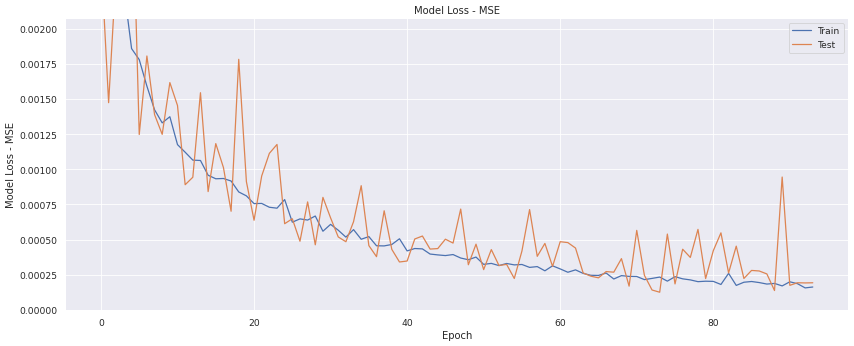

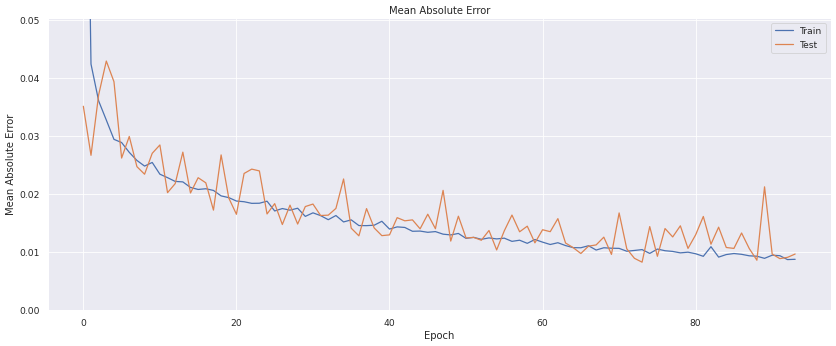

In [42]:
# Plot train vs test loss during training
plot_results(history.history['loss'], history.history['val_loss'], 'Model Loss - MSE')

# Plot train vs test accuracy during training
plot_results(history.history['mae'], history.history['val_mae'], 'Mean Absolute Error')

### Model Performance on Validation Dataset
Performance with model weights as of last epoch

In [43]:
print('Model Evaluation Loss: {:.3f}'.format(model.evaluate(X_valid, y_valid)[0]))

211/211 [==============================] - 0s 1ms/step - loss: 1.2483e-04 - mae: 0.0082 - mse: 1.2483e-04
Model Evaluation Loss: 0.000


Loading the best model weights due to early stopping

In [44]:
model.load_weights('../model/best_model.hdf5')
model.evaluate(X_valid, y_valid)

211/211 [==============================] - 0s 1ms/step - loss: 1.2483e-04 - mae: 0.0082 - mse: 1.2483e-04


[0.00012483212049119174, 0.00820728950202465, 0.00012483212049119174]

### Model Prediction on test data
Prediction on unseen data

In [45]:
predict_features = np.array(X_test)
y_predict = targetScaler.inverse_transform(model.predict(predict_features))

In [46]:
y_test['predictOptionValue'] = y_predict

Actual and Predicted values comparsion.  Blue dots should lie on the black line.

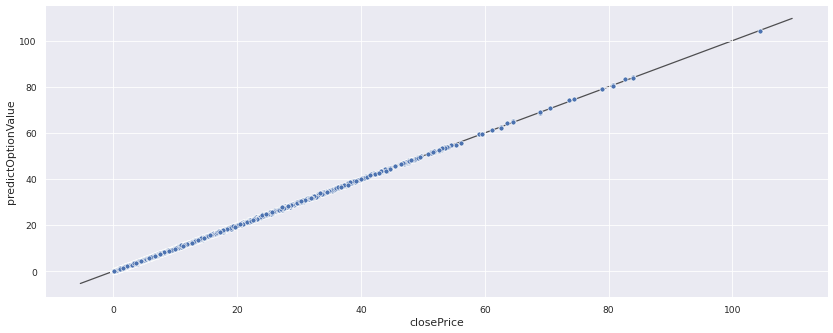

In [47]:
plot_check(y_test, target[0], 'predictOptionValue')

Statistics between Actual and Predicted values should be consistent.

In [48]:
y_test.describe()

,closePrice,predictOptionValue
count,6729.000000,6729.000000
mean,7.629303,7.598660
std,10.404891,10.409803
min,0.010000,-0.120714
25%,1.170000,1.146427
50%,3.740000,3.703387
75%,9.190000,9.204913
max,104.440000,104.146675


RMSE should be low and as close to zero as possible.  The results on test data (unseen data) is good.

In [49]:
from sklearn.metrics import mean_squared_error 
realVals = y_test[target]
predictedVals = y_test.predictOptionValue
rmse = mean_squared_error(realVals, predictedVals, squared = False)
print('RMSE: {:.3f}'.format(rmse))

RMSE: 0.118


## New Out-of-Sample testing
This is a new dataset of option prices extracted from an external source on another day.  Purpose is to test robustness of a model trained on a particular day still works on data provided on another day.

In [50]:
outofsample = pd.read_csv(DATA_FOLDER + 'out_of_sample.csv')

In [51]:
outofsample = outofsample[outofsample[target[0]] > 0]
outofsample.shape

(89605, 20)

In [52]:
print(pd.to_datetime(outofsample.datetimestamp).dt.tz_localize('UTC').dt.tz_convert('US/Eastern').min())
print(pd.to_datetime(outofsample.datetimestamp).dt.tz_localize('UTC').dt.tz_convert('US/Eastern').max())

2020-06-24 15:14:37.914559-04:00
2020-06-24 16:56:30.601671-04:00


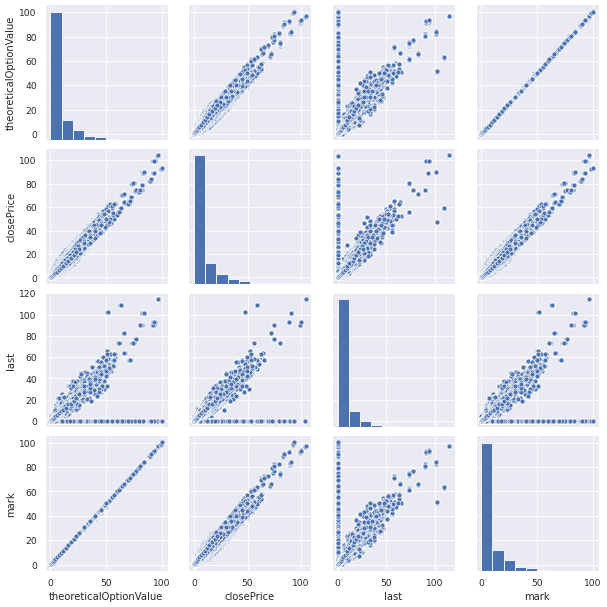

In [53]:
plot_pairs(outofsample, ['theoreticalOptionValue','closePrice','last','mark'])

### Feature Selection

In [54]:
outofsample = outofsample[features + target]
X_outofsample = outofsample[features]
y_outofsample = outofsample[target]

### Feature Transformation

In [55]:
X_outofsample = applyStdScaler(X_outofsample, tonormalise, trainScaler)
X_outofsample = applyOHE(X_outofsample, 'underlyingSymbol', symbol_OHE)
X_outofsample = applyLE(X_outofsample, 'putCall', putCall_LE)

### Model Prediction

In [56]:
predict_features = np.array(X_outofsample)
y_predict = targetScaler.inverse_transform(model.predict(predict_features))
y_outofsample['predictOptionValue'] = y_predict

### Model Performance
Good to see that the blue dots are still close to the black line.

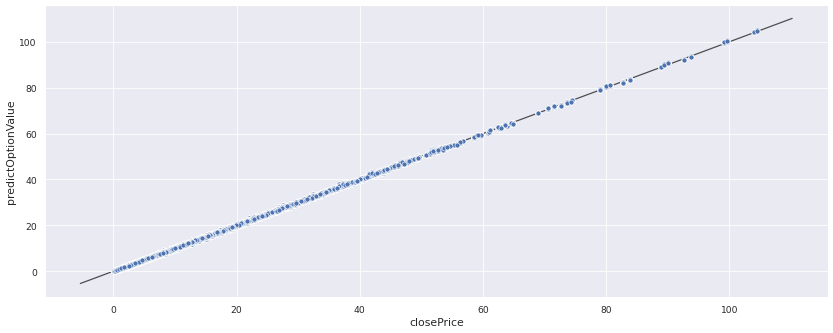

In [57]:
plot_check(y_outofsample, target[0], 'predictOptionValue')

In [58]:
y_outofsample.describe()

,closePrice,predictOptionValue
count,89605.000000,89605.000000
mean,7.612776,7.590651
std,10.448084,10.461838
min,0.010000,-0.121365
25%,1.180000,1.154968
50%,3.720000,3.689787
75%,9.100000,9.128570
max,104.440000,104.940453


In [59]:
from sklearn.metrics import mean_squared_error 
realVals = y_outofsample[target]
predictedVals = y_outofsample.predictOptionValue
rmse = mean_squared_error(realVals, predictedVals, squared = False)
print('RMSE: {:.3f}'.format(rmse))

RMSE: 0.144


In [60]:
y_outofsample

,closePrice,predictOptionValue
0,29.24,28.852877
1,26.80,26.364054
2,24.36,23.911339
3,21.97,21.465807
4,19.60,19.072395
...,...,...
90795,12.16,12.211660
90796,14.44,14.618677
90797,16.81,16.969353
90798,19.23,19.409735


## Concluding Notes
1.  It is possible to build a deep learning model to value an option with minimal observable data.
2.  Model accuracy should improve with more layers and nodes but training time will increase.
3.  Model accuracy should improve with more training data.
4.  Model can be updated with new feeds of training data to reflect the most recent market conditions.
5.  Model is currently predicting negative option values.  Predicted values should be constrained to positive values only.
6.  Analysis will need a significant large dataset to capture the larger spectrum of prices due the normalisation and scaling to improve the confidence level of the model performance.

# Thank you